# Milestone 3

This notebook is designed to explore and clarify key aspects of our dataset, including both preprocessing and analysis. We begin by loading the data and implementing general preprocessing steps that will be uniform throughout the notebook. The subsequent sections are organized according to the 5 research questions highlighted in the project's README. 

---

**Contents of notebook**:
1. [Section 1](#section1)
2. [Section 2](#section2)
    1. [Subsection 2.1](#section2_1)
    2. [Subsection 2.2](#section2_2)
3. [Section 3](#section3)

---

## Data Processing

---

### Loading data

In [212]:
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import ast
import scipy.stats as stats
from scipy.stats import ttest_ind
from datetime import datetime as dt
from helpers import *
import networkx as nx
from itertools import combinations
import gensim.corpora as corpora
from gensim.models import LdaModel
from nltk.corpus import stopwords
import nltk; nltk.download('stopwords')
import statsmodels.formula.api as smf
import statsmodels.api as sm
import patsy
from sklearn.preprocessing import StandardScaler
import re
import igraph as ig
import plotly.graph_objects as go
import community as community_louvain
from collections import Counter
from scipy.stats import gmean
from scipy.stats import mannwhitneyu

warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/thomassrour/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [55]:
DATA_FOLDER = './data/'
MOVIES_METADATA_PATH = DATA_FOLDER + 'movie.metadata.tsv'
PLOT_SUMMARIES_PATH = DATA_FOLDER + 'plot_summaries.txt'
CHARACTERS_METADATA_PATH = DATA_FOLDER +'character.metadata.tsv'
#IMDB
TITLE_RATINGS_PATH = DATA_FOLDER + 'title.ratings.tsv'
TITLE_BASICS_PATH = DATA_FOLDER + 'title.basics.tsv'
CREW_PATH = DATA_FOLDER + 'title.crew.tsv'
NAME_PATH =  DATA_FOLDER + "name.basics.tsv"
#Kaggle
MOVIES_PATH = DATA_FOLDER + 'movies.csv'
OSCARS_PATH = DATA_FOLDER + 'the_oscar_award.csv'
GOLDEN_GLOBE_PATH = DATA_FOLDER + 'golden_globe_awards.csv'

In [56]:
!pip install kaggle

zsh:1: command not found: pip


In [57]:
!kaggle datasets download -d akshaypawar7/millions-of-movies -p data/zip_files

zsh:1: command not found: kaggle


In [58]:
#Load data
movies_metadata_df = pd.read_csv(MOVIES_METADATA_PATH, sep='\t',header=None, names=['id', 'freebase_id', 'title', 'release_date', 'boxOffice_revenue', 'runtime', 'language', 'country', 'genres'])

imdb_ratings_df = pd.read_csv(TITLE_RATINGS_PATH, sep='\t')
imdb_basics_df = pd.read_csv(TITLE_BASICS_PATH, sep='\t', low_memory=False)
imdb_crew_df = pd.read_csv(CREW_PATH, sep='\t')
imdb_names_df = pd.read_csv(NAME_PATH, sep='\t', header=0)

kaggle_df = pd.read_csv(MOVIES_PATH)

characters_metadata_df = pd.read_csv(CHARACTERS_METADATA_PATH, sep='\t', names = ['Wikipedia movie ID','Freebase movie ID','Movie release date','Character name','Actor date of birth','Actor gender','Actor height','Actor ethnicity','Actor name','Actor age at movie release','Freebase character/actor map ID','Freebase character ID','Freebase actor ID'])

oscars_df = pd.read_csv(OSCARS_PATH)
golden_globe_df =  pd.read_csv(GOLDEN_GLOBE_PATH)

### MOVIES

##### CMU MetaData Dataset

In [59]:
test = pd.read_csv(MOVIES_METADATA_PATH, sep='\t',header=None, names=['id', 'freebase_id', 'title', 'release_date', 'boxOffice_revenue', 'runtime', 'language', 'country', 'genres'])

In [60]:
movies_metadata_df.head()

,id,freebase_id,title,release_date,boxOffice_revenue,runtime,language,country,genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"


In [61]:
movies_metadata_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81741 entries, 0 to 81740
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 81741 non-null  int64  
 1   freebase_id        81741 non-null  object 
 2   title              81741 non-null  object 
 3   release_date       74839 non-null  object 
 4   boxOffice_revenue  8401 non-null   float64
 5   runtime            61291 non-null  float64
 6   language           81741 non-null  object 
 7   country            81741 non-null  object 
 8   genres             81741 non-null  object 
dtypes: float64(2), int64(1), object(6)
memory usage: 5.6+ MB


In [62]:
# Convert release date to datetime
movies_metadata_df['release_date'] = movies_metadata_df['release_date'].apply(convert_release_date)
movies_metadata_df['year'] = movies_metadata_df['release_date'].dt.year

In [63]:
movies_metadata_df["language"] = movies_metadata_df["language"].apply(extract_items)
movies_metadata_df["country"] = movies_metadata_df["country"].apply(extract_items)
movies_metadata_df["genres"] = movies_metadata_df["genres"].apply(extract_items)
movies_metadata_df

,id,freebase_id,title,release_date,boxOffice_revenue,runtime,language,country,genres,year
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",2001.0
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,[English Language],[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]",2000.0
2,28463795,/m/0crgdbh,Brun bitter,1988-01-01,NaN,83.0,[Norwegian Language],[Norway],"[Crime Fiction, Drama]",1988.0
3,9363483,/m/0285_cd,White Of The Eye,1987-01-01,NaN,110.0,[English Language],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri...",1987.0
4,261236,/m/01mrr1,A Woman in Flames,1983-01-01,NaN,106.0,[German Language],[Germany],[Drama],1983.0
...,...,...,...,...,...,...,...,...,...,...
81736,35228177,/m/0j7hxnt,Mermaids: The Body Found,2011-03-19,NaN,120.0,[English Language],[United States of America],[Drama],2011.0
81737,34980460,/m/0g4pl34,Knuckle,2011-01-21,NaN,96.0,[English Language],"[Ireland, United Kingdom]","[Biographical film, Drama, Documentary]",2011.0
81738,9971909,/m/02pygw1,Another Nice Mess,1972-09-22,NaN,66.0,[English Language],[United States of America],"[Satire, Comedy]",1972.0
81739,913762,/m/03pcrp,The Super Dimension Fortress Macross II: Lover...,1992-05-21,NaN,150.0,[Japanese Language],[Japan],"[Science Fiction, Japanese Movies, Adventure, ...",1992.0


#### IMDB datasets (ratings + crew + metadata)

IMDB ratings

In [64]:
imdb_ratings_df.head()

,tconst,averageRating,numVotes
0,tt0000001,5.7,2007
1,tt0000002,5.8,269
2,tt0000003,6.5,1912
3,tt0000004,5.5,178
4,tt0000005,6.2,2692


In [65]:
imdb_ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1369534 entries, 0 to 1369533
Data columns (total 3 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   tconst         1369534 non-null  object 
 1   averageRating  1369534 non-null  float64
 2   numVotes       1369534 non-null  int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 31.3+ MB


In [66]:
imdb_ratings_df.describe()

,averageRating,numVotes
count,1.369534e+06,1.369534e+06
mean,6.959223e+00,1.038604e+03
std,1.382562e+00,1.759041e+04
min,1.000000e+00,5.000000e+00
25%,6.200000e+00,1.100000e+01
50%,7.200000e+00,2.600000e+01
75%,7.900000e+00,1.010000e+02
max,1.000000e+01,2.818872e+06


IMDB metadata

In [67]:
imdb_basics_df.drop(columns=['runtimeMinutes', 'isAdult', 'endYear'], inplace=True)

In [68]:
imdb_basics_df.head()

,tconst,titleType,primaryTitle,originalTitle,startYear,genres
0,tt0000001,short,Carmencita,Carmencita,1894,"Documentary,Short"
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,1892,"Animation,Short"
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,1892,"Animation,Comedy,Romance"
3,tt0000004,short,Un bon bock,Un bon bock,1892,"Animation,Short"
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,1893,"Comedy,Short"


In [69]:
imdb_basics_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10319916 entries, 0 to 10319915
Data columns (total 6 columns):
 #   Column         Dtype 
---  ------         ----- 
 0   tconst         object
 1   titleType      object
 2   primaryTitle   object
 3   originalTitle  object
 4   startYear      object
 5   genres         object
dtypes: object(6)
memory usage: 472.4+ MB


In [70]:
imdb_basics_df['titleType'].unique()

array(['short', 'movie', 'tvShort', 'tvMovie', 'tvSeries', 'tvEpisode',
       'tvMiniSeries', 'tvSpecial', 'video', 'videoGame', 'tvPilot'],
      dtype=object)

In [71]:
# Restrict our analysis to movies
imdb_basics_df = imdb_basics_df[imdb_basics_df['titleType'] == 'movie']
imdb_basics_df = imdb_basics_df.drop(columns = ['titleType'], axis=1)

IMDB movies crew

In [72]:
imdb_crew_df.head()

,tconst,directors,writers
0,tt0000001,nm0005690,\N
1,tt0000002,nm0721526,\N
2,tt0000003,nm0721526,\N
3,tt0000004,nm0721526,\N
4,tt0000005,nm0005690,\N


In [73]:
imdb_names_df.head()

,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles
0,nm0000001,Fred Astaire,1899,1987,"soundtrack,actor,miscellaneous","tt0031983,tt0050419,tt0053137,tt0072308"
1,nm0000002,Lauren Bacall,1924,2014,"actress,soundtrack","tt0117057,tt0037382,tt0038355,tt0075213"
2,nm0000003,Brigitte Bardot,1934,\N,"actress,soundtrack,music_department","tt0049189,tt0057345,tt0056404,tt0054452"
3,nm0000004,John Belushi,1949,1982,"actor,soundtrack,writer","tt0077975,tt0072562,tt0078723,tt0080455"
4,nm0000005,Ingmar Bergman,1918,2007,"writer,director,actor","tt0050986,tt0050976,tt0083922,tt0069467"


In [74]:
# Merge IMDb movies' rating and metadata
imdb_df = imdb_ratings_df.merge(imdb_basics_df, on='tconst', how='inner')
imdb_df = imdb_df.merge(imdb_crew_df, on='tconst', how='left')
imdb_df.head()

,tconst,averageRating,numVotes,primaryTitle,originalTitle,startYear,genres,directors,writers
0,tt0000009,5.3,207,Miss Jerry,Miss Jerry,1894,Romance,nm0085156,nm0085156
1,tt0000147,5.3,485,The Corbett-Fitzsimmons Fight,The Corbett-Fitzsimmons Fight,1897,"Documentary,News,Sport",nm0714557,\N
2,tt0000502,4.1,15,Bohemios,Bohemios,1905,\N,nm0063413,"nm0063413,nm0657268,nm0675388"
3,tt0000574,6.0,855,The Story of the Kelly Gang,The Story of the Kelly Gang,1906,"Action,Adventure,Biography",nm0846879,nm0846879
4,tt0000591,5.0,21,The Prodigal Son,L'enfant prodigue,1907,Drama,nm0141150,nm0141150


In [75]:
# Clean data
imdb_df.loc[imdb_df['startYear']=='\\N', 'startYear'] = np.nan
imdb_df['startYear'] = pd.to_numeric(imdb_df['startYear'], errors='coerce')

imdb_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300069 entries, 0 to 300068
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   tconst         300069 non-null  object 
 1   averageRating  300069 non-null  float64
 2   numVotes       300069 non-null  int64  
 3   primaryTitle   300069 non-null  object 
 4   originalTitle  300069 non-null  object 
 5   startYear      300032 non-null  float64
 6   genres         300069 non-null  object 
 7   directors      300069 non-null  object 
 8   writers        300069 non-null  object 
dtypes: float64(2), int64(1), object(6)
memory usage: 20.6+ MB


#### Kaggle movies dataset

In [76]:
kaggle_df.head()

,id,title,genres,original_language,overview,popularity,production_companies,release_date,budget,revenue,runtime,status,tagline,vote_average,vote_count,credits,keywords,poster_path,backdrop_path,recommendations
0,615656,Meg 2: The Trench,Action-Science Fiction-Horror,en,An exploratory dive into the deepest depths of...,8763.998,Apelles Entertainment-Warner Bros. Pictures-di...,2023-08-02,129000000.0,352056482.0,116.0,Released,Back for seconds.,7.079,1365.0,Jason Statham-Wu Jing-Shuya Sophia Cai-Sergio ...,based on novel or book-sequel-kaiju,/4m1Au3YkjqsxF8iwQy0fPYSxE0h.jpg,/qlxy8yo5bcgUw2KAmmojUKp4rHd.jpg,1006462-298618-569094-1061181-346698-1076487-6...
1,758323,The Pope's Exorcist,Horror-Mystery-Thriller,en,Father Gabriele Amorth Chief Exorcist of the V...,5953.227,Screen Gems-2.0 Entertainment-Jesus & Mary-Wor...,2023-04-05,18000000.0,65675816.0,103.0,Released,Inspired by the actual files of Father Gabriel...,7.433,545.0,Russell Crowe-Daniel Zovatto-Alex Essoe-Franco...,spain-rome italy-vatican-pope-pig-possession-c...,/9JBEPLTPSm0d1mbEcLxULjJq9Eh.jpg,/hiHGRbyTcbZoLsYYkO4QiCLYe34.jpg,713704-296271-502356-1076605-1084225-1008005-9...
2,667538,Transformers: Rise of the Beasts,Action-Adventure-Science Fiction,en,When a new threat capable of destroying the en...,5409.104,Skydance-Paramount-di Bonaventura Pictures-Bay...,2023-06-06,200000000.0,407045464.0,127.0,Released,Unite or fall.,7.340,1007.0,Anthony Ramos-Dominique Fishback-Luna Lauren V...,peru-alien-end of the world-based on cartoon-b...,/gPbM0MK8CP8A174rmUwGsADNYKD.jpg,/woJbg7ZqidhpvqFGGMRhWQNoxwa.jpg,496450-569094-298618-385687-877100-598331-4628...
3,640146,Ant-Man and the Wasp: Quantumania,Action-Adventure-Science Fiction,en,Super-Hero partners Scott Lang and Hope van Dy...,4425.387,Marvel Studios-Kevin Feige Productions,2023-02-15,200000000.0,475766228.0,125.0,Released,Witness the beginning of a new dynasty.,6.507,2811.0,Paul Rudd-Evangeline Lilly-Jonathan Majors-Kat...,hero-ant-sequel-superhero-based on comic-famil...,/qnqGbB22YJ7dSs4o6M7exTpNxPz.jpg,/m8JTwHFwX7I7JY5fPe4SjqejWag.jpg,823999-676841-868759-734048-267805-965839-1033...
4,677179,Creed III,Drama-Action,en,After dominating the boxing world Adonis Creed...,3994.342,Metro-Goldwyn-Mayer-Proximity Media-Balboa Pro...,2023-03-01,75000000.0,269000000.0,116.0,Released,You can't run from your past.,7.262,1129.0,Michael B. Jordan-Tessa Thompson-Jonathan Majo...,philadelphia pennsylvania-husband wife relatio...,/cvsXj3I9Q2iyyIo95AecSd1tad7.jpg,/5i6SjyDbDWqyun8klUuCxrlFbyw.jpg,965839-267805-943822-842942-1035806-823999-107...


In [77]:
kaggle_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 722649 entries, 0 to 722648
Data columns (total 20 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    722649 non-null  int64  
 1   title                 722643 non-null  object 
 2   genres                511971 non-null  object 
 3   original_language     722649 non-null  object 
 4   overview              604165 non-null  object 
 5   popularity            722649 non-null  float64
 6   production_companies  337227 non-null  object 
 7   release_date          670577 non-null  object 
 8   budget                722649 non-null  float64
 9   revenue               722649 non-null  float64
 10  runtime               688231 non-null  float64
 11  status                722649 non-null  object 
 12  tagline               108238 non-null  object 
 13  vote_average          722649 non-null  float64
 14  vote_count            722649 non-null  float64
 15  

In [78]:
kaggle_df.drop(columns = ['id','poster_path','keywords','backdrop_path','recommendations','status','tagline'], inplace = True)
kaggle_df['release_date'] = kaggle_df['release_date'].apply(convert_release_date)
kaggle_df['year'] = kaggle_df['release_date'].dt.year

#### Merging the dataframes

- **Movie Metadata Identification:** The `Movie.metadata.tsv` file uses Wikipedia IDs to identify movies, whereas the IMDb datasets utilize their unique IDs. Additionally, the Kaggle dataset employs a different set of IDs.

- **Unified Identification Approach:** To merge data from these diverse sources, **movie names will be used as a common identifier**. This approach assumes that movie names are consistent across the datasets.

- **Handling Inconsistent Release Dates:** Post-merging, the dataset will be filtered to **remove entries with release dates that differ by more than one year**. This step is crucial to ensure data consistency and reliability, especially when dealing with release date discrepancies across different sources.


In [79]:
# Check both primary and original Title
primary_merge = movies_metadata_df.merge(imdb_df, left_on='title', right_on='primaryTitle', how='left')
original_merge = movies_metadata_df.merge(imdb_df, left_on='title', right_on='originalTitle', how='left')
ratings_df = pd.concat([primary_merge, original_merge])
df_nan = ratings_df[ratings_df['tconst'].isna()]
df_non_nan = ratings_df[ratings_df['tconst'].notna()]

# Removing duplicates from non-NaN dataframe
df_non_nan_unique = df_non_nan.drop_duplicates(subset='tconst', keep='first')

# Concatenate back the NaN dataframe
ratings_df = pd.concat([df_non_nan_unique, df_nan])
ratings_df

,id,freebase_id,title,release_date,boxOffice_revenue,runtime,language,country,genres_x,year,tconst,averageRating,numVotes,primaryTitle,originalTitle,startYear,genres_y,directors,writers
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",2001.0,tt0228333,4.9,56933.0,Ghosts of Mars,Ghosts of Mars,2001.0,"Action,Horror,Sci-Fi",nm0000118,"nm0837917,nm0000118"
2,28463795,/m/0crgdbh,Brun bitter,1988-01-01,NaN,83.0,[Norwegian Language],[Norway],"[Crime Fiction, Drama]",1988.0,tt0094806,5.6,41.0,Brun bitter,Brun bitter,1988.0,"Crime,Drama",nm0803751,"nm0803751,nm0820866"
4,261236,/m/01mrr1,A Woman in Flames,1983-01-01,NaN,106.0,[German Language],[Germany],[Drama],1983.0,tt0083949,5.9,623.0,A Woman in Flames,Die flambierte Frau,1983.0,Drama,nm0885554,"nm0885554,nm0959016"
5,13696889,/m/03cfc81,The Gangsters,1913-05-29,NaN,35.0,"[Silent film, English Language]",[United States of America],"[Short Film, Silent film, Indie, Black-and-whi...",1913.0,tt0139667,5.6,33.0,The Gangsters,Les truands,1957.0,"Comedy,Crime",nm0727225,nm0727225
6,13696889,/m/03cfc81,The Gangsters,1913-05-29,NaN,35.0,"[Silent film, English Language]",[United States of America],"[Short Film, Silent film, Indie, Black-and-whi...",1913.0,tt27788655,6.2,6.0,The Gangsters,The Gangsters,2019.0,Action,nm14862992,\N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112686,26482675,/m/0bbwngb,Eşrefpaşalılar,2010-03-05,1847671.0,NaN,[],[],"[Comedy film, Drama]",2010.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
112690,32468537,/m/0crwd9y,Shadow Boxing 2,2007-10-18,NaN,132.0,"[Russian Language, English Language]",[Russia],"[Sports, Crime Fiction, Action, Drama]",2007.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
112691,35228177,/m/0j7hxnt,Mermaids: The Body Found,2011-03-19,NaN,120.0,[English Language],[United States of America],[Drama],2011.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
112694,913762,/m/03pcrp,The Super Dimension Fortress Macross II: Lover...,1992-05-21,NaN,150.0,[Japanese Language],[Japan],"[Science Fiction, Japanese Movies, Adventure, ...",1992.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [80]:
# Tolerate at most 1 year difference
ratings_df['releaseDiff'] = (ratings_df['year'] - ratings_df['startYear']).abs()
ratings_df = ratings_df[(ratings_df['releaseDiff'] <= 1) | (ratings_df['releaseDiff'].isna())]
ratings_df = ratings_df.drop(columns=['releaseDiff'],axis=1)
ratings_df[ratings_df["release_date"].isna()]

,id,freebase_id,title,release_date,boxOffice_revenue,runtime,language,country,genres_x,year,tconst,averageRating,numVotes,primaryTitle,originalTitle,startYear,genres_y,directors,writers
95,31137877,/m/0gh7n22,Boadicea,NaT,NaN,NaN,[],[],"[Drama, Historical drama, War film]",NaN,tt0018713,7.7,13.0,Boadicea,Boadicea,1927.0,"Drama,History,War",nm0384682,"nm0002190,nm0384682"
96,31137877,/m/0gh7n22,Boadicea,NaT,NaN,NaN,[],[],"[Drama, Historical drama, War film]",NaN,tt5624774,4.7,8.0,Boadicea,Boadicea,1966.0,Fantasy,nm0614543,nm0614543
107,27374355,/m/0by1_ff,Les Indiens sont encore loin,NaT,NaN,95.0,[],"[France, Switzerland]",[Drama],NaN,tt0074681,6.4,96.0,Les Indiens sont encore loin,Les Indiens sont encore loin,1977.0,Drama,nm0603220,nm0603220
156,21373150,/m/05fb20v,Mighty Mouse in the Great Space Chase,NaT,NaN,86.0,[],[United States of America],[Children's/Family],NaN,tt0191280,5.7,160.0,Mighty Mouse in the Great Space Chase,Mighty Mouse in the Great Space Chase,1982.0,"Action,Adventure,Animation","nm0295209,nm0434172,nm0483726,nm0923252,nm0942...","nm0228772,nm0800376"
230,25790807,/m/09v6_q1,Sons of Cuba,NaT,NaN,88.0,[],[United Kingdom],"[Sports, Culture & Society, Documentary]",NaN,tt1391122,7.4,132.0,Sons of Cuba,Sons of Cuba,2009.0,Documentary,nm3334152,\N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112475,12363243,/m/02w13vj,Hearts of Youth,NaT,NaN,NaN,[],[United States of America],"[Silent film, Drama, Indie]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
112506,29119097,/m/0dlmtgr,Target: The Final Mission,NaT,NaN,NaN,[Bengali Language],[],[Action],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
112553,31869121,/m/0gvvfx6,The Duchess of Seven Dials,NaT,NaN,NaN,[],[],[Romance Film],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
112608,29319381,/m/0dryrv3,La Bande à papa,NaT,NaN,90.0,[],[],[Comedy film],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [81]:
# Merge CMU and IMDb datasets with the Kaggle dataset
revenues_ratings_df = ratings_df.merge(
    kaggle_df,
    on='title',
    how='left'
)

# Tolerate at most 1 year difference
revenues_ratings_df['releaseDiff2'] = (revenues_ratings_df['year_x'] - revenues_ratings_df['year_y']).abs()
revenues_ratings_df = revenues_ratings_df[(revenues_ratings_df['releaseDiff2'] <= 1) | (revenues_ratings_df['releaseDiff2'].isna())]
revenues_ratings_df = revenues_ratings_df.drop(columns=['release_date_y','runtime_y','genres_y','releaseDiff2','year_y'],axis=1)
revenues_ratings_df.rename(columns={'year_x': "year",'genre_x': "genre", "release_date_x":"release_date","runtime_x":"runtime"},inplace = True)
revenues_ratings_df

,id,freebase_id,title,release_date,boxOffice_revenue,runtime,language,country,genres_x,year,...,genres,original_language,overview,popularity,production_companies,budget,revenue,vote_average,vote_count,credits
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",2001.0,...,Action-Horror-Science Fiction,en,In 2176 a Martian police unit is sent to pick ...,13.057,Screen Gems-Storm King Productions-Animationwerks,28000000.0,14010832.0,5.154,911.0,Natasha Henstridge-Ice Cube-Pam Grier-Jason St...
1,28463795,/m/0crgdbh,Brun bitter,1988-01-01,NaN,83.0,[Norwegian Language],[Norway],"[Crime Fiction, Drama]",1988.0,...,NaN,no,NaN,0.600,NaN,0.0,0.0,0.000,0.0,Frank Krog-Kristin Kajander-Anne Krigsvoll-Bjø...
2,261236,/m/01mrr1,A Woman in Flames,1983-01-01,NaN,106.0,[German Language],[Germany],[Drama],1983.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,18998739,/m/04jcqvw,The Sorcerer's Apprentice,2002-01-01,NaN,86.0,[English Language],[South Africa],"[Family Film, Fantasy, Adventure, World cinema]",2002.0,...,Adventure-Family-Fantasy,en,Every hundred years the evil sorceress Morgana...,3.362,Peakviewing Productions-Peakviewing Transatlan...,0.0,0.0,4.800,10.0,Kelly LeBrock-Robert Davi-Byron Taylor-Greg Me...
10,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938-08-16,3600000.0,106.0,[English Language],[United States of America],"[Musical, Comedy, Black-and-white]",1938.0,...,Drama-Music-Romance,en,Classical violinist Roger Grant disappoints hi...,2.030,20th Century Fox,2000000.0,4000000.0,6.614,22.0,Tyrone Power-Alice Faye-Don Ameche-Ethel Merma...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181198,26482675,/m/0bbwngb,Eşrefpaşalılar,2010-03-05,1847671.0,NaN,[],[],"[Comedy film, Drama]",2010.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
181199,32468537,/m/0crwd9y,Shadow Boxing 2,2007-10-18,NaN,132.0,"[Russian Language, English Language]",[Russia],"[Sports, Crime Fiction, Action, Drama]",2007.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
181200,35228177,/m/0j7hxnt,Mermaids: The Body Found,2011-03-19,NaN,120.0,[English Language],[United States of America],[Drama],2011.0,...,Science Fiction,en,A story that imagines how these real-world phe...,7.727,DSP,0.0,0.0,4.700,18.0,Sean Cameron Michael-Andre Weideman-Candice D'...
181201,913762,/m/03pcrp,The Super Dimension Fortress Macross II: Lover...,1992-05-21,NaN,150.0,[Japanese Language],[Japan],"[Science Fiction, Japanese Movies, Adventure, ...",1992.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [82]:
revenues_ratings_df.drop_duplicates(subset=['freebase_id'],keep='first',inplace=True)

Almost 90% of the movie revenues are absent. We used the kaggle dataset to enrich our dataset:

In [83]:
nan_percentage = revenues_ratings_df['boxOffice_revenue'].isna().mean() * 100
nan_percentage

89.56193374758705

In [84]:
nan_percentage =  movies_metadata_df['boxOffice_revenue'].isna().mean() * 100
nan_percentage

89.72241592346558

In [85]:
nan_or_zero_count = (revenues_ratings_df['revenue'].isna() | (revenues_ratings_df['revenue'] == 0)).mean() * 100
print(f"Percentage of NaN or zero values in revenue: {nan_or_zero_count:.2f}%")

Percentage of NaN or zero values in revenue: 90.26%


In [86]:
# Replace NaN values in boxOffice_revenue with revenue values only when revenue is not 0
revenues_ratings_df.loc[revenues_ratings_df['boxOffice_revenue'].isna() & (revenues_ratings_df['revenue'] != 0), 'boxOffice_revenue'] = revenues_ratings_df['revenue']

In [87]:
revenues_ratings_df[(revenues_ratings_df['boxOffice_revenue'].isna()) & (revenues_ratings_df['revenue'] == 0)]

,id,freebase_id,title,release_date,boxOffice_revenue,runtime,language,country,genres_x,year,...,genres,original_language,overview,popularity,production_companies,budget,revenue,vote_average,vote_count,credits
1,28463795,/m/0crgdbh,Brun bitter,1988-01-01,NaN,83.0,[Norwegian Language],[Norway],"[Crime Fiction, Drama]",1988.0,...,NaN,no,NaN,0.600,NaN,0.0,0.0,0.0,0.0,Frank Krog-Kristin Kajander-Anne Krigsvoll-Bjø...
5,18998739,/m/04jcqvw,The Sorcerer's Apprentice,2002-01-01,NaN,86.0,[English Language],[South Africa],"[Family Film, Fantasy, Adventure, World cinema]",2002.0,...,Adventure-Family-Fantasy,en,Every hundred years the evil sorceress Morgana...,3.362,Peakviewing Productions-Peakviewing Transatlan...,0.0,0.0,4.8,10.0,Kelly LeBrock-Robert Davi-Byron Taylor-Greg Me...
12,175026,/m/017n1p,Sarah and Son,1930-01-01,NaN,86.0,[English Language],[United States of America],"[Drama, Black-and-white]",1930.0,...,Drama,en,A ne'er-do-well husband after years of abusing...,1.103,Paramount,0.0,0.0,5.0,7.0,Ruth Chatterton-Fredric March-Fuller Mellish J...
13,24229100,/m/07kjkz6,Lady Snowblood 2: Love Song of Vengeance,1974-01-01,NaN,89.0,[Japanese Language],[Japan],"[Crime Fiction, Thriller, Japanese Movies, Wor...",1974.0,...,Action-Drama-Thriller,ja,Lady Snowblood is caught by the police and sen...,7.903,TOHO-Toho Film (Eiga) Co. Ltd.,0.0,0.0,6.4,94.0,Meiko Kaji-Juzo Itami-Yoshio Harada-Kazuko Yos...
20,175024,/m/017n1b,The Devil's Holiday,1930-01-01,NaN,NaN,[English Language],[United States of America],"[Romance Film, Drama, Black-and-white]",1930.0,...,Drama-Romance,en,Beautiful manicurist Hallie Hobart sets her si...,1.611,Paramount,0.0,0.0,6.4,5.0,Nancy Carroll-Phillips Holmes-James Kirkwood-H...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180791,10509444,/m/02qg7mp,Aladdin and His Magic Lamp,1970-01-28,NaN,71.0,[French Language],[France],"[Fantasy, Adventure, Animation]",1970.0,...,Animation-Family-Adventure-Fantasy,fr,He travels to Aladdin's village identified as ...,2.302,NaN,0.0,0.0,6.8,6.0,Gaston Guez-Lucie Dolène-Claire Guibert-Lita R...
180857,32149223,/m/0gxz3td,Peekaboo,2010-01-01,NaN,10.0,[English Language],[Australia],"[Short Film, Thriller, Drama]",2010.0,...,Drama,en,When a toddler goes missing in a car park her ...,0.600,NaN,0.0,0.0,0.0,0.0,Justine Clarke-Alan Dukes-Marli Bedwell-Marisa...
181004,12976553,/m/02z1_64,The Slave,1917-12-15,NaN,NaN,[English Language],[United States of America],"[Short Film, Silent film, Indie, Black-and-whi...",1917.0,...,Drama,en,Caroline works at a hair dressing parlor. A we...,0.600,Fox Film Corporation,0.0,0.0,0.0,0.0,Valeska Suratt-Violet Palmer-Eric Mayne-Herber...
181038,17111000,/m/0421l_t,Yearning,1990-10-01,NaN,136.0,[Armenian Language],[Soviet Union],"[Melodrama, Drama]",1990.0,...,Drama,hy,Real life tragic story of Arakel whose anguish...,0.960,Armenfilm-Hayfilm Studio,0.0,0.0,5.0,4.0,Rafael Atoyan-Galya Novents-Ashot Melikdzhanya...


In [88]:
revenues_ratings_df.drop(columns=['revenue'],inplace=True)

In [89]:
nan_percentage = revenues_ratings_df['boxOffice_revenue'].isna().mean() * 100
nan_percentage

86.02950500908821

We recovered around X% of relevant data!

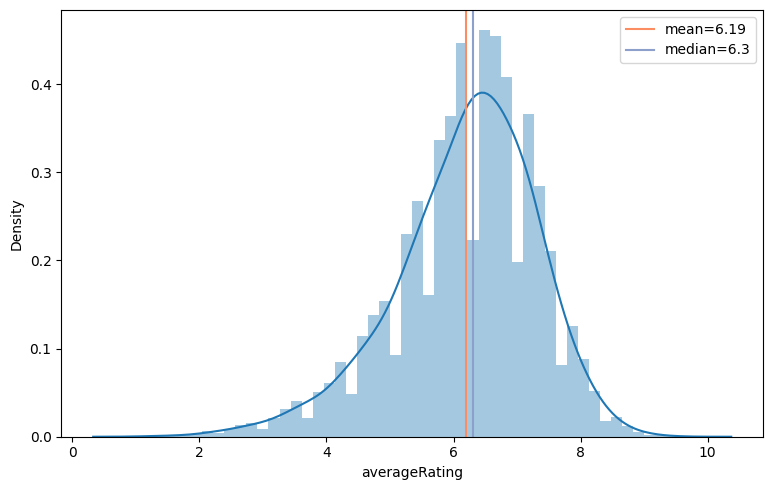

In [90]:
# Average rating distribution shows a classic negative skewed distribution where the median is larger than mean. 
ratings = dict(mean=revenues_ratings_df.averageRating.mean(),
              median=revenues_ratings_df.averageRating.median())


plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
ax1 = sns.distplot(revenues_ratings_df.averageRating,kde_kws=dict(bw=0.2))
ax1.axvline(x=ratings["mean"],c=sns.color_palette("Set2")[1],label=f"mean={round(ratings['mean'],2)}")
ax1.axvline(x=ratings["median"],c=sns.color_palette("Set2")[2],label=f"median={round(ratings['median'],2)}")
plt.legend()
plt.tight_layout()
plt.show()


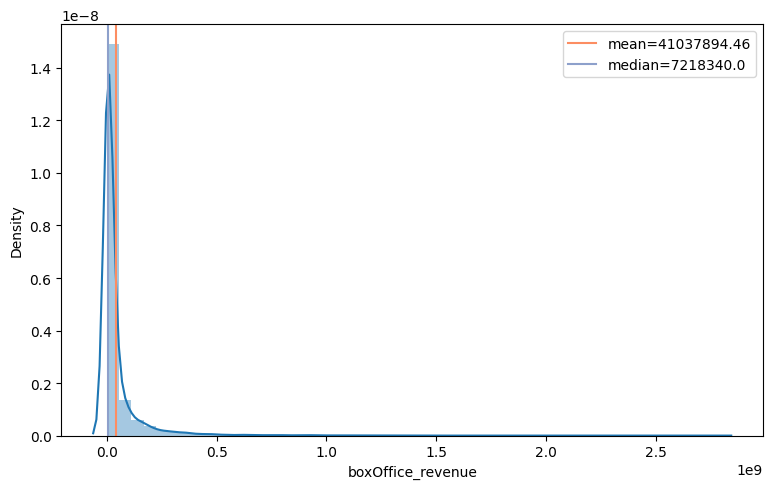

In [91]:
ratings = dict(mean=revenues_ratings_df.boxOffice_revenue.mean(),
              median=revenues_ratings_df.boxOffice_revenue.median())


plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
ax1 = sns.distplot(revenues_ratings_df.boxOffice_revenue,kde_kws=dict(bw=0.2))
ax1.axvline(x=ratings["mean"],c=sns.color_palette("Set2")[1],label=f"mean={round(ratings['mean'],2)}")
ax1.axvline(x=ratings["median"],c=sns.color_palette("Set2")[2],label=f"median={round(ratings['median'],2)}")
plt.legend()
plt.tight_layout()
plt.show()


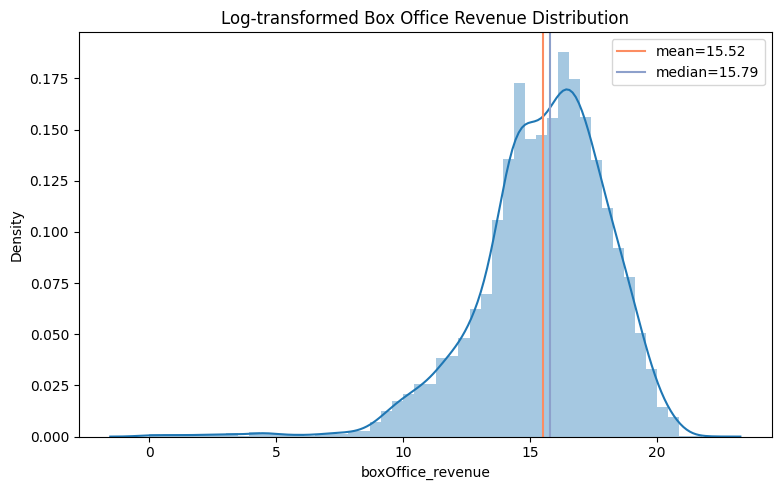

In [92]:
# Filter out non-positive values
positive_revenue_df = revenues_ratings_df[revenues_ratings_df.boxOffice_revenue > 0]

# Calculate the logarithm of the revenues
log_revenues = np.log(positive_revenue_df.boxOffice_revenue)

# Calculate mean and median
log_ratings = dict(mean=log_revenues.mean(), median=log_revenues.median())

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
ax1 = sns.distplot(log_revenues, kde_kws=dict(bw=0.2))
ax1.axvline(x=log_ratings["mean"], c=sns.color_palette("Set2")[1], label=f"mean={round(log_ratings['mean'],2)}")
ax1.axvline(x=log_ratings["median"], c=sns.color_palette("Set2")[2], label=f"median={round(log_ratings['median'],2)}")
plt.legend()
plt.title("Log-transformed Box Office Revenue Distribution")
plt.tight_layout()
plt.show()


### ACTORS

<div style="margin-right: 100px;">
    <img src="https://www.bing.com/th/id/OGC.3ca1b513d723710727171a7ade691f00?pid=1.7&rurl=https%3a%2f%2fmedia.giphy.com%2fmedia%2fNCcKdYTzaZ8Eo%2fgiphy.gif&ehk=gsHhihh%2fUvFFcGrOKx07Wv88t%2bUn0tgNkHGrV5Lf39w%3d" width="700" height="500">
</div>


#### CMU dataset

In [93]:
characters_metadata_df.columns

Index(['Wikipedia movie ID', 'Freebase movie ID', 'Movie release date',
       'Character name', 'Actor date of birth', 'Actor gender', 'Actor height',
       'Actor ethnicity', 'Actor name', 'Actor age at movie release',
       'Freebase character/actor map ID', 'Freebase character ID',
       'Freebase actor ID'],
      dtype='object')

In [94]:
characters_metadata_df.drop(columns=["Freebase character/actor map ID","Freebase character ID", "Actor height"],inplace=True)

In [95]:
characters_metadata_df.head()

,Wikipedia movie ID,Freebase movie ID,Movie release date,Character name,Actor date of birth,Actor gender,Actor ethnicity,Actor name,Actor age at movie release,Freebase actor ID
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,NaN,Wanda De Jesus,42.0,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,/m/044038p,Natasha Henstridge,27.0,/m/0346l4
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,/m/0x67,Ice Cube,32.0,/m/01vw26l
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,NaN,Jason Statham,33.0,/m/034hyc
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,NaN,Clea DuVall,23.0,/m/01y9xg


In [96]:
characters_metadata_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 450669 entries, 0 to 450668
Data columns (total 10 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   Wikipedia movie ID          450669 non-null  int64  
 1   Freebase movie ID           450669 non-null  object 
 2   Movie release date          440674 non-null  object 
 3   Character name              192794 non-null  object 
 4   Actor date of birth         344524 non-null  object 
 5   Actor gender                405060 non-null  object 
 6   Actor ethnicity             106058 non-null  object 
 7   Actor name                  449441 non-null  object 
 8   Actor age at movie release  292556 non-null  float64
 9   Freebase actor ID           449854 non-null  object 
dtypes: float64(1), int64(1), object(8)
memory usage: 34.4+ MB


In [97]:
# Convert 'Actor date of birth' to datetime
characters_metadata_df['Actor date of birth'] = pd.to_datetime(characters_metadata_df['Actor date of birth'], errors='coerce', utc = True)
characters_metadata_df['Actor birth year'] = characters_metadata_df['Actor date of birth'].dt.year

In [98]:
actors_df = characters_metadata_df.copy()
movie_names = movies_metadata_df[["freebase_id","title"]]
# Merge the actors DataFrame with the movie names DataFrame to include the movie title in the actors DataFrame
# This is done by matching 'Freebase movie ID' from actors_df with 'freebase_id' from movie_names
actors_df = pd.merge(actors_df, movie_names[['title', 'freebase_id']], left_on='Freebase movie ID', right_on='freebase_id', how='left')


# Convert 'Actor date of birth' to datetime format and extract the date
actors_df['Actor date of birth'] = pd.to_datetime(actors_df['Actor date of birth'])
actors_df['Actor date of birth'] = actors_df['Actor date of birth'].dt.date

# Group the actors DataFrame by 'Freebase actor ID' and 'Actor name' and aggregate the movie titles and freebase_ids
# This creates a list of titles and freebase_ids for each actor
aggregated_data_df = actors_df.groupby(["Freebase actor ID", "Actor name"]).agg({
    'title': lambda x: list(x),
    'freebase_id': lambda x: list(x)
}).reset_index()

unique_actors_df = actors_df.drop_duplicates(subset=["Freebase actor ID", "Actor name"]).drop(columns=['title', 'freebase_id'])
actor_movies_df = pd.merge(unique_actors_df, aggregated_data_df, on=["Freebase actor ID", "Actor name"])

actor_movies_df = actor_movies_df.drop(["Character name","Wikipedia movie ID","Freebase movie ID","Movie release date","Actor age at movie release"],axis=1)

actor_movies_df

,Actor date of birth,Actor gender,Actor ethnicity,Actor name,Freebase actor ID,Actor birth year,title,freebase_id
0,1958-08-26,F,NaN,Wanda De Jesus,/m/03wcfv7,1958.0,"[Ghosts of Mars, The Ministers, Almost a Woman...","[/m/03vyhn, /m/0809s7n, /m/0dg7mt, /m/04t8wq, ..."
1,1974-08-15,F,/m/044038p,Natasha Henstridge,/m/0346l4,1974.0,"[Ghosts of Mars, Adrenalin: Fear the Rush, The...","[/m/03vyhn, /m/02854l1, /m/03_gr5, /m/06sbvgb,..."
2,1969-06-15,M,/m/0x67,Ice Cube,/m/01vw26l,1969.0,"[Ghosts of Mars, Friday After Next, XXX: The R...","[/m/03vyhn, /m/06x8g2, /m/083xgxs, /m/04f3j1r,..."
3,1967-09-12,M,NaN,Jason Statham,/m/034hyc,1967.0,"[Ghosts of Mars, The Expendables, Death Race, ...","[/m/03vyhn, /m/053rxgm, /m/03b_h1l, /m/01dvbd,..."
4,1977-09-25,F,NaN,Clea DuVall,/m/01y9xg,1977.0,"[Ghosts of Mars, Sleeping Beauties, The Grudge...","[/m/03vyhn, /m/026f_k5, /m/045j3w, /m/06v_2g, ..."
...,...,...,...,...,...,...,...,...
135417,NaT,F,NaN,Violet Bronte,/m/0kr409z,NaN,[The Super Dimension Fortress Macross II: Love...,[/m/03pcrp]
135418,NaT,M,NaN,Sonny Byrkett,/m/0gn4bz,NaN,[The Super Dimension Fortress Macross II: Love...,"[/m/03pcrp, /m/03pcrp]"
135419,NaT,F,NaN,Susan Byrkett,/m/0gn4nd,NaN,[The Super Dimension Fortress Macross II: Love...,[/m/03pcrp]
135420,NaT,M,NaN,Hal Cleaveland,/m/0kr407h,NaN,[The Super Dimension Fortress Macross II: Love...,[/m/03pcrp]


In [99]:
actor_movies_df[ actor_movies_df['Actor name'] == 'Tom Hanks']

,Actor date of birth,Actor gender,Actor ethnicity,Actor name,Freebase actor ID,Actor birth year,title,freebase_id
6903,1956-07-09,M,/m/02p4q5p,Tom Hanks,/m/0bxtg,1956.0,"[Sleepless in Seattle, Bachelor Party, Beyond ...","[/m/01gzln, /m/0604zn, /m/0gxwwlg, /m/0j63lyh,..."


#### Oscar dataset

<div style="margin-right: 150px;">
    <img src="https://www.oscars.org/sites/oscars/files/styles/news_image_default/public/87th_nominations.jpg?itok=VuwEUbgv" width="500" height="300">
</div>


In [100]:
oscars_df.head()

,year_film,year_ceremony,ceremony,category,name,film,winner
0,1927,1928,1,ACTOR,Richard Barthelmess,The Noose,False
1,1927,1928,1,ACTOR,Emil Jannings,The Last Command,True
2,1927,1928,1,ACTRESS,Louise Dresser,A Ship Comes In,False
3,1927,1928,1,ACTRESS,Janet Gaynor,7th Heaven,True
4,1927,1928,1,ACTRESS,Gloria Swanson,Sadie Thompson,False


In [101]:
oscars_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10765 entries, 0 to 10764
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   year_film      10765 non-null  int64 
 1   year_ceremony  10765 non-null  int64 
 2   ceremony       10765 non-null  int64 
 3   category       10765 non-null  object
 4   name           10761 non-null  object
 5   film           10450 non-null  object
 6   winner         10765 non-null  bool  
dtypes: bool(1), int64(3), object(3)
memory usage: 515.2+ KB


#### Golden Globe dataset

<div style="margin-right: 150px;">
    <img src="https://img.nbc.com/sites/nbcunbc/files/files/images/2019/1/02/GoldenGlobes_2019-Logo-1920x1080.jpg" width="500" height="300">
</div>


!kaggle datasets download -d unanimad/golden-globe-awards -p data/zip_files

In [102]:
golden_globe_df.rename(columns={'win': "winner", "nominee":"name","year_award":"year_ceremony"},inplace = True)
golden_globe_df.head()

,year_film,year_ceremony,ceremony,category,name,film,winner
0,1943,1944,1,Best Performance by an Actress in a Supporting...,Katina Paxinou,For Whom The Bell Tolls,True
1,1943,1944,1,Best Performance by an Actor in a Supporting R...,Akim Tamiroff,For Whom The Bell Tolls,True
2,1943,1944,1,Best Director - Motion Picture,Henry King,The Song Of Bernadette,True
3,1943,1944,1,Picture,The Song Of Bernadette,NaN,True
4,1943,1944,1,Actress In A Leading Role,Jennifer Jones,The Song Of Bernadette,True


In [103]:
# Get all awards in a single Dataframe
awards_df= pd.concat([golden_globe_df,oscars_df], axis = 0)
awards_df[awards_df['name'] == 'Tom Hanks']

,year_film,year_ceremony,ceremony,category,name,film,winner
3980,1988,1989,46,Best Performance by an Actor in a Motion Pictu...,Tom Hanks,Big,True
4599,1993,1994,51,Best Performance by an Actor in a Motion Pictu...,Tom Hanks,Philadelphia,True
4610,1993,1994,51,Best Performance by an Actor in a Motion Pictu...,Tom Hanks,Sleepless in Seattle,False
4721,1994,1995,52,Best Performance by an Actor in a Motion Pictu...,Tom Hanks,Forrest Gump,True
5225,1998,1999,56,Best Performance by an Actor in a Motion Pictu...,Tom Hanks,Saving Private Ryan,False
5479,2000,2001,58,Best Performance by an Actor in a Motion Pictu...,Tom Hanks,Cast Away,True
6376,2007,2008,65,Best Performance by an Actor in a Motion Pictu...,Tom Hanks,Charlie Wilson's War,False
7125,2013,2014,71,Best Performance by an Actor in a Motion Pictu...,Tom Hanks,Captain Phillips,False
7629,2017,2018,75,Best Performance by an Actor in a Motion Pictu...,Tom Hanks,The Post,False
7900,2019,2020,77,Best Performance by an Actor in a Supporting R...,Tom Hanks,"Beautiful Day in the Neighborhood, A",False


In [104]:
# Explode 'title' in actor_movies_df for easier comparison
exploded_actor_movies_df = actor_movies_df.explode('title')

# Merge oscars_df with exploded_actor_movies_df based on 'name' and 'film'
merged_df = awards_df.merge(exploded_actor_movies_df, left_on=['name', 'film'], right_on=['Actor name', 'title'], how='left')

# Check for unique and non-unique actors
unique_actors = exploded_actor_movies_df['Actor name'].drop_duplicates(keep=False)
merged_df['is_unique'] = merged_df['Actor name'].isin(unique_actors)

# For unique actors, keep the row as is. For non-unique, keep only if there's a match in the title
actor_awards = merged_df[(merged_df['is_unique']) | (merged_df['title'].notnull())].drop(columns=['is_unique'])



In [105]:
# Group by 'Freebase actor ID'
grouped = actor_awards.groupby('Freebase actor ID')

# Aggregate data
aggregated = grouped.agg(
    won=('winner', lambda x: (x == True).sum()),  # Count of True values in 'winner'
    nominations=('winner', 'size'),  # Count of all values (nomination count)
    years_won=('year_ceremony', lambda x: [year for year, win in zip(x, grouped.get_group(x.name)['winner']) if win])  # List of years when actor won
)

# Reset index to make 'Freebase actor ID' a column again
result = aggregated.reset_index()

# Merge the grouped_df with awards_union to map the results back
actor_awards = actor_awards.merge(result[['Freebase actor ID', 'won', 'nominations', 'years_won']], on='Freebase actor ID', how='left')

### Starlight Reflections ###

In [53]:
actor_nominees = actor_awards.drop_duplicates("Freebase actor ID")
actor_nominees

,year_film,year_ceremony,ceremony,category,name,film,winner,Actor date of birth,Actor gender,Actor ethnicity,Actor name,Freebase actor ID,Actor birth year,title,freebase_id,won,nominations,years_won
0,1944,1945,2,Best Performance by an Actor in a Supporting R...,Barry Fitzgerald,Going My Way,True,1888-03-10,M,/m/03bkbh,Barry Fitzgerald,/m/012jb3,1888.0,Going My Way,"[/m/03m5fvl, /m/09rlntx, /m/09rlnt5, /m/06brd4...",2,3,"[1945, 1945]"
1,1944,1945,2,Actress In A Leading Role,Ingrid Bergman,Gaslight,True,1915-08-29,F,/m/065b6q,Ingrid Bergman,/m/0bdt8,1915.0,Gaslight,"[/m/01b15b, /m/01b15b, /m/02z9425, /m/0f_tjy, ...",6,13,"[1945, 1946, 1945, 1957, 1957, 1975]"
2,1944,1945,2,Actor In A Leading Role,Alexander Knox,Wilson,True,1907-01-16,M,NaN,Alexander Knox,/m/012jbv,1907.0,Wilson,"[/m/07ch32, /m/02x21nx, /m/057d03y, /m/0kvb4t,...",1,2,[1945]
3,1945,1946,3,Best Performance by an Actress in a Supporting...,Angela Lansbury,The Picture of Dorian Gray,True,1925-10-16,F,/m/0d7wh,Angela Lansbury,/m/0161h5,1925.0,The Picture of Dorian Gray,"[/m/0kv68c, /m/01wb95, /m/0269yjk, /m/09v5cn0,...",1,6,[1946]
4,1945,1946,3,Promoting International Understanding,Frank Sinatra,The House I Live In,True,1915-12-12,M,/m/0xnvg,Frank Sinatra,/m/02_fj,1915.0,The House I Live In,"[/m/05sxmmf, /m/04jkhr, /m/02pv8ff, /m/02x62wx...",4,6,"[1946, 1954, 1958, 1954]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3224,2010,2011,83,ACTRESS IN A SUPPORTING ROLE,Hailee Steinfeld,True Grit,False,1996-12-11,F,/m/02ctzb,Hailee Steinfeld,/m/0b75jtr,1996.0,True Grit,"[/m/0b73_1d, /m/05p1_m, /m/0gy16ly]",0,1,[]
3226,2011,2012,84,ACTOR IN A LEADING ROLE,Demián Bichir,A Better Life,False,1963-08-01,M,NaN,Demián Bichir,/m/077t3p,1963.0,A Better Life,"[/m/0cp1_1, /m/077v2z, /m/027sn3b, /m/0cwrqz, ...",0,1,[]
3236,2011,2012,84,ACTRESS IN A LEADING ROLE,Rooney Mara,The Girl with the Dragon Tattoo,False,1985-04-17,F,NaN,Rooney Mara,/m/047cqf3,1985.0,The Girl with the Dragon Tattoo,"[/m/0gy9pg7, /m/0h_f20b, /m/0hhrgxz, /m/047vp1...",0,1,[]
3241,2011,2012,84,ACTRESS IN A SUPPORTING ROLE,Melissa McCarthy,Bridesmaids,False,1970-08-26,F,NaN,Melissa McCarthy,/m/03_29d,1970.0,Bridesmaids,"[/m/0k95mpr, /m/01_8y6, /m/07yd9z, /m/027krx2,...",0,1,[]


In [54]:
# Filter actors who won awards
actors_won = actor_nominees[actor_nominees["won"] > 0 ]
actors_won

,year_film,year_ceremony,ceremony,category,name,film,winner,Actor date of birth,Actor gender,Actor ethnicity,Actor name,Freebase actor ID,Actor birth year,title,freebase_id,won,nominations,years_won
0,1944,1945,2,Best Performance by an Actor in a Supporting R...,Barry Fitzgerald,Going My Way,True,1888-03-10,M,/m/03bkbh,Barry Fitzgerald,/m/012jb3,1888.0,Going My Way,"[/m/03m5fvl, /m/09rlntx, /m/09rlnt5, /m/06brd4...",2,3,"[1945, 1945]"
1,1944,1945,2,Actress In A Leading Role,Ingrid Bergman,Gaslight,True,1915-08-29,F,/m/065b6q,Ingrid Bergman,/m/0bdt8,1915.0,Gaslight,"[/m/01b15b, /m/01b15b, /m/02z9425, /m/0f_tjy, ...",6,13,"[1945, 1946, 1945, 1957, 1957, 1975]"
2,1944,1945,2,Actor In A Leading Role,Alexander Knox,Wilson,True,1907-01-16,M,NaN,Alexander Knox,/m/012jbv,1907.0,Wilson,"[/m/07ch32, /m/02x21nx, /m/057d03y, /m/0kvb4t,...",1,2,[1945]
3,1945,1946,3,Best Performance by an Actress in a Supporting...,Angela Lansbury,The Picture of Dorian Gray,True,1925-10-16,F,/m/0d7wh,Angela Lansbury,/m/0161h5,1925.0,The Picture of Dorian Gray,"[/m/0kv68c, /m/01wb95, /m/0269yjk, /m/09v5cn0,...",1,6,[1946]
4,1945,1946,3,Promoting International Understanding,Frank Sinatra,The House I Live In,True,1915-12-12,M,/m/0xnvg,Frank Sinatra,/m/02_fj,1915.0,The House I Live In,"[/m/05sxmmf, /m/04jkhr, /m/02pv8ff, /m/02x62wx...",4,6,"[1946, 1954, 1958, 1954]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3107,2004,2005,77,SHORT FILM (Animated),Chris Landreth,Ryan,True,1961-08-04,M,NaN,Chris Landreth,/m/0c300j,1961.0,Ryan,[/m/05103f],1,1,[2005]
3126,2005,2006,78,ACTRESS IN A SUPPORTING ROLE,Rachel Weisz,The Constant Gardener,True,1970-03-07,F,/m/013b6_,Rachel Weisz,/m/014x77,1970.0,The Constant Gardener,"[/m/0b6jwr_, /m/0bpx1k, /m/09gcrsw, /m/065_t2_...",1,1,[2006]
3179,2008,2009,81,ACTRESS IN A LEADING ROLE,Melissa Leo,Frozen River,False,1960-09-14,F,NaN,Melissa Leo,/m/04wx2v,1960.0,Frozen River,"[/m/04yfm5_, /m/05p5m5f, /m/0jt5kh_, /m/04z_zb...",1,2,[2011]
3206,2009,2010,82,ANIMATED FEATURE FILM,Pete Docter,Up,True,1968-10-09,M,NaN,Pete Docter,/m/05jcn8,1968.0,Up,[/m/02rn00y],1,1,[2010]


In [55]:
# By doing the union of the lists freebase_id we get the ids of movies where an award winner has participated in the movie
union_of_freebase_ids = set().union(*actors_won['freebase_id'])

movies_with_actors_won = pd.DataFrame(list(union_of_freebase_ids), columns=['freebase_id'])

movies_with_actors_won

,freebase_id
0,/m/09m5f_
1,/m/0bmgjfx
2,/m/09bjbh
3,/m/0gtvhs
4,/m/02w248j
...,...
11804,/m/04_jptj
11805,/m/09tm63
11806,/m/027_7pq
11807,/m/01qkt1


Remove the actors that won awards from comparison, and just keep actors who did not win awards.
In this way we can evaluate the influence of participating in a movie with an award winning actor or not


In [56]:
won_actor_ids = set(actors_won['Freebase actor ID'])

# Remove award winning actors from the df
actors_to_compare = actor_movies_df[~actor_movies_df['Freebase actor ID'].isin(won_actor_ids)]

actors_to_compare

,Actor date of birth,Actor gender,Actor ethnicity,Actor name,Freebase actor ID,Actor birth year,title,freebase_id
0,1958-08-26,F,NaN,Wanda De Jesus,/m/03wcfv7,1958.0,"[Ghosts of Mars, The Ministers, Almost a Woman...","[/m/03vyhn, /m/0809s7n, /m/0dg7mt, /m/04t8wq, ..."
1,1974-08-15,F,/m/044038p,Natasha Henstridge,/m/0346l4,1974.0,"[Ghosts of Mars, Adrenalin: Fear the Rush, The...","[/m/03vyhn, /m/02854l1, /m/03_gr5, /m/06sbvgb,..."
2,1969-06-15,M,/m/0x67,Ice Cube,/m/01vw26l,1969.0,"[Ghosts of Mars, Friday After Next, XXX: The R...","[/m/03vyhn, /m/06x8g2, /m/083xgxs, /m/04f3j1r,..."
3,1967-09-12,M,NaN,Jason Statham,/m/034hyc,1967.0,"[Ghosts of Mars, The Expendables, Death Race, ...","[/m/03vyhn, /m/053rxgm, /m/03b_h1l, /m/01dvbd,..."
4,1977-09-25,F,NaN,Clea DuVall,/m/01y9xg,1977.0,"[Ghosts of Mars, Sleeping Beauties, The Grudge...","[/m/03vyhn, /m/026f_k5, /m/045j3w, /m/06v_2g, ..."
...,...,...,...,...,...,...,...,...
135417,NaT,F,NaN,Violet Bronte,/m/0kr409z,NaN,[The Super Dimension Fortress Macross II: Love...,[/m/03pcrp]
135418,NaT,M,NaN,Sonny Byrkett,/m/0gn4bz,NaN,[The Super Dimension Fortress Macross II: Love...,"[/m/03pcrp, /m/03pcrp]"
135419,NaT,F,NaN,Susan Byrkett,/m/0gn4nd,NaN,[The Super Dimension Fortress Macross II: Love...,[/m/03pcrp]
135420,NaT,M,NaN,Hal Cleaveland,/m/0kr407h,NaN,[The Super Dimension Fortress Macross II: Love...,[/m/03pcrp]


In [57]:
# Keep unique actors
actors_to_compare = actors_to_compare.drop_duplicates("Freebase actor ID")

In [58]:
# Explode the freebase_id column in actors_to_compare
actors_exploded = actors_to_compare.explode('freebase_id')

# Merge with movies_with_actors_won to find matching freebase_ids
merged = actors_exploded.merge(movies_with_actors_won[['freebase_id']], on='freebase_id', how='inner')

# Count the matches for each actor
counts = merged.groupby('Freebase actor ID').size()

# Join this count back to the original actors_to_compare DataFrame
actors_to_compare = actors_to_compare.set_index('Freebase actor ID')
actors_to_compare['movies_with_actor_won_count'] = counts.reindex(actors_to_compare.index, fill_value=0)

actors_to_compare.reset_index(inplace=True)

([<matplotlib.axis.XTick at 0x2fa0fcc40>,
 [Text(0, 0, '0'),
  Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7'),
  Text(8, 0, '8'),
  Text(9, 0, '9'),
  Text(10, 0, '10'),
  Text(11, 0, '11'),
  Text(12, 0, '12'),
  Text(13, 0, '13'),
  Text(14, 0, '14'),
  Text(15, 0, '15'),
  Text(16, 0, '16'),
  Text(17, 0, '17'),
  Text(18, 0, '18'),
  Text(19, 0, '19'),
  Text(20, 0, '20'),
  Text(21, 0, '21'),
  Text(22, 0, '22'),
  Text(23, 0, '23'),
  Text(24, 0, '24'),
  Text(25, 0, '25'),
  Text(26, 0, '26'),
  Text(27, 0, '27'),
  Text(28, 0, '28'),
  Text(29, 0, '29'),
  Text(30, 0, '30'),
  Text(31, 0, '31'),
  Text(32, 0, '32'),
  Text(33, 0, '33'),
  Text(34, 0, '34'),
  Text(35, 0, '35'),
  Text(36, 0, '36'),
  Text(37, 0, '37'),
  Text(38, 0, '38'),
  Text(39, 0, '39'),
  Text(40, 0, '40'),
  Text(41, 0, '41'),
  Text(42, 0, '42'),
  Text(43, 0, '43'),
  Text(44, 0, '44'),
  Text(45, 0, '45'),
  Text(46, 0

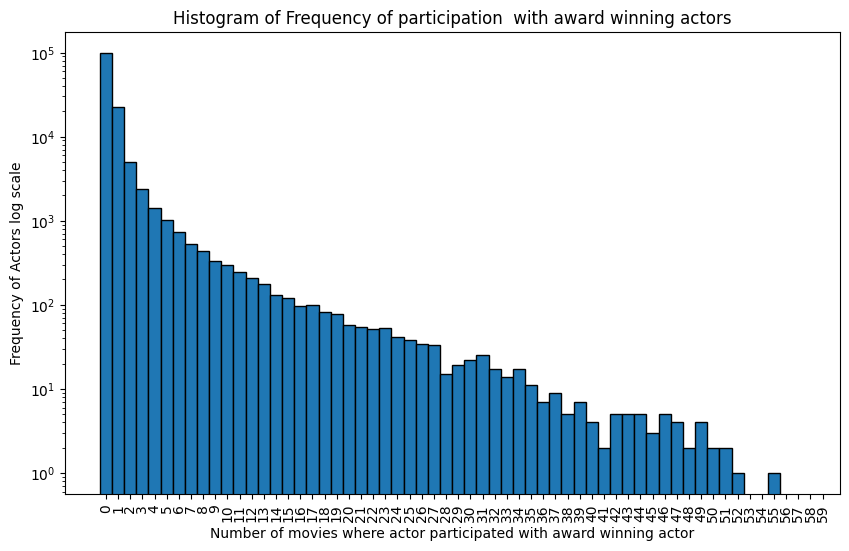

In [59]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 6))
plt.hist(actors_to_compare["movies_with_actor_won_count"], bins=range(0, actors_to_compare["movies_with_actor_won_count"].max() ), edgecolor='black', align='left', log= True)
plt.title("Histogram of Frequency of participation  with award winning actors")
plt.xlabel("Number of movies where actor participated with award winning actor")
plt.ylabel("Frequency of Actors log scale")
plt.xticks(range(0, actors_to_compare["movies_with_actor_won_count"].max() + 1), rotation = 90)


Next we divide our actors to two different types:
- Actors that never participated with award winning actors
- Actors that participated at least once with award winning actors

In [60]:
no_participation = actors_to_compare[actors_to_compare["movies_with_actor_won_count"] <= 0]

participation =  actors_to_compare[actors_to_compare["movies_with_actor_won_count"] >= 1]

In [61]:
print("Never participated length: ", str(len(no_participation)))
print("Participated length: ", str(len(participation)))

Never participated length:  98730
Participated length:  36226


The Number of actors that did not participate with award winning actors is 2.7 times larger than the number of actors that participated which seems reasonable

We have decided to rank the success of actors based on the box office revenue and popularity of the movies they have participated in. These success factors will serve as a starting point for the measures we will use in Milestone 3 to compare the success of different actors

In [62]:
# We store the movies available in the success_factors dataframe
success_factors = revenues_ratings_df[["freebase_id","boxOffice_revenue","popularity"]]

success_factors


,freebase_id,boxOffice_revenue,popularity
0,/m/03vyhn,14010832.0,13.057
1,/m/0crgdbh,NaN,0.600
2,/m/01mrr1,NaN,NaN
5,/m/04jcqvw,NaN,3.362
10,/m/02qc0j7,3600000.0,2.030
...,...,...,...
180857,/m/0gxz3td,NaN,0.600
180901,/m/09v944b,NaN,NaN
181004,/m/02z1_64,NaN,0.600
181038,/m/0421l_t,NaN,0.960


In [63]:
# Explode the freebase_id list in no_participation to create individual rows for each freebase_id
no_participation_exploded = no_participation.explode('freebase_id')

# We do this merge to add the popularity and boxOffice revenue columns 
joined_df = pd.merge(no_participation_exploded, success_factors, on='freebase_id', how='inner')

filtered_df = joined_df[joined_df[['boxOffice_revenue', 'popularity']].notna().all(axis=1)]

# Grouping by actor ID and calculating the average for boxOffice_revenue, popularity
average_stats_no_participation = filtered_df.groupby('Freebase actor ID').agg({
    'boxOffice_revenue': 'mean',
    'popularity': 'mean',
}).reset_index()

print(average_stats_no_participation)


      Freebase actor ID  boxOffice_revenue  popularity
0              /m/011_8         47735246.5     12.6755
1             /m/011vx3          6300000.0      5.4890
2             /m/011xl3         24217115.0     12.0280
3             /m/011xll         24217115.0     12.0280
4             /m/011zg9         27645491.0     14.7080
...                 ...                ...         ...
16852          /m/0qf3p          3942254.0     12.1430
16853          /m/0sw7b        527071022.0     70.5160
16854           /m/0x3n         68257935.0     22.2450
16855          /m/0x7ml         13784413.0      4.0705
16856          /m/0y8r3          6325313.0     10.0960

[16857 rows x 3 columns]


In [64]:
# Explode the freebase_id list in no_participation to create individual rows for each freebase_id
participation_exploded = participation.explode('freebase_id')

# We do this merge to add the popularity and boxOffice revenue columns 
joined_df = pd.merge(participation_exploded, success_factors, on='freebase_id', how='inner')

filtered_df = joined_df[joined_df[['boxOffice_revenue', 'popularity']].notna().all(axis=1)]

# Grouping by actor ID and calculating the average boxOffice_revenue
average_stats_participation = filtered_df.groupby('Freebase actor ID').agg({
    'boxOffice_revenue': 'mean',
    'popularity': 'mean',
}).reset_index()

print(average_stats_participation)


      Freebase actor ID  boxOffice_revenue  popularity
0              /m/010p3       2.441991e+07    9.306000
1             /m/010q36       2.879282e+08   41.572000
2             /m/0112yl       2.100104e+07   14.247857
3             /m/011_3s       3.635031e+07   14.561632
4             /m/011_c4       1.260000e+07    9.928000
...                 ...                ...         ...
23701          /m/0sx5w       4.123080e+07   10.705000
23702           /m/0tj9       1.510921e+07    7.780591
23703          /m/0y58x       6.081960e+07   17.926500
23704          /m/0z05l       1.182331e+08   19.797417
23705          /m/0zcb7       1.364197e+07    5.278500

[23706 rows x 3 columns]


In [65]:
average_stats_participation.describe()

,boxOffice_revenue,popularity
count,2.370600e+04,23706.000000
mean,6.349300e+07,16.734755
std,1.165820e+08,19.196280
min,1.000000e+00,0.600000
25%,5.773557e+06,8.495167
50%,2.549860e+07,12.531100
75%,7.206964e+07,18.867000
max,2.782275e+09,363.431000


In [66]:
average_stats_no_participation.describe()


,boxOffice_revenue,popularity
count,1.685700e+04,16857.000000
mean,2.444759e+07,12.563263
std,5.992573e+07,14.857906
min,1.000000e+00,0.600000
25%,8.186760e+05,5.036500
50%,5.086909e+06,8.883000
75%,1.970500e+07,14.747000
max,7.696795e+08,404.473000


From the results above, we can see that the average and median box office revenue and popularity are higher for actors who have participated in projects with award winners. This outcome is logical, as the increased exposure these actors received from collaborating with award-winning individuals may account for the observed differences

In [67]:
df_stats_no_participation = pd.DataFrame(average_stats_no_participation)
df_stats_participation_ = pd.DataFrame(average_stats_participation)

In [68]:
t_stat, p_val = stats.ttest_ind(df_stats_no_participation['boxOffice_revenue'], df_stats_participation_['boxOffice_revenue'], alternative='less', equal_var=False)
# We set equal_var to False because we do not assume that the variances of the two samples are equal
print("tstat =", t_stat)
print("The p-value for the one-sided test is %.03f." % p_val)
bool_val = p_val < 0.05

if bool_val:
    conclusion = "reject"
else:
    conclusion = "fail to reject"

print(f"Since the p-value is {p_val:.03f} and {'is' if bool_val else 'is not'} less than 0.05, we {conclusion} the null hypothesis that the mean of average revenue per actor not participating with award winner is greater than or equal to the average revenue per actor participating.")


tstat = -44.031002540985966
The p-value for the one-sided test is 0.000.
Since the p-value is 0.000 and is less than 0.05, we reject the null hypothesis that the mean of average revenue per actor not participating with award winner is greater than or equal to the average revenue per actor participating.


In [69]:
t_stat, p_val = stats.ttest_ind(df_stats_no_participation['popularity'], df_stats_participation_['popularity'], alternative='less', equal_var=False)
# We set equal_var to False because we do not assume that the variances of the two samples are equal
print("tstat =", t_stat)
print("The p-value for the one-sided test is %.03f." % p_val)
bool_val = p_val < 0.05
if bool_val:
    conclusion = "reject"
else:
    conclusion = "fail to reject"

print(f"Since the p-value is {p_val:.03f} and {'is' if bool_val else 'is not'} less than 0.05, we {conclusion} the null hypothesis that the mean of average popularity per actor not participating with award winner is greater than or equal to the average popularity per actor participating.")


tstat = -24.649165511436536
The p-value for the one-sided test is 0.000.
Since the p-value is 0.000 and is less than 0.05, we reject the null hypothesis that the mean of average popularity per actor not participating with award winner is greater than or equal to the average popularity per actor participating.


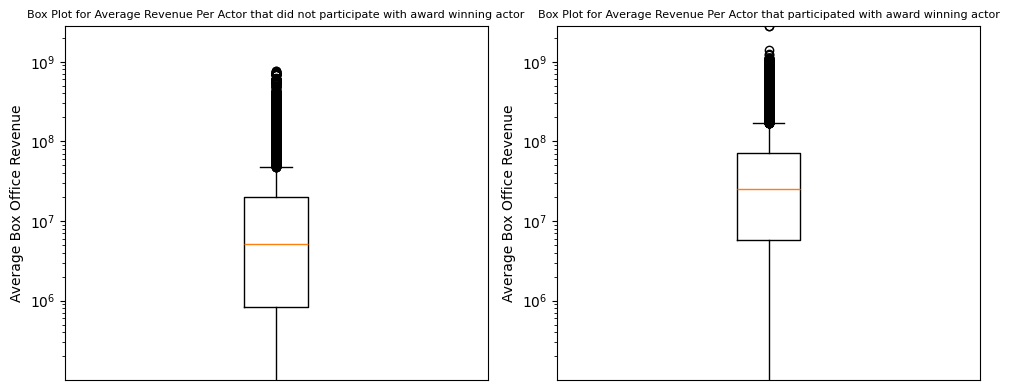

In [70]:
# Calculate the minimum and maximum values for the y-axis, considering only values > 10^5
# These were done for better visualisation
min_rev = max(10**5, df_stats_no_participation['boxOffice_revenue'][df_stats_no_participation['boxOffice_revenue'] > 10**5].min(), 
              df_stats_participation_['boxOffice_revenue'][df_stats_participation_['boxOffice_revenue'] > 10**5].min())
max_rev = max(df_stats_no_participation['boxOffice_revenue'].max(), df_stats_participation_['boxOffice_revenue'].max())

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.boxplot(df_stats_no_participation['boxOffice_revenue'])
plt.title('Box Plot for Average Revenue Per Actor that did not participate with award winning actor', fontsize=8)
plt.xticks([])  

plt.ylabel('Average Box Office Revenue')
plt.yscale('log')  # Applying logarithmic scale to y-axis
plt.ylim(min_rev, max_rev)  

plt.subplot(1, 2, 2)
plt.boxplot(df_stats_participation_['boxOffice_revenue'])
plt.title('Box Plot for Average Revenue Per Actor that participated with award winning actor', fontsize=8)
plt.ylabel('Average Box Office Revenue')
plt.yscale('log')  # Applying logarithmic scale to y-axis
plt.ylim(min_rev, max_rev)  

plt.xticks([])  


plt.tight_layout()
plt.show()


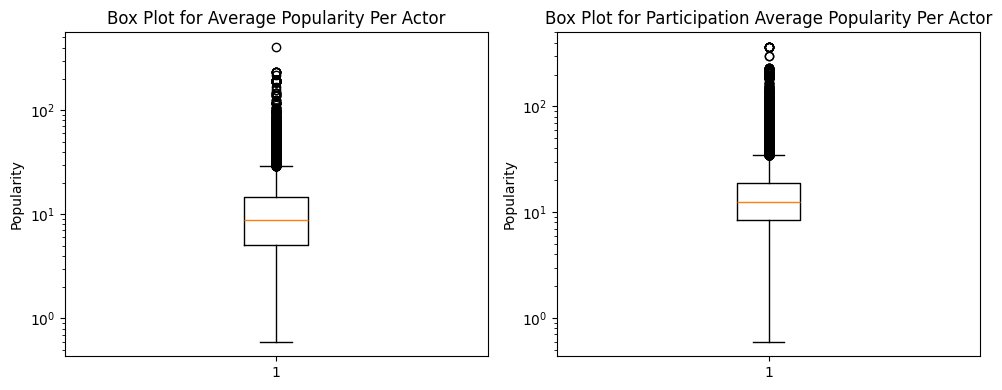

In [71]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.boxplot(df_stats_no_participation['popularity'])
plt.title('Box Plot for Average Popularity Per Actor')
plt.ylabel('Popularity')
plt.yscale('log') # Applying logarithmic scale to y-axis

plt.subplot(1, 2, 2)
plt.boxplot(df_stats_participation_['popularity'])
plt.title('Box Plot for Participation Average Popularity Per Actor')
plt.ylabel('Popularity')
plt.yscale('log')   # Applying logarithmic scale to y-axis

plt.tight_layout()
plt.show()


The t-tests and box plots confirm the results obtained previously when we analyzed the dataframes. Both the popularity and the box office revenues are statistically significantly higher for actors who have participated with award-winning actors. These results seem logical; collaborating with award-winning actors, who possess proven talents, likely increases the popularity of the movies. At the same time, these movies may also reach a broader audience, which could be a reason for the higher box office revenues

After all these results provide a starting point to answering the research questions treating the impact of co_starring with high-profile actors 



### Time series analysis ###

In [72]:
# Filter actors who won awards
actors_won = actor_nominees[actor_nominees["won"] > 0 ][["Freebase actor ID","freebase_id","years_won"]]
actors_won = actors_won.explode("years_won")
actors_won = actors_won.sort_values(by = ["Freebase actor ID","years_won"])
# Get the first year when the actor won the award
actors_won["First_Award_Year"] = actors_won.groupby('Freebase actor ID')['years_won'].transform('first')

actors_won = actors_won.drop_duplicates("Freebase actor ID")[["Freebase actor ID","freebase_id","First_Award_Year"]]

actors_won

,Freebase actor ID,freebase_id,First_Award_Year
354,/m/010xjr,"[/m/0c_6bf, /m/078mm1, /m/03qfyt, /m/0cz7_4w, ...",1968
1698,/m/011_nf,"[/m/03cbvzw, /m/026_y0f, /m/0c5vz, /m/0ggb04k,...",1929
1712,/m/01200d,"[/m/06w76wm, /m/06pkq3, /m/027__vq, /m/03grbqq...",1932
15,/m/01201_,"[/m/0kb6b, /m/05b3bsk, /m/03d2t_j, /m/0724jb, ...",1948
992,/m/0127m7,"[/m/04kkxx, /m/048j2s, /m/01k5_t, /m/031h9k, /...",1991
...,...,...,...
1090,/m/0sz28,"[/m/02rj2v7, /m/02qh42w, /m/02pzx0n, /m/03md68...",2004
606,/m/0tc7,"[/m/0kvds4, /m/07tr5g, /m/08ck1h, /m/053rxgm, ...",1977
695,/m/0ywqc,"[/m/0dcjzb, /m/02vxyq9, /m/0h1d4kn, /m/01vg4x,...",1996
637,/m/0z4s,"[/m/035bcl, /m/03mczbc, /m/07wzcn, /m/0cc7mcr,...",1992


In [73]:
# We will store actors who participated with award winning actors but did not win
participation = participation.drop_duplicates("Freebase actor ID")[["Freebase actor ID","freebase_id"]]

participation

,Freebase actor ID,freebase_id
0,/m/03wcfv7,"[/m/03vyhn, /m/0809s7n, /m/0dg7mt, /m/04t8wq, ..."
1,/m/0346l4,"[/m/03vyhn, /m/02854l1, /m/03_gr5, /m/06sbvgb,..."
2,/m/01vw26l,"[/m/03vyhn, /m/06x8g2, /m/083xgxs, /m/04f3j1r,..."
3,/m/034hyc,"[/m/03vyhn, /m/053rxgm, /m/03b_h1l, /m/01dvbd,..."
4,/m/01y9xg,"[/m/03vyhn, /m/026f_k5, /m/045j3w, /m/06v_2g, ..."
...,...,...
134900,/m/03j38w5,[/m/04_0sq]
134912,/m/05srl9m,[/m/02rtqvb]
134913,/m/05srlb5,[/m/02rtqvb]
134916,/m/0gcyfwt,[/m/0b6lqyd]


In [74]:

actors_won_exploded = actors_won.explode('freebase_id')
participation_exploded = participation.explode('freebase_id')
actors_won_exploded = actors_won_exploded.drop_duplicates()
participation_exploded = participation_exploded.drop_duplicates()

## We will merge the participation and actors_won df to keep only the movies for each participation 
merged_df = pd.merge(actors_won_exploded, participation_exploded, on='freebase_id', suffixes=('_won', '_part'))

# grouping participants to winners
grouped = merged_df.groupby(['Freebase actor ID_won', 'Freebase actor ID_part']).agg({'freebase_id': lambda x: list(set(x))}).reset_index()



We will now create a graph to link actors that participated with award winning actors, to these award winning actors

In [75]:
G = nx.Graph()

for index, row in grouped.iterrows():
    actor_id_won = row['Freebase actor ID_won']
    actor_id_part = row['Freebase actor ID_part']
    common_ids = row['freebase_id']

    G.add_node(actor_id_won, type='actor_won', name=actor_id_won)
    G.add_node(actor_id_part, type='participant', name= actor_id_part)

    G.add_edge(actor_id_won, actor_id_part, common_freebase_ids=common_ids)



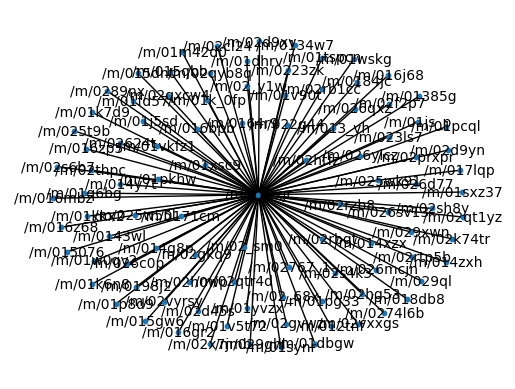

In [76]:
import networkx as nx
import matplotlib.pyplot as plt


# We will show a subgraph of the first 100 nodes.
nodes_subset = list(G.nodes())[:100]  
subgraph = G.subgraph(nodes_subset)

# Draw the subgraph
pos = nx.spring_layout(subgraph)  

# Nodes
nx.draw_networkx_nodes(subgraph, pos, node_size=10)

# Edges
nx.draw_networkx_edges(subgraph, pos, width=1)

# Labels
nx.draw_networkx_labels(subgraph, pos, font_size=10)

plt.axis('off')  
plt.show()  


In [77]:
## Merge grouped with award to get the First award year of each award winning actor per movie
grouped = pd.merge(grouped,actors_won[["Freebase actor ID","First_Award_Year"]],left_on="Freebase actor ID_won",right_on="Freebase actor ID",how = "left")
grouped

,Freebase actor ID_won,Freebase actor ID_part,freebase_id,Freebase actor ID,First_Award_Year
0,/m/010xjr,/m/012tnf,[/m/04ld76k],/m/010xjr,1968
1,/m/010xjr,/m/0134w7,"[/m/031778, /m/03176f]",/m/010xjr,1968
2,/m/010xjr,/m/01385g,"[/m/04ld76k, /m/03qfyt]",/m/010xjr,1968
3,/m/010xjr,/m/013_vh,"[/m/031778, /m/03176f]",/m/010xjr,1968
4,/m/010xjr,/m/0143wl,[/m/05h345],/m/010xjr,1968
...,...,...,...,...,...
151027,/m/0zcbl,/m/0nqls,[/m/02k21t],/m/0zcbl,2009
151028,/m/0zcbl,/m/0pyww,[/m/06lpmt],/m/0zcbl,2009
151029,/m/0zcbl,/m/0q9kd,[/m/0q9b0],/m/0zcbl,2009
151030,/m/0zcbl,/m/0sw5n,[/m/06lpmt],/m/0zcbl,2009


In [78]:
## now we will keep for each participating actor the movies that he participated with award winning actors, and extract the year of these movies
won_movies_df = pd.merge(grouped.explode("freebase_id"), movies_metadata_df[['freebase_id', 'year']], on='freebase_id', how='left')
won_movies_df = pd.DataFrame(won_movies_df[["Freebase actor ID_part","freebase_id","year","First_Award_Year"]])
won_movies_df = won_movies_df.drop_duplicates()## Same actor can participate with two actors that won the oscars in the same move
won_movies_df = won_movies_df.dropna(subset=['year'])## WE will drop movies with NAN years

won_movies_df

,Freebase actor ID_part,freebase_id,year,First_Award_Year
0,/m/012tnf,/m/04ld76k,1959.0,1968
1,/m/0134w7,/m/031778,2002.0,1968
2,/m/0134w7,/m/03176f,2001.0,1968
3,/m/01385g,/m/04ld76k,1959.0,1968
4,/m/01385g,/m/03qfyt,1965.0,1968
...,...,...,...,...
164754,/m/0nqls,/m/02k21t,2002.0,2009
164755,/m/0pyww,/m/06lpmt,1997.0,2009
164756,/m/0q9kd,/m/0q9b0,1999.0,2009
164757,/m/0sw5n,/m/06lpmt,1997.0,2009


In [79]:
# Keep only the movies where the award winning actor already won the award before the movie
won_movies_df = won_movies_df[won_movies_df['year'] >= won_movies_df['First_Award_Year']]

won_movies_df = won_movies_df.sort_values(by=['Freebase actor ID_part', 'year'])[["Freebase actor ID_part","freebase_id","year"]]

won_movies_df

,Freebase actor ID_part,freebase_id,year
122657,/m/010q36,/m/033pf1,1995.0
24186,/m/0112yl,/m/03vgzt,1966.0
41178,/m/0112yl,/m/03vgzt,1966.0
103879,/m/0112yl,/m/04g783,1968.0
65413,/m/0112yl,/m/07z5f4,1971.0
...,...,...,...
3560,/m/0z05l,/m/06lqd5,2002.0
7308,/m/0z05l,/m/06lqd5,2002.0
102515,/m/0z05l,/m/0bwl2s_,2010.0
36594,/m/0zcb7,/m/03b1xl,1990.0


In [80]:
# For each participating actor, we extract the earliest movie he participated in with award winning actor
earliest_movies_df = won_movies_df.groupby('Freebase actor ID_part').agg({'freebase_id': 'first',"year" : "first"}).reset_index()

earliest_movies_df

,Freebase actor ID_part,freebase_id,year
0,/m/010q36,/m/033pf1,1995.0
1,/m/0112yl,/m/03vgzt,1966.0
2,/m/011_3s,/m/0j_t1,1975.0
3,/m/011_c4,/m/0p7pw,1966.0
4,/m/011_pk,/m/0glww,1930.0
...,...,...,...
28250,/m/0tj9,/m/072hx4,2005.0
28251,/m/0y58x,/m/06h9xs,1995.0
28252,/m/0yfp,/m/021gzd,1990.0
28253,/m/0z05l,/m/05ft9h,1985.0


In [81]:
# We now go back to all the participants' movies, including movies not featuring award winninng actors, the goal is to group movies
# before and after participating with award winning actors
participation_dates_exploded = pd.merge(participation_exploded, movies_metadata_df[['freebase_id', 'year']], on='freebase_id', how='left')

participation_dates_exploded

,Freebase actor ID,freebase_id,year
0,/m/03wcfv7,/m/03vyhn,2001.0
1,/m/03wcfv7,/m/0809s7n,2009.0
2,/m/03wcfv7,/m/0dg7mt,2001.0
3,/m/03wcfv7,/m/04t8wq,1990.0
4,/m/03wcfv7,/m/03gt21w,1990.0
...,...,...,...
232676,/m/03j38w5,/m/04_0sq,2003.0
232677,/m/05srl9m,/m/02rtqvb,1996.0
232678,/m/05srlb5,/m/02rtqvb,1996.0
232679,/m/0gcyfwt,/m/0b6lqyd,2011.0


In [82]:
participation_dates_exploded = participation_dates_exploded[["Freebase actor ID","freebase_id","year"]]
participation_dates_exploded = participation_dates_exploded.dropna(subset=['year'])## WE will drop movies with NAN years 


participation_dates_exploded

,Freebase actor ID,freebase_id,year
0,/m/03wcfv7,/m/03vyhn,2001.0
1,/m/03wcfv7,/m/0809s7n,2009.0
2,/m/03wcfv7,/m/0dg7mt,2001.0
3,/m/03wcfv7,/m/04t8wq,1990.0
4,/m/03wcfv7,/m/03gt21w,1990.0
...,...,...,...
232676,/m/03j38w5,/m/04_0sq,2003.0
232677,/m/05srl9m,/m/02rtqvb,1996.0
232678,/m/05srlb5,/m/02rtqvb,1996.0
232679,/m/0gcyfwt,/m/0b6lqyd,2011.0


In [83]:
sorted_participation_df = participation_dates_exploded.sort_values(by=['Freebase actor ID', 'year'])

sorted_participation_df

,Freebase actor ID,freebase_id,year
146253,/m/010p3,/m/06c5z_,1998.0
146254,/m/010p3,/m/0b6jfrc,1999.0
146250,/m/010p3,/m/0bq2wj,2000.0
146251,/m/010p3,/m/08hjr9,2000.0
146256,/m/010p3,/m/051wrdv,2000.0
...,...,...,...
180697,/m/0zcb7,/m/09v460,1991.0
180696,/m/0zcb7,/m/080kkcx,1999.0
180698,/m/0zcb7,/m/02drs7,2001.0
180701,/m/0zcb7,/m/047fs6w,2008.0


In [84]:
# Merge sorted_participation_df with earliest_movies_df to get the year of the first participation with award winning actors
merged_df = pd.merge(sorted_participation_df, earliest_movies_df, left_on='Freebase actor ID',right_on='Freebase actor ID_part', suffixes=('', '_earliest'))

merged_df

,Freebase actor ID,freebase_id,year,Freebase actor ID_part,freebase_id_earliest,year_earliest
0,/m/010q36,/m/033pf1,1995.0,/m/010q36,/m/033pf1,1995.0
1,/m/0112yl,/m/03jzwk,1948.0,/m/0112yl,/m/03vgzt,1966.0
2,/m/0112yl,/m/03jzs6,1949.0,/m/0112yl,/m/03vgzt,1966.0
3,/m/0112yl,/m/04_m45,1949.0,/m/0112yl,/m/03vgzt,1966.0
4,/m/0112yl,/m/07mlgp,1950.0,/m/0112yl,/m/03vgzt,1966.0
...,...,...,...,...,...,...
201562,/m/0zcb7,/m/09v460,1991.0,/m/0zcb7,/m/03b1xl,1990.0
201563,/m/0zcb7,/m/080kkcx,1999.0,/m/0zcb7,/m/03b1xl,1990.0
201564,/m/0zcb7,/m/02drs7,2001.0,/m/0zcb7,/m/03b1xl,1990.0
201565,/m/0zcb7,/m/047fs6w,2008.0,/m/0zcb7,/m/03b1xl,1990.0


In [85]:
import pandas as pd


# Use groupby and transform to find the earliest year for each actor
earliest_year = merged_df.groupby('Freebase actor ID')['year_earliest'].transform('first')

# Set 'period' to 'before' if the movie's year is before the earliest year, otherwise 'after'
merged_df['period'] = np.where(merged_df['year'] < earliest_year, 'before', 'after')

# Now you can split the movies for each participant two separate DataFrames
before_df = merged_df[merged_df['period'] == 'before']
after_df = merged_df[merged_df['period'] == 'after']


In [86]:

# We do this merge to add the popularity and boxOffice revenue columns 
bef_joined_df = pd.merge(before_df, success_factors, on='freebase_id', how='inner')

bef_filtered_df = bef_joined_df[bef_joined_df[['boxOffice_revenue', 'popularity']].notna().all(axis=1)]

# Grouping by actor ID and calculating the average for boxOffice_revenue, popularity
bef_average_stats = bef_filtered_df.groupby('Freebase actor ID').agg({
    'boxOffice_revenue': 'mean',
    'popularity': 'mean',
}).reset_index()

print(bef_average_stats)


     Freebase actor ID  boxOffice_revenue  popularity
0            /m/0112yl       1.520967e+05   19.737000
1            /m/011xjd       7.530000e+05    3.779000
2            /m/012801       1.830973e+08   15.821000
3            /m/012_53       2.409921e+07   12.731500
4            /m/012cj0       3.000000e+06   10.994500
...                ...                ...         ...
5291          /m/0qdgc       4.524279e+07   14.467400
5292          /m/0svqs       6.138968e+07   39.733000
5293          /m/0sw6y       4.493017e+06   34.037000
5294           /m/0tj9       8.346670e+06    8.889143
5295          /m/0y58x       1.930636e+07   12.883000

[5296 rows x 3 columns]


In [87]:
after_joined_df = pd.merge(after_df, success_factors, on='freebase_id', how='inner')

after_filtered_df = after_joined_df[after_joined_df[['boxOffice_revenue', 'popularity']].notna().all(axis=1)]

after_average_stats = after_filtered_df.groupby('Freebase actor ID').agg({
    'boxOffice_revenue': 'mean',
    'popularity': 'mean',
}).reset_index()

print(after_average_stats)

      Freebase actor ID  boxOffice_revenue  popularity
0             /m/010q36       2.879282e+08   41.572000
1             /m/0112yl       3.663775e+07   10.131000
2             /m/011_3s       3.846211e+07   15.162529
3             /m/011_c4       1.260000e+07    9.928000
4             /m/011_pk       5.885000e+05    1.934000
...                 ...                ...         ...
19082          /m/0sw6y       1.477521e+08   25.903000
19083           /m/0tj9       1.956948e+07    7.316143
19084          /m/0y58x       6.675006e+07   18.647000
19085          /m/0z05l       1.182331e+08   19.797417
19086          /m/0zcb7       1.364197e+07    5.278500

[19087 rows x 3 columns]


In [88]:
bef_average_stats.describe()

,boxOffice_revenue,popularity
count,5.296000e+03,5296.000000
mean,3.587304e+07,13.601764
std,6.868265e+07,12.932236
min,1.000000e+00,0.600000
25%,2.349363e+06,6.466000
50%,1.129561e+07,10.546000
75%,3.706161e+07,16.500750
max,7.929106e+08,207.130000


In [89]:
after_average_stats.describe()

,boxOffice_revenue,popularity
count,1.908700e+04,19087.000000
mean,7.277233e+07,17.782237
std,1.300767e+08,20.841141
min,1.000000e+00,0.600000
25%,7.446795e+06,8.937167
50%,3.099166e+07,13.059000
75%,8.143651e+07,19.713167
max,2.782275e+09,363.431000


In [90]:
t_stat, p_val = stats.ttest_ind(bef_average_stats['boxOffice_revenue'], after_average_stats['boxOffice_revenue'], alternative='less', equal_var=False)
# We set equal_var to False because we do not assume that the variances of the two samples are equal
print("tstat =", t_stat)
print("The p-value for the one-sided test is %.03f." % p_val)
bool_val = p_val < 0.05

if bool_val:
    conclusion = "reject"
else:
    conclusion = "fail to reject"

print(f"Since the p-value is {p_val:.03f} and {'is' if bool_val else 'is not'} less than 0.05, we {conclusion} the null hypothesis that the mean of average revenue per actor before participating with award winner is greater than or equal to the average revenue per actor after participating.")


tstat = -27.679010980078846
The p-value for the one-sided test is 0.000.
Since the p-value is 0.000 and is less than 0.05, we reject the null hypothesis that the mean of average revenue per actor before participating with award winner is greater than or equal to the average revenue per actor after participating.


In [91]:
t_stat, p_val = stats.ttest_ind(bef_average_stats['popularity'], after_average_stats['popularity'], alternative='less', equal_var=False)
# We set equal_var to False because we do not assume that the variances of the two samples are equal
print("tstat =", t_stat)
print("The p-value for the one-sided test is %.03f." % p_val)
bool_val = p_val < 0.05
if bool_val:
    conclusion = "reject"
else:
    conclusion = "fail to reject"

print(f"Since the p-value is {p_val:.03f} and {'is' if bool_val else 'is not'} less than 0.05, we {conclusion} the null hypothesis that the mean of average popularity per actor before participating with award winner is greater than or equal to the average popularity per actor after participating.")


tstat = -17.93425953301508
The p-value for the one-sided test is 0.000.
Since the p-value is 0.000 and is less than 0.05, we reject the null hypothesis that the mean of average popularity per actor before participating with award winner is greater than or equal to the average popularity per actor after participating.


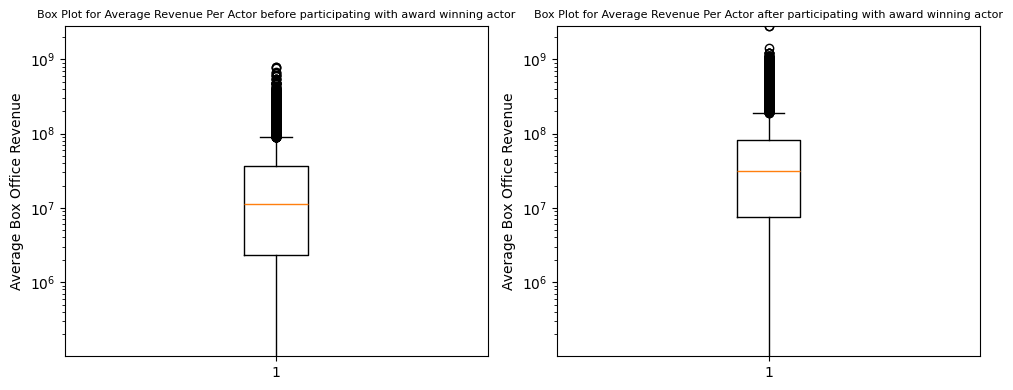

In [92]:
# Calculate the minimum and maximum values for the y-axis, considering only values > 10^5
# These were done for better visualisation
min_rev = max(10**5, bef_average_stats['boxOffice_revenue'][bef_average_stats['boxOffice_revenue'] > 10**5].min(), 
              after_average_stats['boxOffice_revenue'][after_average_stats['boxOffice_revenue'] > 10**5].min())
max_rev = max(bef_average_stats['boxOffice_revenue'].max(), after_average_stats['boxOffice_revenue'].max())

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.boxplot(bef_average_stats['boxOffice_revenue'])
plt.title('Box Plot for Average Revenue Per Actor before participating with award winning actor', fontsize=8)

plt.ylabel('Average Box Office Revenue')
plt.yscale('log')  # Applying logarithmic scale to y-axis
plt.ylim(min_rev, max_rev)  

plt.subplot(1, 2, 2)
plt.boxplot(after_average_stats['boxOffice_revenue'])
plt.title('Box Plot for Average Revenue Per Actor after participating with award winning actor', fontsize=8)
plt.ylabel('Average Box Office Revenue')
plt.yscale('log')  # Applying logarithmic scale to y-axis
plt.ylim(min_rev, max_rev)  



plt.tight_layout()
plt.show()


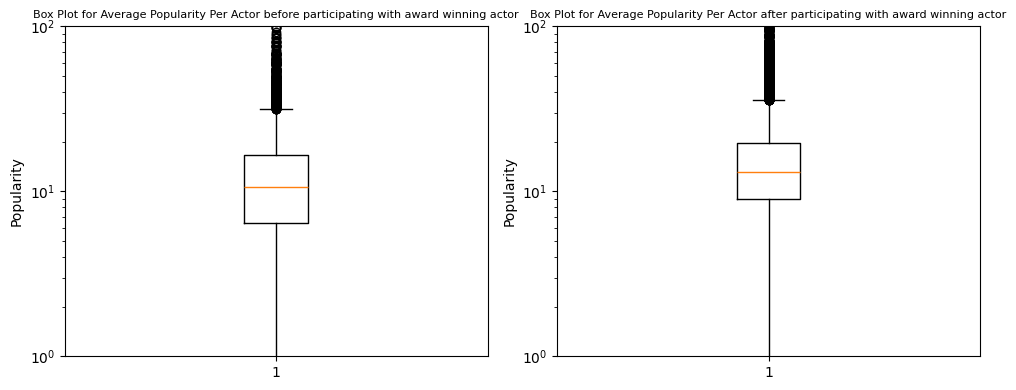

In [93]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.boxplot(bef_average_stats['popularity'])
plt.title('Box Plot for Average Popularity Per Actor before participating with award winning actor', fontsize=8)
plt.ylabel('Popularity')
plt.yscale('log')  # Applying logarithmic scale to y-axis
plt.ylim(1, 100)  

plt.subplot(1, 2, 2)
plt.boxplot(after_average_stats['popularity'])
plt.title('Box Plot for Average Popularity Per Actor after participating with award winning actor', fontsize=8)
plt.ylabel('Popularity')
plt.yscale('log')  # Applying logarithmic scale to y-axis
plt.ylim(1, 100)  

plt.tight_layout()
plt.show()


As we can observe from the results, the average popularity and revenue for actors who have worked with award-winning actors show a statistically significant increase after their collaboration. This trend clearly indicates the positive impact of participating in projects with award-winning actors on the careers of other actors.

### We will now try to check the number of beneficial collaborations of award winning actors, before winning an award ###


In [94]:
actors_won_year = actors_won[["Freebase actor ID","First_Award_Year"]]

In [95]:
## we will map collaborations of award winning actors
actor_pairs = pd.DataFrame(list(combinations(actors_won['Freebase actor ID'], 2)), columns=['Actor1', 'Actor2'])

actor_pairs['Common Movies'] = calculate_common_movies(actor_pairs, actors_won)

# Filter out pairs with no common movies
actor_pairs = actor_pairs[actor_pairs['Common Movies'].str.len() > 0]


In [96]:
# Merge to get the first award year for Actor1
actor_pairs_merge = actor_pairs.merge(actors_won_year, left_on='Actor1', right_on='Freebase actor ID')

# Merge again to get the first award year for Actor2
actor_pairs_merge = actor_pairs_merge.merge(actors_won_year, left_on='Actor2', right_on='Freebase actor ID', suffixes=('_1', '_2'))
actor_pairs_merge = actor_pairs_merge[["Actor1", "Actor2","Common Movies","First_Award_Year_1","First_Award_Year_2"]]

actor_pairs_merge

,Actor1,Actor2,Common Movies,First_Award_Year_1,First_Award_Year_2
0,/m/010xjr,/m/012jbv,[/m/04ld76k],1968,1945
1,/m/010xjr,/m/01337_,[/m/07lvhj],1968,1999
2,/m/010xjr,/m/015c4g,[/m/0kvfby],1968,1980
3,/m/0127m7,/m/015c4g,[/m/04lyrw],1991,1980
4,/m/012v9y,/m/015c4g,[/m/04j13sx],1954,1980
...,...,...,...,...,...
7849,/m/01ycbq,/m/05jcn8,[/m/02rn00y],2012,2010
7850,/m/02_01w,/m/09jhbn,[/m/03d1ypf],1962,1955
7851,/m/02_fj,/m/02wz8rb,[/m/09bh9_],1946,1964
7852,/m/02lyx4,/m/02wz8rb,[/m/09bh9_],1960,1964


In [97]:
actor_pairs_merge = actor_pairs_merge.explode("Common Movies")
# Merge to get the year of their collaboration in the movie
actor_pairs_merge = pd.merge(actor_pairs_merge, movies_metadata_df[['freebase_id', 'year']], left_on='Common Movies',right_on="freebase_id", how='left')
actor_pairs_merge


,Actor1,Actor2,Common Movies,First_Award_Year_1,First_Award_Year_2,freebase_id,year
0,/m/010xjr,/m/012jbv,/m/04ld76k,1968,1945,/m/04ld76k,1959.0
1,/m/010xjr,/m/01337_,/m/07lvhj,1968,1999,/m/07lvhj,1965.0
2,/m/010xjr,/m/015c4g,/m/0kvfby,1968,1980,/m/0kvfby,1993.0
3,/m/0127m7,/m/015c4g,/m/04lyrw,1991,1980,/m/04lyrw,2003.0
4,/m/012v9y,/m/015c4g,/m/04j13sx,1954,1980,/m/04j13sx,1976.0
...,...,...,...,...,...,...,...
9531,/m/01ycbq,/m/05jcn8,/m/02rn00y,2012,2010,/m/02rn00y,2009.0
9532,/m/02_01w,/m/09jhbn,/m/03d1ypf,1962,1955,/m/03d1ypf,1957.0
9533,/m/02_fj,/m/02wz8rb,/m/09bh9_,1946,1964,/m/09bh9_,1966.0
9534,/m/02lyx4,/m/02wz8rb,/m/09bh9_,1960,1964,/m/09bh9_,1966.0


We define a beneficial participation  when actor 1 participates with award winning actor 2, before actor 1 winning his award and vice versa

In [98]:
import pandas as pd

actor_pairs_merge['benefited'] = actor_pairs_merge.apply(
    lambda row: 1 if (row['First_Award_Year_1'] > row['First_Award_Year_2'] 
                      and row['First_Award_Year_2'] < row['year'] 
                      and row['First_Award_Year_1'] > row['year']) or  (row['First_Award_Year_2'] > row['First_Award_Year_1'] 
                      and row['First_Award_Year_1'] < row['year'] 
                      and row['First_Award_Year_2'] > row['year']) 
                  else 0, 
    axis=1
)
actor_pairs_merge

,Actor1,Actor2,Common Movies,First_Award_Year_1,First_Award_Year_2,freebase_id,year,benefited
0,/m/010xjr,/m/012jbv,/m/04ld76k,1968,1945,/m/04ld76k,1959.0,1
1,/m/010xjr,/m/01337_,/m/07lvhj,1968,1999,/m/07lvhj,1965.0,0
2,/m/010xjr,/m/015c4g,/m/0kvfby,1968,1980,/m/0kvfby,1993.0,0
3,/m/0127m7,/m/015c4g,/m/04lyrw,1991,1980,/m/04lyrw,2003.0,0
4,/m/012v9y,/m/015c4g,/m/04j13sx,1954,1980,/m/04j13sx,1976.0,1
...,...,...,...,...,...,...,...,...
9531,/m/01ycbq,/m/05jcn8,/m/02rn00y,2012,2010,/m/02rn00y,2009.0,0
9532,/m/02_01w,/m/09jhbn,/m/03d1ypf,1962,1955,/m/03d1ypf,1957.0,1
9533,/m/02_fj,/m/02wz8rb,/m/09bh9_,1946,1964,/m/09bh9_,1966.0,0
9534,/m/02lyx4,/m/02wz8rb,/m/09bh9_,1960,1964,/m/09bh9_,1966.0,0


In [99]:
actor_2 = actor_pairs_merge.groupby('Actor2')['benefited'].sum().reset_index()
actor_2 = actor_2.rename(columns={"Actor2" : "Actor"})
actor_2

,Actor,benefited
0,/m/01200d,0
1,/m/012j9q,0
2,/m/012jb3,0
3,/m/012jbv,1
4,/m/012v9y,1
...,...,...
440,/m/0sz28,24
441,/m/0tc7,9
442,/m/0ywqc,57
443,/m/0z4s,41


In [100]:
## We will groupby actor 1 and see the number of beneficial collaborations per actor
actor_1 = actor_pairs_merge.groupby('Actor1')['benefited'].sum().reset_index()
actor_1 = actor_1.rename(columns={"Actor1" : "Actor"})

grouped_df = pd.concat([actor_1,actor_2],axis = 0)
grouped_df = grouped_df.groupby('Actor')['benefited'].sum().reset_index()

grouped_df

,Actor,benefited
0,/m/010xjr,22
1,/m/011_nf,8
2,/m/01200d,16
3,/m/01201_,6
4,/m/0127m7,8
...,...,...
458,/m/0sz28,24
459,/m/0tc7,9
460,/m/0ywqc,57
461,/m/0z4s,41


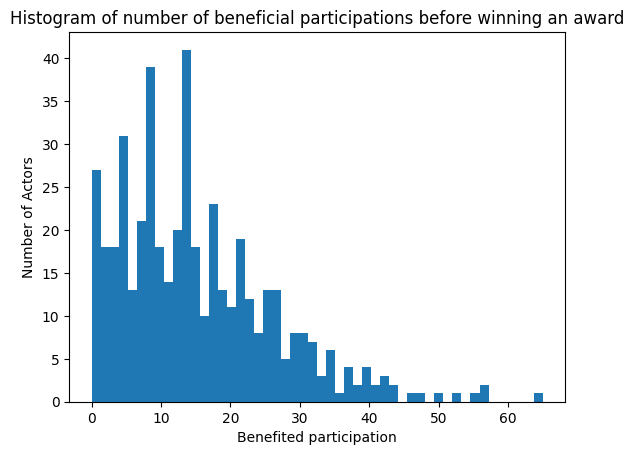

In [101]:
plt.hist(grouped_df['benefited'], bins=50)  
plt.xlabel('Benefited participation')
plt.ylabel('Number of Actors')
plt.title('Histogram of number of beneficial participations before winning an award')
plt.show()

Observations indicate that over 65% of award-winning actors have previously benefited from collaborating with an award-winning colleague, suggesting that such partnerships may positively influence an actor's career trajectory.

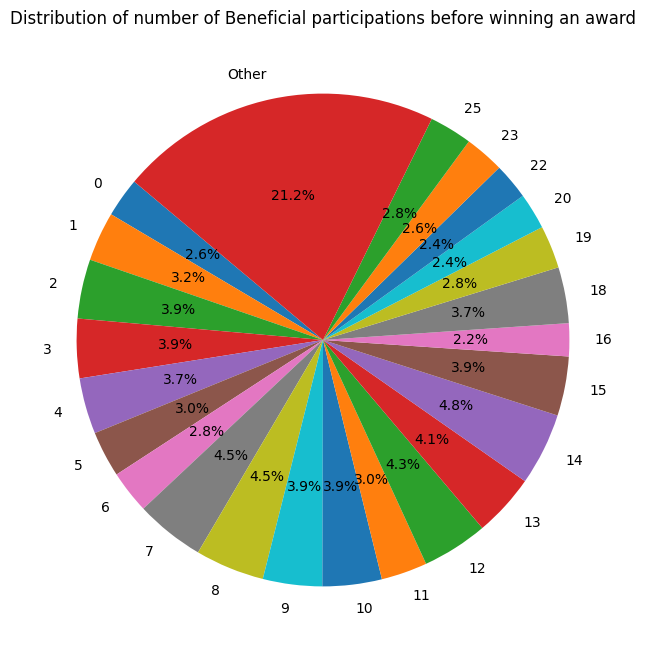

In [102]:
import pandas as pd
import matplotlib.pyplot as plt


threshold = 10

benefited_counts = grouped_df['benefited'].value_counts()

# Group values smaller than the threshold into 'Other'
small_values = benefited_counts[benefited_counts < threshold].sum()
benefited_counts = benefited_counts[benefited_counts >= threshold]

# Sort the counts and add 'Other' as the last item
sorted_counts = benefited_counts.sort_index()
sorted_counts['Other'] = small_values

# Plot pie chart
plt.figure(figsize=(8, 8))
plt.pie(sorted_counts, labels=sorted_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of number of Beneficial participations before winning an award')
plt.show()


We can see that only 2.6% of the award winnig actors did not previously participate in a beneficial collaboration, which is a clear indicative of the positive effects of collaborating with an award winning actor

### Spotlight to Stardom: The Ripple Effect of Awards on Actors' Careers

In [103]:
# Sort the DataFrame by 'FreebaseActorID' and 'year_ceremony'
actor_awards_sorted = actor_awards.sort_values(by=['Freebase actor ID', 'year_ceremony'])

# Now apply groupby and first
first_awards = actor_awards_sorted.groupby('Freebase actor ID').first().reset_index()
first_awards

,Freebase actor ID,year_film,year_ceremony,ceremony,category,name,film,winner,Actor date of birth,Actor gender,Actor ethnicity,Actor name,Actor birth year,title,freebase_id,won,nominations,years_won
0,/m/010xjr,1963,1964,36,ACTOR,Richard Harris,This Sporting Life,False,1930-10-01,M,/m/03bkbh,Richard Harris,1930.0,This Sporting Life,"[/m/0c_6bf, /m/078mm1, /m/03qfyt, /m/0cz7_4w, ...",1,2,[1968]
1,/m/011_3s,1975,1976,33,Best Performance by an Actress in a Supporting...,Lily Tomlin,Nashville,False,1939-09-01,F,None,Lily Tomlin,1939.0,Nashville,"[/m/0mdlf, /m/0615_9, /m/027qjyd, /m/027qjyd, ...",0,4,[]
2,/m/011_c4,1966,1967,39,ACTRESS IN A SUPPORTING ROLE,Vivien Merchant,Alfie,False,1929-07-22,F,None,Vivien Merchant,1929.0,Alfie,"[/m/05bzsr6, /m/0281z4, /m/02pp0b5, /m/0p7pw, ...",0,1,[]
3,/m/011_nf,1928,1929,2,ACTOR,Warner Baxter,In Old Arizona,True,1889-03-29,M,None,Warner Baxter,1889.0,In Old Arizona,"[/m/03cbvzw, /m/026_y0f, /m/0c5vz, /m/0ggb04k,...",1,1,[1929]
4,/m/011_pk,1928,1929,2,ACTOR,Chester Morris,Alibi,False,1901-02-16,M,None,Chester Morris,1901.0,Alibi,"[/m/0b4bp1l, /m/04crf3k, /m/09gg05s, /m/09gj2h...",0,1,[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1209,/m/0sz28,1993,1994,51,Best Performance by an Actor in a Supporting R...,Sean Penn,Carlito's Way,False,1960-08-17,M,/m/041rx,Sean Penn,1960.0,Carlito's Way,"[/m/02rj2v7, /m/02qh42w, /m/02pzx0n, /m/03md68...",3,10,"[2004, 2004, 2009]"
1210,/m/0tc7,1976,1977,34,New Star Of The Year - Actor,Arnold Schwarzenegger,Stay Hungry,True,1947-07-30,M,/m/019lrz,Arnold Schwarzenegger,1947.0,Stay Hungry,"[/m/0kvds4, /m/07tr5g, /m/08ck1h, /m/053rxgm, ...",1,2,[1977]
1211,/m/0ywqc,1980,1981,38,Best Performance by an Actor in a Motion Pictu...,Donald Sutherland,Ordinary People,False,1935-07-17,M,/m/07bch9,Donald Sutherland,1935.0,Ordinary People,"[/m/0dcjzb, /m/02vxyq9, /m/0h1d4kn, /m/01vg4x,...",2,5,"[1996, 2003]"
1212,/m/0z4s,1978,1979,36,Best Performance by an Actor in a Motion Pictu...,Anthony Hopkins,Magic,False,1937-12-31,M,/m/02g7sp,Anthony Hopkins,1937.0,Magic,"[/m/035bcl, /m/03mczbc, /m/07wzcn, /m/0cc7mcr,...",1,8,[1992]


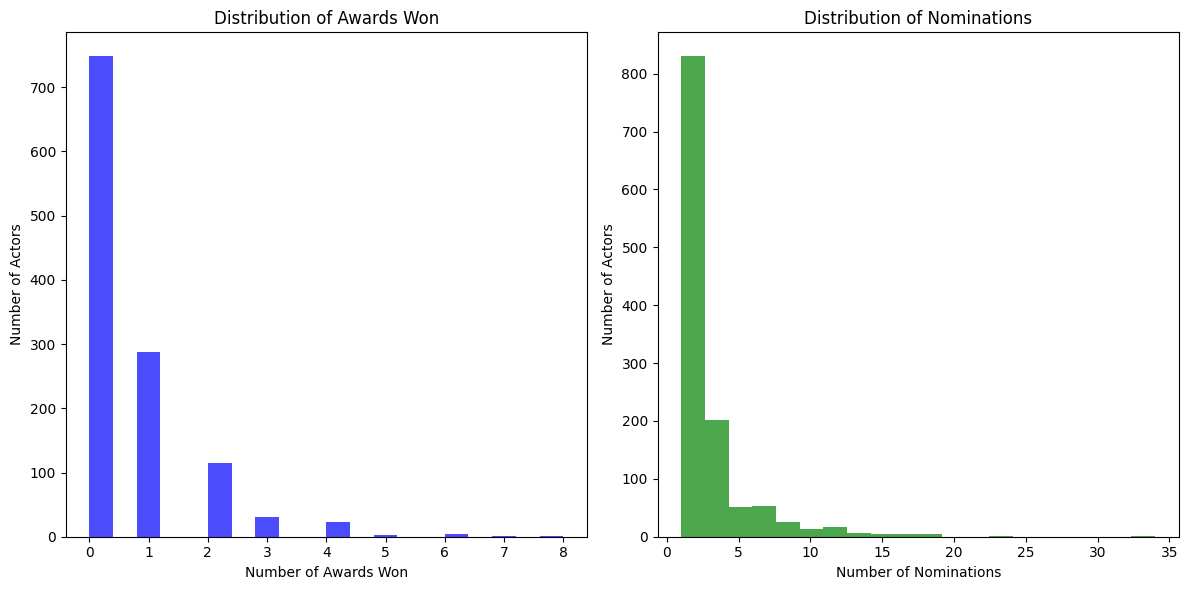

In [104]:
# Set up the figure with two subplots
plt.figure(figsize=(12, 6))

# Histogram for awards won
plt.subplot(1, 2, 1)
plt.hist(first_awards['won'], bins=20, color='blue', alpha=0.7)
plt.title('Distribution of Awards Won')
plt.xlabel('Number of Awards Won')
plt.ylabel('Number of Actors')

# Histogram for nominations
plt.subplot(1, 2, 2)
plt.hist(first_awards['nominations'], bins=20, color='green', alpha=0.7)
plt.title('Distribution of Nominations')
plt.xlabel('Number of Nominations')
plt.ylabel('Number of Actors')

# Show the plot
plt.tight_layout()
plt.show()

In [105]:
characters_metadata_df

,Wikipedia movie ID,Freebase movie ID,Movie release date,Character name,Actor date of birth,Actor gender,Actor ethnicity,Actor name,Actor age at movie release,Freebase actor ID,Actor birth year
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26 00:00:00+00:00,F,NaN,Wanda De Jesus,42.0,/m/03wcfv7,1958.0
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15 00:00:00+00:00,F,/m/044038p,Natasha Henstridge,27.0,/m/0346l4,1974.0
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15 00:00:00+00:00,M,/m/0x67,Ice Cube,32.0,/m/01vw26l,1969.0
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12 00:00:00+00:00,M,NaN,Jason Statham,33.0,/m/034hyc,1967.0
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25 00:00:00+00:00,F,NaN,Clea DuVall,23.0,/m/01y9xg,1977.0
...,...,...,...,...,...,...,...,...,...,...,...
450664,913762,/m/03pcrp,1992-05-21,Elensh,NaT,F,NaN,Dorothy Elias-Fahn,NaN,/m/0b_vcv,NaN
450665,913762,/m/03pcrp,1992-05-21,Hibiki,1965-04-12 00:00:00+00:00,M,NaN,Jonathan Fahn,27.0,/m/0bx7_j,1965.0
450666,28308153,/m/0cp05t9,1957,NaN,1941-11-18 00:00:00+00:00,M,/m/02w7gg,David Hemmings,15.0,/m/022g44,1941.0
450667,28308153,/m/0cp05t9,1957,NaN,NaT,NaN,NaN,Roberta Paterson,NaN,/m/0g8ngmm,NaN


In [106]:
movies_characters_df = revenues_ratings_df.merge(characters_metadata_df,left_on='freebase_id',right_on='Freebase movie ID',how='inner')

In [107]:
movies_characters_df = movies_characters_df.merge(first_awards[["Freebase actor ID", "won", "nominations", "year_ceremony", "film"]],on='Freebase actor ID', how='left')
movies_characters_df["won"].fillna(0, inplace=True)
movies_characters_df["nominations"].fillna(0, inplace=True)


In [108]:
before_award_df = movies_characters_df[movies_characters_df['year'] < movies_characters_df['year_ceremony']]


In [109]:
after_award_df = movies_characters_df[movies_characters_df['year'] > movies_characters_df['year_ceremony']]


**Award Influence Analysis**

Analyzing movie metrics before and after an actor wins an award can reveal insights into the award's influence on their career and the success of the films they participate in. 

**Observations**:

1. **Revenue Increase Post Award**: The first below plot indicates a potential increase in box office revenue following an award win. This suggests that awards can enhance an actor's marketability and the financial performance of their films.

2. **Increased Voter Participation**: The second plot shows more people participating in voting for the movie rating on IMDb following an award win, indicating heightened audience engagement.

3. **Change in Rating Quality**: Despite the increased voter participation, the third plot indicates a decrease in average ratings post-award. This could imply higher audience expectations and standards for movies featuring award-winning actors, leading to more critical assessments.

4. **Popularity Surge**: The fourth plot highlights an increase in the popularity score after an award win, aligning with the notion that awards boost an actor's public visibility and appeal.

**Forward Look**:

While these observations are intriguing, they necessitate further statistical analysis to establish a causal relationship. In the upcoming milestone 3, we will delve deeper into statistical tests to confirm these findings. This initial analysis lays the groundwork for understanding the impact of awards on an actor's professional success and their films' performance.


In [110]:
# Compute the mean vote average and box office revenue for actors before and after awards
after_means = after_award_df.groupby('Freebase actor ID')[['vote_average', 'boxOffice_revenue','vote_count','popularity']].mean()
before_means = before_award_df.groupby('Freebase actor ID')[['vote_average', 'boxOffice_revenue','vote_count','popularity']].mean()

In [111]:
before_means['popularity'].mean()

8.868313681817346

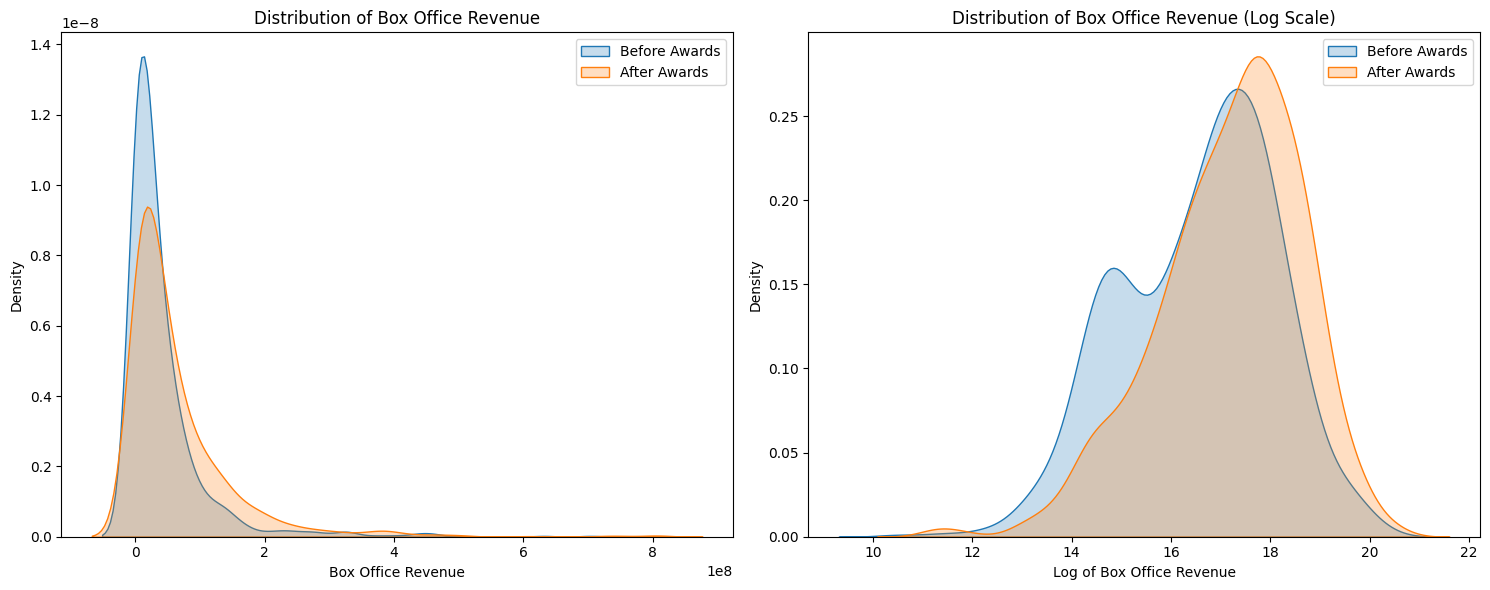

In [112]:
# Apply log transformation to box office revenue to handle wide range of values
after_means['log_boxOffice_revenue'] = np.log(after_means['boxOffice_revenue'] + 1) # Adding 1 to avoid log(0)
before_means['log_boxOffice_revenue'] = np.log(before_means['boxOffice_revenue'] + 1)

# Create a figure with two subplots
plt.figure(figsize=(15, 6))

# Plot distribution of vote averages before and after awards
# Plot distribution of box office revenue before and after awards
plt.subplot(1, 2, 1)
sns.kdeplot(before_means['boxOffice_revenue'], label='Before Awards', shade=True)
sns.kdeplot(after_means['boxOffice_revenue'], label='After Awards', shade=True)
plt.title('Distribution of Box Office Revenue')
plt.xlabel('Box Office Revenue')
plt.ylabel('Density')
plt.legend()

# Plot distribution of log-transformed box office revenue before and after awards
plt.subplot(1, 2, 2)
sns.kdeplot(before_means['log_boxOffice_revenue'], label='Before Awards', shade=True)
sns.kdeplot(after_means['log_boxOffice_revenue'], label='After Awards', shade=True)
plt.title('Distribution of Box Office Revenue (Log Scale)')
plt.xlabel('Log of Box Office Revenue')
plt.ylabel('Density')
plt.legend()

# Display the plots
plt.tight_layout()
plt.show()


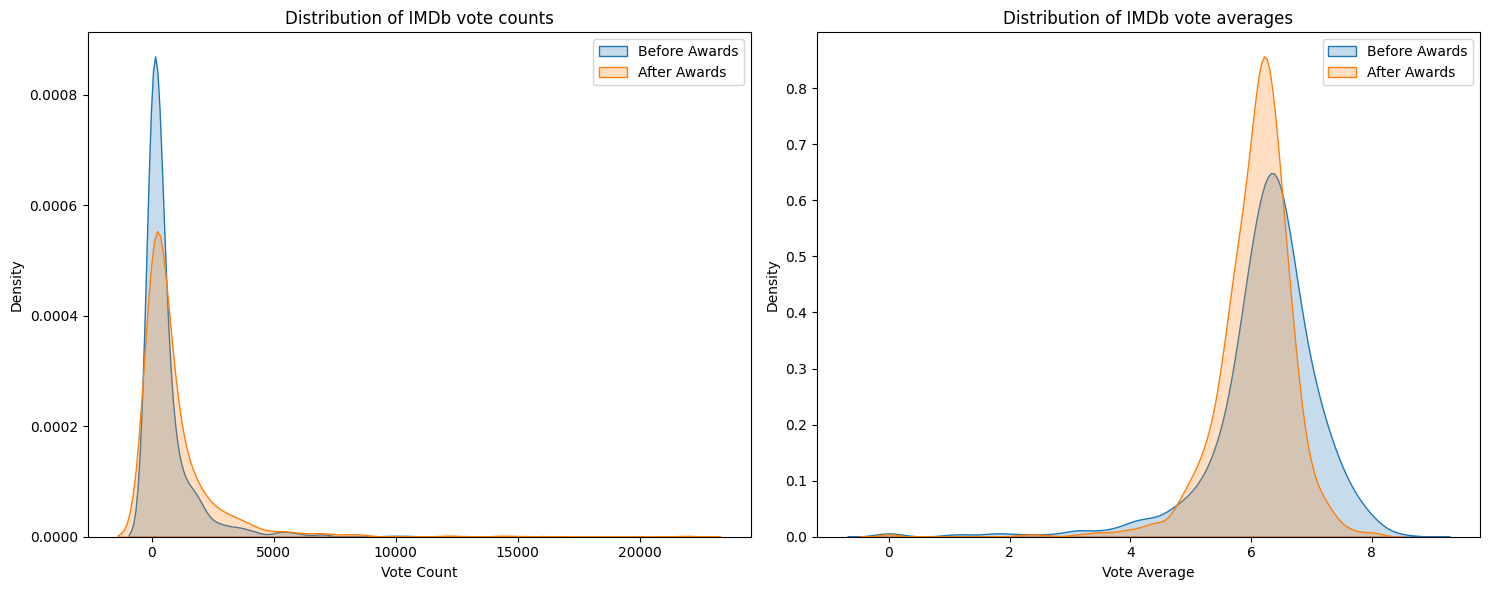

In [113]:

# Create a figure with two subplots
plt.figure(figsize=(15, 6))

# Plot distribution of vote averages before and after awards
# Plot distribution of box office revenue before and after awards
plt.subplot(1, 2, 1)
sns.kdeplot(before_means['vote_count'], label='Before Awards', shade=True)
sns.kdeplot(after_means['vote_count'], label='After Awards', shade=True)
plt.title('Distribution of IMDb vote counts')
plt.xlabel('Vote Count')
plt.ylabel('Density')
plt.legend()

# Plot distribution of log-transformed box office revenue before and after awards
plt.subplot(1, 2, 2)
sns.kdeplot(before_means['vote_average'], label='Before Awards', shade=True)
sns.kdeplot(after_means['vote_average'], label='After Awards', shade=True)
plt.title('Distribution of IMDb vote averages')
plt.xlabel('Vote Average')
plt.ylabel('Density')
plt.legend()

# Display the plots
plt.tight_layout()
plt.show()

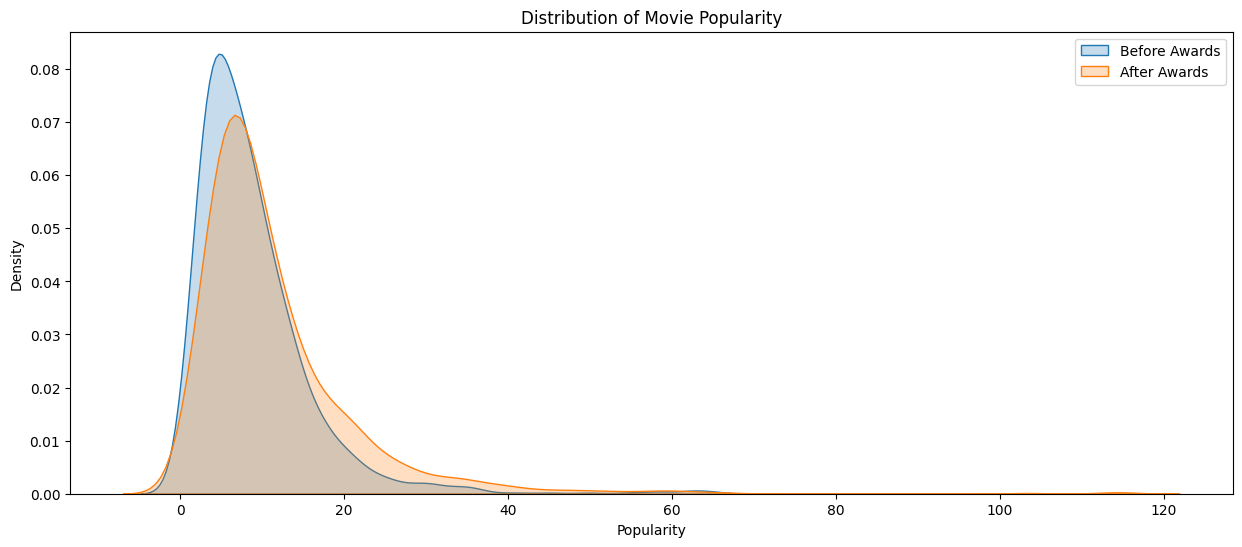

In [114]:
plt.figure(figsize=(15, 6))

sns.kdeplot(before_means['popularity'], label='Before Awards', shade=True)
sns.kdeplot(after_means['popularity'], label='After Awards', shade=True)
plt.title('Distribution of Movie Popularity')
plt.xlabel('Popularity')
plt.ylabel('Density')
plt.legend()

In [115]:
from sklearn.utils import resample
%matplotlib inline
# Set the seed for reproducibility
np.random.seed(0)

def plot_effect(Y_outcome, outcome_name, ax):
    # Filter out IDs with no treatment date
    dynamic_effects = Y_outcome.copy()
    
       
    # Calculate mean effect for each 'relative_date'
    weekly_effects = dynamic_effects.groupby('relative_year')[outcome_name].mean().reset_index()
    
    # Initialize lists to store the results of the bootstrap procedure
    bootstrap_means = []
    n_bootstrap = 100  
    unique_ids = dynamic_effects['Freebase actor ID'].unique()
    
    # Perform block bootstrap resampling
    for i in range(n_bootstrap):
        sampled_ids = resample(unique_ids, replace=True)
        bootstrap_sample = dynamic_effects[dynamic_effects['Freebase actor ID'].isin(sampled_ids)]
        bootstrap_mean = bootstrap_sample.groupby('relative_year')[outcome_name].mean()
        bootstrap_means.append(bootstrap_mean)
    
    bootstrap_means_df = pd.DataFrame(bootstrap_means)
    
    # Calculate the 2.5th and 97.5th percentiles for the 95% confidence intervals
    ci_lower = bootstrap_means_df.quantile(0.025)
    ci_upper = bootstrap_means_df.quantile(0.975)

        
    
    ax.plot(weekly_effects['relative_year'], weekly_effects[outcome_name], label=f'Estimated Weekly Effect ({outcome_name})', marker='o')
    ax.fill_between(weekly_effects['relative_year'], ci_lower, ci_upper, color='b', alpha=0.3, label='95% Confidence Interval')
    ax.axvline(x=0, color='r', linestyle='--', linewidth=2, label='Event Time')
    ax.set_xlabel('Years from Award Win or Nomination')
    ax.set_ylabel(f'Average {outcome_name}')
    ax.set_title(f'Effects of Award Win on {outcome_name.capitalize()}')
    ax.legend()
    ax.grid(True)
    

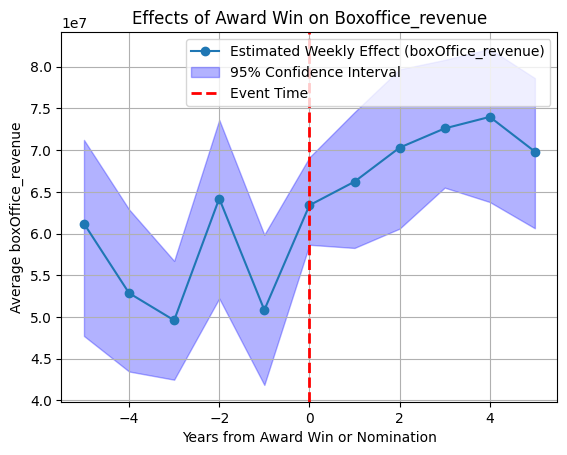

In [116]:
event_time_study = movies_characters_df.copy()
event_time_study = event_time_study.dropna(subset=['year_ceremony'])
event_time_study["relative_year"] = event_time_study["year"] - event_time_study["year_ceremony"] + 1
#filter on relative year to get only the movies that were released 5 years before and after the award
relevant_years = event_time_study[event_time_study["relative_year"].between(-5, 5)]
plot_effect(relevant_years, 'boxOffice_revenue', plt.gca())




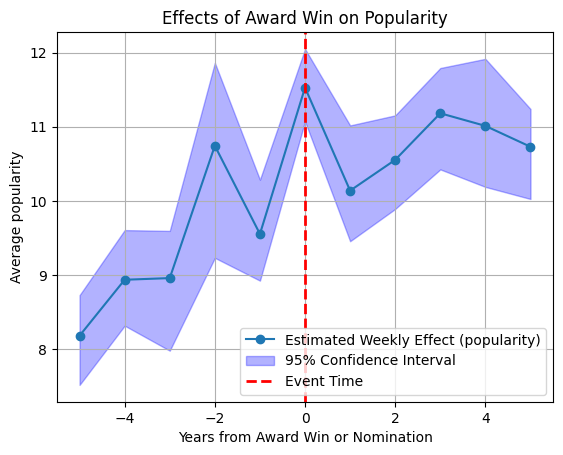

In [117]:
plot_effect(relevant_years, 'popularity', plt.gca())


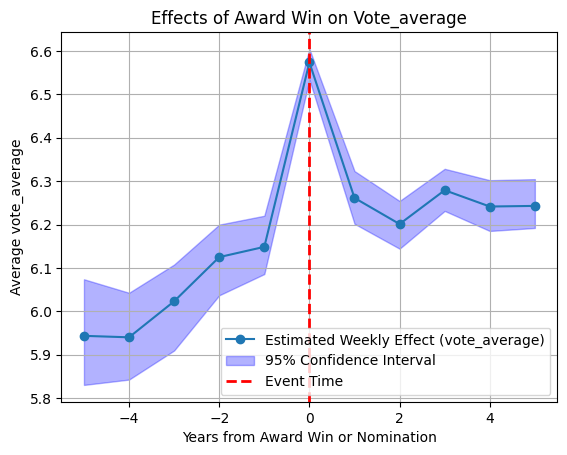

In [118]:
plot_effect(relevant_years, 'vote_average', plt.gca())

We can observe that winning or being nominated for an award has a ripple effect on the Box Office revenue of an actor's future movies, as this increases on average in the 5 years after the win or nomination, as compared to the 5 years before. As for the popularity and average rating, we observe a similar effect, although there is a peak at the year in question, which makes sense as critically acclaimed movies tend to be more popular (and have a higher rating on IMDb).

We will now proceed to split the dataset as follows:

Treatment Group: This group includes actors who received or were nominated for awards

Control Group: Comprising actors without award recognitions, this group serves as a baseline for comparison. Notably, actors in this group appear multiple times, representing different stages of their careers.


# Matching and Analysis

Actors in the treatment group were matched with those in the control group based on career-related factors which were years of experience and cumulative movies, as well as most common genre of movies that they starred in. Finally, to reduce bias and ensure fair comparisons, we only included movies made in the USA after the year 1990. This ensures that box office numbers are more comparable, but also that we take into account as many confounding variables as we can. 

In [119]:
actor_analysis_df = movies_characters_df.copy()

In [120]:
actor_analysis_df_test = actor_analysis_df.dropna(subset=['country', "year"])
actor_analysis_df_usa = actor_analysis_df_test[actor_analysis_df_test['country'].apply(lambda x: "United States of America" in x if isinstance(x, list) else False)]
actor_analysis_df_usa = actor_analysis_df_usa[actor_analysis_df_usa["year"] >= 1995]
actor_analysis_df_usa

,id,freebase_id,title,release_date,boxOffice_revenue,runtime,language,country,genres_x,year,...,Actor gender,Actor ethnicity,Actor name,Actor age at movie release,Freebase actor ID,Actor birth year,won,nominations,year_ceremony,film
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",2001.0,...,F,NaN,Wanda De Jesus,42.0,/m/03wcfv7,1958.0,0.0,0.0,NaN,NaN
1,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",2001.0,...,F,/m/044038p,Natasha Henstridge,27.0,/m/0346l4,1974.0,0.0,0.0,NaN,NaN
2,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",2001.0,...,M,/m/0x67,Ice Cube,32.0,/m/01vw26l,1969.0,0.0,0.0,NaN,NaN
3,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",2001.0,...,M,NaN,Jason Statham,33.0,/m/034hyc,1967.0,0.0,0.0,NaN,NaN
4,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",2001.0,...,F,NaN,Clea DuVall,23.0,/m/01y9xg,1977.0,0.0,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
389415,11952284,/m/02rzf97,The Devil's Child,1997-10-26,NaN,90.0,[English Language],[United States of America],[Horror],1997.0,...,F,NaN,Gia Carides,33.0,/m/07wgg_,1964.0,0.0,0.0,NaN,NaN
389416,11952284,/m/02rzf97,The Devil's Child,1997-10-26,NaN,90.0,[English Language],[United States of America],[Horror],1997.0,...,F,NaN,Grace Zabriskie,56.0,/m/09c84c,1941.0,0.0,0.0,NaN,NaN
389417,11952284,/m/02rzf97,The Devil's Child,1997-10-26,NaN,90.0,[English Language],[United States of America],[Horror],1997.0,...,F,/m/041rx,Maya Rudolph,25.0,/m/02k21g,1972.0,0.0,0.0,NaN,NaN
389418,11952284,/m/02rzf97,The Devil's Child,1997-10-26,NaN,90.0,[English Language],[United States of America],[Horror],1997.0,...,M,NaN,Thomas Gibson,35.0,/m/0336h6,1962.0,0.0,0.0,NaN,NaN


In [121]:
actor_analysis_df_usa['cumulative_movies'] = actor_analysis_df_usa.sort_values(by='year').groupby('Freebase actor ID').cumcount() + 1
first_year = actor_analysis_df_usa.groupby('Freebase actor ID')['year'].min()

actor_analysis_df_usa = actor_analysis_df_usa.merge(first_year.rename('first_year'), on='Freebase actor ID')

actor_analysis_df_usa['years_of_experience'] = actor_analysis_df_usa['year'] - actor_analysis_df_usa['first_year']

In [122]:

# Group by 'Freebase actor ID' and aggregate genres
actor_genres = actor_analysis_df_usa.dropna(subset=["genres"]).groupby('Freebase actor ID')['genres'].agg(list)

# Extract the most frequent genre for each actor
actor_majority_genres = actor_genres.apply(get_majority_genre)

# Convert to DataFrame
actor_majority_genres = actor_majority_genres.reset_index()
actor_majority_genres.columns = ['Freebase actor ID', 'Majority Genre']


In [123]:

actor_analysis_df_usa['post'] = actor_analysis_df_usa.apply(lambda x: 1 if x["film"] == x["title"] else 0, axis=1)

control_group = actor_analysis_df_usa[actor_analysis_df_usa['year_ceremony'].isna() & actor_analysis_df_usa['boxOffice_revenue'].notna()]
treatment_group = actor_analysis_df_usa[~actor_analysis_df_usa['year_ceremony'].isna()]
treatment_group = treatment_group.sort_values(by='year')
treatment_group_actor_single = treatment_group[treatment_group["post"] == 1].groupby("Freebase actor ID").first()

grouped = control_group.groupby("Freebase actor ID")

control_group_actor_single = grouped.apply(get_sorted_last_row)


treatment_group_actor_single.reset_index(inplace=True)

In [124]:
control_group_actor_single

,id,freebase_id,title,release_date,boxOffice_revenue,runtime,language,country,genres_x,year,...,Freebase actor ID,Actor birth year,won,nominations,year_ceremony,film,cumulative_movies,first_year,years_of_experience,post
Freebase actor ID,,,,,,,,,,,,,,,,,,,,,
/m/010p3,29384326,/m/0ds67cb,Spy Kids 4: All the Time in the World,2011-08-18,85565310.0,89.0,[English Language],[United States of America],"[Science Fiction, Adventure, Action/Adventure,...",2011.0,...,/m/010p3,1964.0,0.0,0.0,NaN,NaN,10.0,1998.0,13.0,0
/m/010q36,21132353,/m/033pf1,Casper,1995-05-26,287928194.0,110.0,[English Language],[United States of America],"[Horror, Comedy-drama, Fantasy, Comedy, Black ...",1995.0,...,/m/010q36,1928.0,0.0,0.0,NaN,NaN,1.0,1995.0,0.0,0
/m/011_8,16706073,/m/03ynwqj,"I Love You, Man",2009-03-20,91636986.0,105.0,[English Language],[United States of America],"[Romance Film, Buddy film, Comedy]",2009.0,...,/m/011_8,1953.0,0.0,0.0,NaN,NaN,1.0,2009.0,0.0,0
/m/011_ww,24341999,/m/09p5mwg,Saw VII,2010-10-21,136100000.0,92.0,[English Language],"[United States of America, Canada]","[Crime Fiction, Horror, Psychological thriller...",2010.0,...,/m/011_ww,1976.0,0.0,0.0,NaN,NaN,2.0,2001.0,9.0,0
/m/011xl3,1562557,/m/05bmcq,Detroit Rock City,1999-08-09,24217115.0,95.0,[English Language],[United States of America],"[Music, Comedy, Teen]",1999.0,...,/m/011xl3,1945.0,0.0,0.0,NaN,NaN,1.0,1999.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
/m/0y58x,1994205,/m/06ckv_,Slackers,2002-02-01,6413915.0,88.0,[English Language],"[United States of America, Canada]","[Romantic comedy, Sex comedy, Gross-out film, ...",2002.0,...,/m/0y58x,1978.0,0.0,0.0,NaN,NaN,11.0,1995.0,7.0,0
/m/0y8r3,23773341,/m/06znpv0,The September Issue,2009-08-20,6325313.0,90.0,[English Language],[United States of America],"[Journalism, Business, Biography, Graphic & Ap...",2009.0,...,/m/0y8r3,1932.0,0.0,0.0,NaN,NaN,1.0,2009.0,0.0,0
/m/0z05l,3289723,/m/093l8p,Transamerica,2005-02-14,15151744.0,103.0,"[English Language, Spanish Language]",[United States of America],"[LGBT, Indie, Road movie, Family Drama, Comedy...",2005.0,...,/m/0z05l,1952.0,0.0,0.0,NaN,NaN,7.0,1995.0,10.0,0


In [125]:
control_group_actor_single = control_group_actor_single.reset_index(drop=True)

# Merge the majority genre information with actor data
treatment_group_actor_single = treatment_group_actor_single.merge(actor_majority_genres, on='Freebase actor ID', how='left')
control_group_actor_single = control_group_actor_single.merge(actor_majority_genres, on='Freebase actor ID', how='left')
treatment_group_actor_single.dropna(subset=["Majority Genre", "years_of_experience", "cumulative_movies"],inplace=True)
control_group_actor_single.dropna(subset=["Majority Genre", "years_of_experience", "cumulative_movies"],inplace=True)

In [126]:

# Initialize a list for matched pairs
matched_pairs_list = []

# Define a distance threshold for matching
distance_threshold = 0 

# Iterate over each actor in the treatment group
for index, treatment_actor in treatment_group_actor_single.iterrows():
    treatment_data = treatment_actor[['years_of_experience', 'cumulative_movies']].values
    treatment_genre = treatment_actor['Majority Genre']

    # Iterate over control group to find all matches within the threshold
    for control_index, control_actor in control_group_actor_single.iterrows():
        control_data = control_actor[['years_of_experience', 'cumulative_movies']].values
        control_genre = control_actor['Majority Genre']



        # Calculate Euclidean distance for numerical variables

        distance = euclidean_distance(treatment_data, control_data)

        # Check if genres match
        genre_match = treatment_genre == control_genre

        # Update condition to include genre match
        if distance <= distance_threshold and genre_match:
            # Create a dictionary for each valid matched pair
            matched_pair = {
                'treatment_actor_name': treatment_actor['Actor name'],
                'treatment_freebase_id': treatment_actor['Freebase actor ID'],
                'treatment_years_of_experience': treatment_actor['years_of_experience'],
                'treatment_cumulative_movies': treatment_actor['cumulative_movies'],
                'treatment_majority_genre': treatment_actor['Majority Genre'],
                'control_actor_name': control_actor['Actor name'],
                'control_freebase_id': control_actor['Freebase actor ID'],
                'control_years_of_experience': control_actor['years_of_experience'],
                'control_cumulative_movies': control_actor['cumulative_movies'],
                'control_majority_genre': control_actor['Majority Genre']
            }
            matched_pairs_list.append(matched_pair)

# Convert the list of dictionaries to a DataFrame
matched_pairs = pd.DataFrame(matched_pairs_list)

matched_pairs


,treatment_actor_name,treatment_freebase_id,treatment_years_of_experience,treatment_cumulative_movies,treatment_majority_genre,control_actor_name,control_freebase_id,control_years_of_experience,control_cumulative_movies,control_majority_genre
0,Will Smith,/m/0147dk,3.0,5.0,Drama,Franky G,/m/09t4_6,3.0,5.0,Drama
1,Will Smith,/m/0147dk,3.0,5.0,Drama,David Fine,/m/0c1pjr2,3.0,5.0,Drama
2,"Cuba Gooding, Jr.",/m/014v6f,1.0,4.0,Drama,Jillian Batherson,/m/0gc1r2x,1.0,4.0,Drama
3,Cynthia Nixon,/m/015c2f,9.0,7.0,Drama,Lynda Boyd,/m/027by0j,9.0,7.0,Drama
4,Cynthia Nixon,/m/015c2f,9.0,7.0,Drama,Debbi Morgan,/m/0347mv,9.0,7.0,Drama
...,...,...,...,...,...,...,...,...,...,...
6691,Jim Carrey,/m/0lx2l,2.0,4.0,Comedy,Fred Keating,/m/0k0zp_,2.0,4.0,Comedy
6692,Adam Sandler,/m/0pz91,7.0,6.0,Comedy,Fred Dalton Thompson,/m/02p8v8,7.0,6.0,Comedy
6693,Adam Sandler,/m/0pz91,7.0,6.0,Comedy,Ken Marino,/m/05bmg8,7.0,6.0,Comedy
6694,Adam Sandler,/m/0pz91,7.0,6.0,Comedy,Aaron Himelstein,/m/06ds07,7.0,6.0,Comedy


Note that if there were more than many exact matches from the treatment group to the control group, we keep all of them.

In [127]:

# Define a function to filter movies based on years of experience
def filter_and_average_revenue(actor_id, df, years_range=10):
    relevant_movies = df[(df['Freebase actor ID'] == actor_id) &
                         ((df['release_year'] - df["first_year"]) <= years_range)]
    return relevant_movies['boxOffice_revenue'].mean()

actor_analysis_df_usa['release_year'] = pd.to_datetime(actor_analysis_df_usa['release_date']).dt.year

# Lists to store average revenues
treatment_revenues = []
control_revenues = []

# Iterate through matched pairs
for index, row in matched_pairs.iterrows():
    # Treatment actor revenue
    treatment_revenue = filter_and_average_revenue(row['treatment_freebase_id'], 
                                                   
                                                  actor_analysis_df_usa)
    if not pd.isna(treatment_revenue):
        treatment_revenues.append(treatment_revenue)

    # Control actor revenue
    control_revenue = filter_and_average_revenue(row['control_freebase_id'], 
                                                
                                                 actor_analysis_df_usa)
    if not pd.isna(control_revenue):
        control_revenues.append(control_revenue)

# Perform the t-test
t_stat, p_value = ttest_ind(treatment_revenues, control_revenues, nan_policy='omit')

print("T-test statistic:", t_stat)
print("P-value:", p_value)

T-test statistic: 34.71665529278887
P-value: 5.515137818977213e-252


In [128]:
# print means of revenues
print("Treatment mean revenue:", np.mean(treatment_revenues))
print("Control mean revenue:", np.mean(control_revenues))

Treatment mean revenue: 94638445.22240938
Control mean revenue: 39023198.4538506


The t-test results indicate a statistically significant difference in mean box office revenues. Actors recognized in an Oscar or Golden Globe ceremony demonstrate substantially higher box office figures 5 years post-recognition, compared to actors of similar career stage and profile who did not receive such awards.

### Cultural Canvases on the Global Screen

In [129]:
!pip install SPARQLWrapper

zsh:1: command not found: pip


In [109]:
actor_movies_copy_df = actor_movies_df.copy()

# Remove duplicates to avoid querying the same IDs multiple times
unique_ids = actor_movies_copy_df['Actor ethnicity'].drop_duplicates()

# Apply the function to the unique IDs
# This creates a Series with Freebase IDs as the index and Q-numbers as the values
q_numbers = unique_ids.apply(query_wikidata_for_qnumber)

# We also need it as dictionary to map back to the original dataframe
q_numbers_dict = {unique_ids.iloc[i]: q_numbers.iloc[i] for i in range(len(unique_ids))}

# Apply the function to Q-numbers
# We map ethnicities to original DataFrame using a dictionary with Q-numbers as keys and queried ethnicities from Wikidata as values.
ethnicity_dict = {q_nb: get_ethnicity_from_wikidata(q_nb) for q_nb in q_numbers}

In [110]:
# Mapping back to the original dataframe
actor_movies_copy_df['q_number'] = actor_movies_copy_df['Actor ethnicity'].map(q_numbers_dict)
actor_movies_copy_df['Actor ethnicity mapped'] = actor_movies_copy_df['q_number'].map(ethnicity_dict)
# Setting the ethnicity to NaN if the original dataframe had NaN values in the unique IDs column
# We do this to differenciate between the NaNs and the IDs that were not found in Wikidata which we map to "Other Ethnicities"
actor_movies_copy_df['Actor ethnicity mapped'] = np.where(actor_movies_copy_df['Actor ethnicity'].isna(),
                                                           np.nan, actor_movies_copy_df['Actor ethnicity mapped'])

# Assigning the values from 'Actor ethnicity mapped' to 'Actor ethnicity' and dropping the redundant and unneeded columns
actor_movies_copy_df['Actor ethnicity'] = actor_movies_copy_df['Actor ethnicity mapped']
actor_movies_copy_df.drop(columns=['Actor ethnicity mapped', 'q_number'], inplace=True)

**Top 10 Ethnicities in terms of number of actors**

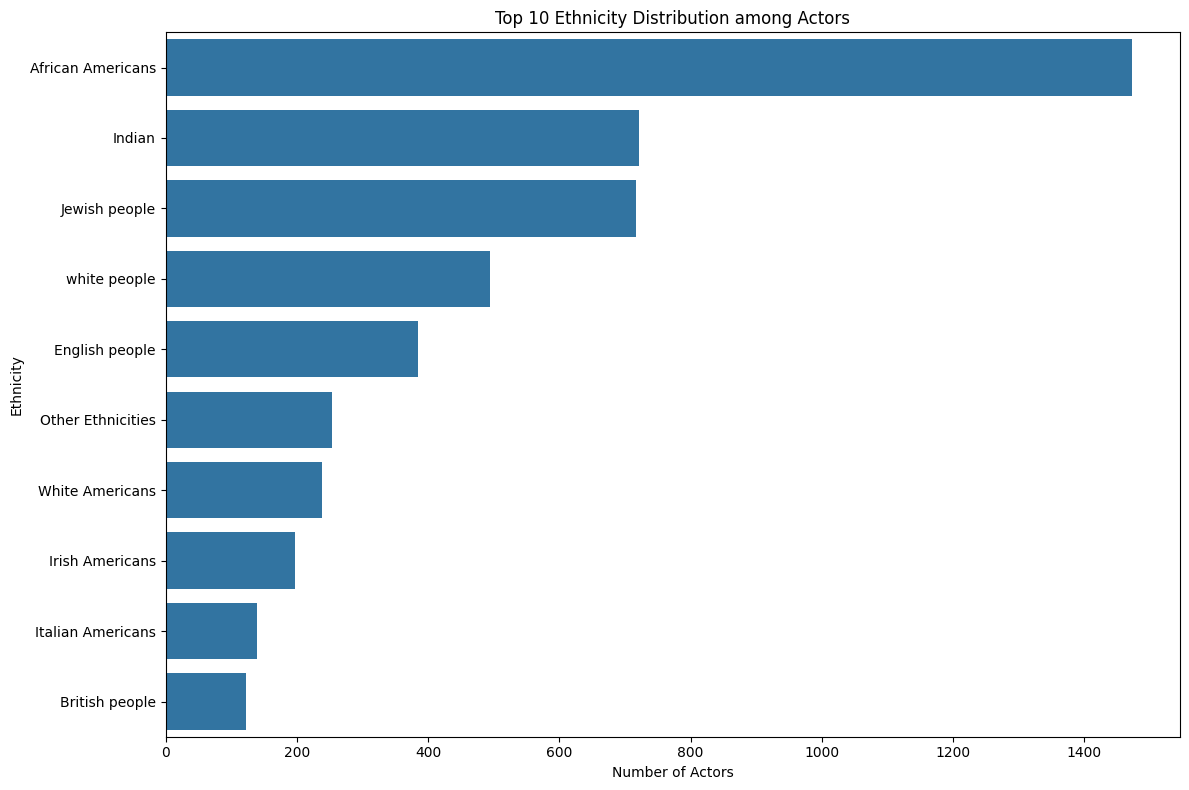

In [111]:
top10_ethnicities = actor_movies_copy_df['Actor ethnicity'].value_counts().head(10)
plt.figure(figsize=(12, 8))
sns.barplot(x=top10_ethnicities.values, y=top10_ethnicities.index)
plt.title('Top 10 Ethnicity Distribution among Actors')
plt.xlabel('Number of Actors')
plt.ylabel('Ethnicity')
plt.tight_layout()
plt.show()

Immediately we notice a huge overlap between some of the ethnicities (for example white people and White Americans). We will tackle this by clustering the ethnicities into more representative groups (regions).

**Average Movie Revenue per Actor per Ethnicity**

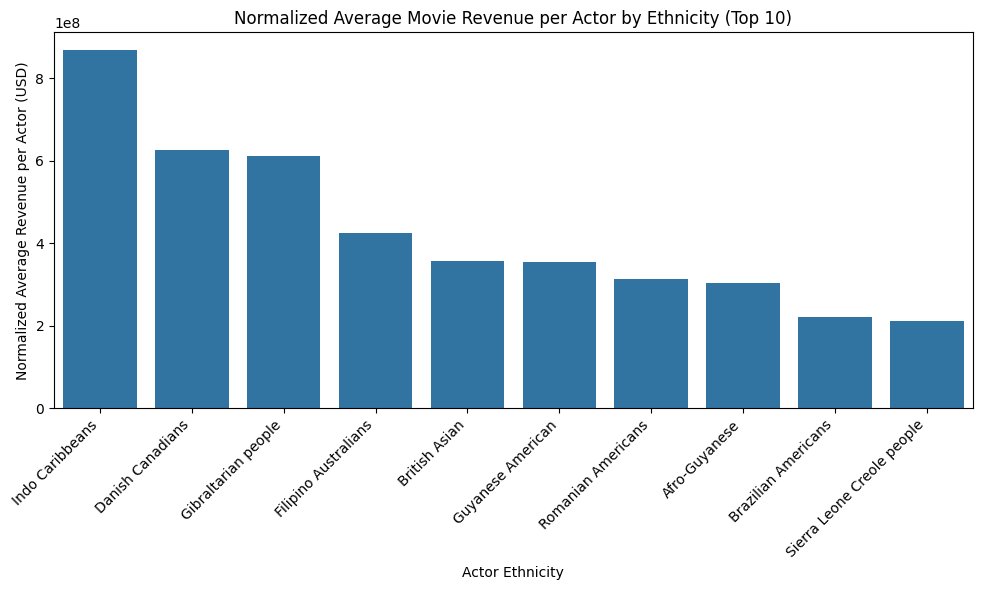

In [112]:
# We make a copy of the dataframes we want to use: one for actors and one for movies
actors_copy_df = actor_movies_copy_df.copy()
revenues_ratings_copy_df = revenues_ratings_df.copy().drop_duplicates(subset=['freebase_id'])

# We explode the dataframe so each row corresponds to an actor-movie pair instead of one movie list for each actor
actors_exploded_df = actors_copy_df.explode('freebase_id')
actors_exploded_df = actors_exploded_df.drop_duplicates(subset=['Freebase actor ID', 'freebase_id'])
merged_df = pd.merge(actors_exploded_df, revenues_ratings_copy_df, left_on='freebase_id', right_on='freebase_id', how='inner')
average_revenue_by_ethnicity = merged_df.groupby('Actor ethnicity')['boxOffice_revenue'].mean().reset_index()

# We make a copy of merged_df to drop duplicate actors and count how many actors we have in each ethnicity AFTER merging the dataframes
merged_df_copy = merged_df.copy()
merged_df_copy = merged_df_copy.drop_duplicates(subset=['Freebase actor ID'])
total_actors_per_ethnicity = merged_df_copy.groupby('Actor ethnicity').size().reset_index(name='actor_count')

# We normalize (divide by number of actors in each ethnicity) to avoid the results being skewed by the number of actors in ethnicity groups
merged_ethnicity_data = pd.merge(average_revenue_by_ethnicity, total_actors_per_ethnicity, on='Actor ethnicity')
merged_ethnicity_data['normalized_revenue'] = merged_ethnicity_data['boxOffice_revenue'] / merged_ethnicity_data['actor_count']
merged_ethnicity_data = merged_ethnicity_data.sort_values(by='normalized_revenue', ascending=False)

plt.figure(figsize=(10, 6))
normalized_barplot = sns.barplot(x='Actor ethnicity', y='normalized_revenue', data=merged_ethnicity_data.head(10))
normalized_barplot.set_xticklabels(normalized_barplot.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.title('Normalized Average Movie Revenue per Actor by Ethnicity (Top 10)')
plt.xlabel('Actor Ethnicity')
plt.ylabel('Normalized Average Revenue per Actor (USD)')
plt.tight_layout()
plt.show()

This code is a preliminary analysis of whether an actor's ethnicity influences a movie's box office success. By comparing average revenues of movies featuring actors from different ethnicities and then adjusting these averages based on the number of actors in each group, we aim to see whether some ethnicities are associated with higher revenues in a more equitable and representative way.
From the plot, we can see that the highest revenue per actor is associated to the Bristish Asian ethnicity.


But we notice that the actor counts for these ethnicities are very low (9/10 are just 2 or 1). Therefore, we will introduce a cut-off point. We will require at least 10 actors from one ethnicity for the ethnicity to be considered in this part of our analysis:

In [113]:
#We filter to include only ethnicities with more than 10 occurrences
total_actors_per_ethnicity_min_10 = total_actors_per_ethnicity[total_actors_per_ethnicity['actor_count'] > 10]

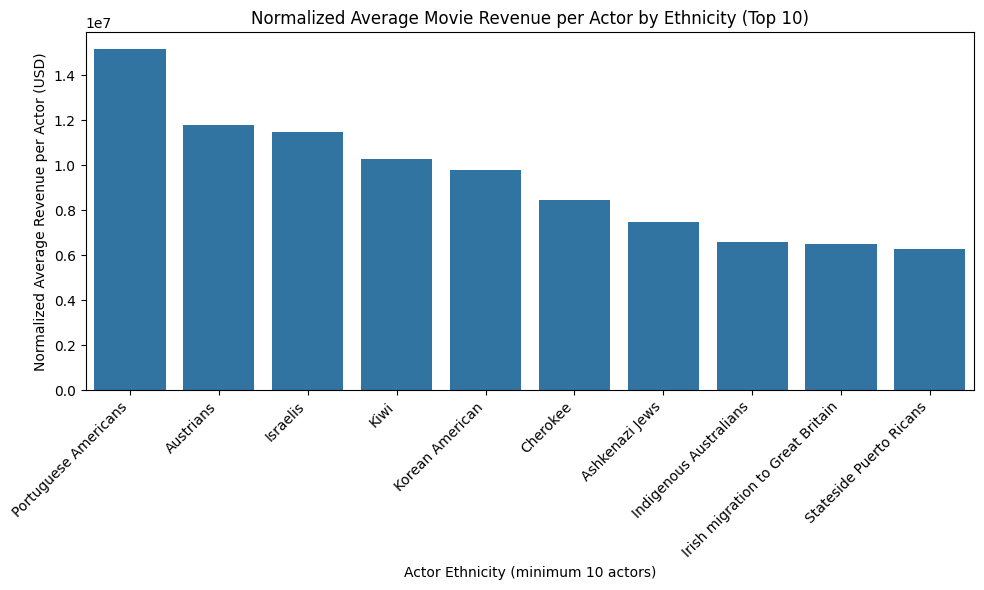

In [114]:
merged_ethnicity_data_filtered = merged_ethnicity_data[merged_ethnicity_data['Actor ethnicity'].
                                                       isin(total_actors_per_ethnicity_min_10['Actor ethnicity'])].head(10)

plt.figure(figsize=(10, 6))
normalized_barplot = sns.barplot(x='Actor ethnicity', y='normalized_revenue', data=merged_ethnicity_data_filtered.head(10))

# Improve the readability of the plot
normalized_barplot.set_xticklabels(normalized_barplot.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.title('Normalized Average Movie Revenue per Actor by Ethnicity (Top 10)')
plt.xlabel('Actor Ethnicity (minimum 10 actors)')
plt.ylabel('Normalized Average Revenue per Actor (USD)')
plt.tight_layout()
plt.show()

- These graphs above are a comparison of average movie revenue per actor before and after applying a filter for a minimum of ten actors per ethnicity. It's important to study this because it helps us understand the commercial impact of having actors of different ethnicities in movies. From the first to the second graph, we see a change in which ethnicities appear, suggesting that some groups have fewer actors but still a significant impact on revenue (probably irrelevant due to sample size). 
- However, because the analysis is not highly conclusive, it's a starting point that indicates the need for a more in-depth look at diversity in film and its economic implications. It shows a glimpse of the potential market performance of movies with diverse casts but requires further study to draw strong conclusions.

**Average Movie Rating by Ethnicity**

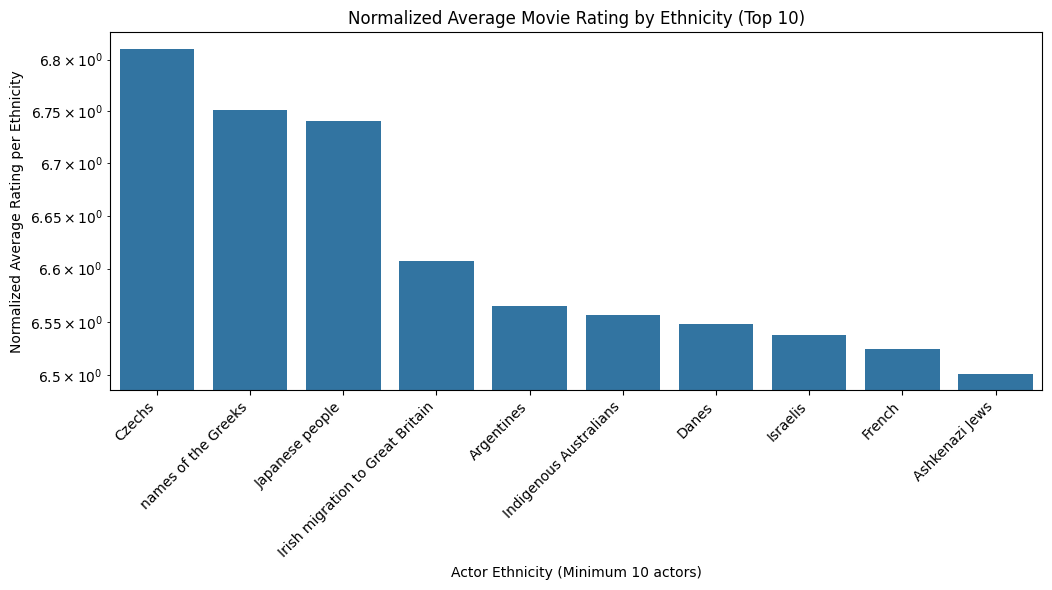

In [115]:
#Grouping by actor ethnicity, but only for ethnicities with more than 10 different actors
#We do this because some ethnicities have only 1 or 2 actors that participate in more than 10 movies
average_ratings_by_ethnicity = merged_df.groupby('Actor ethnicity')['averageRating'].mean().reset_index()
average_ratings_by_ethnicity_filtered = average_ratings_by_ethnicity[average_ratings_by_ethnicity['Actor ethnicity'].isin(total_actors_per_ethnicity_min_10['Actor ethnicity'])]
average_ratings_by_ethnicity_filtered = average_ratings_by_ethnicity_filtered.sort_values(by='averageRating', ascending=False)

plt.figure(figsize=(10, 6))
normalized_barplot = sns.barplot(x='Actor ethnicity', y='averageRating', data=average_ratings_by_ethnicity_filtered.head(10))

normalized_barplot.set_xticklabels(normalized_barplot.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.title('Normalized Average Movie Rating by Ethnicity (Top 10)')
plt.xlabel('Actor Ethnicity (Minimum 10 actors)')
plt.ylabel('Normalized Average Rating per Ethnicity')
plt.tight_layout()
plt.yscale('log')
plt.show()

- The graph shows movie ratings linked to actors' ethnicities. This simple plot indicates that films with Czech actors get the best ratings, but other ethnicities are not far behind. This means people are enjoying movies with actors from different backgrounds in general.
- It is noteworthy to mention that we used a logarithmic scale on the y-axis because the ratings are very close to each other and the plot doesn't really show any value otherwise.

**Temporal Trends**

<Figure size 1500x800 with 0 Axes>

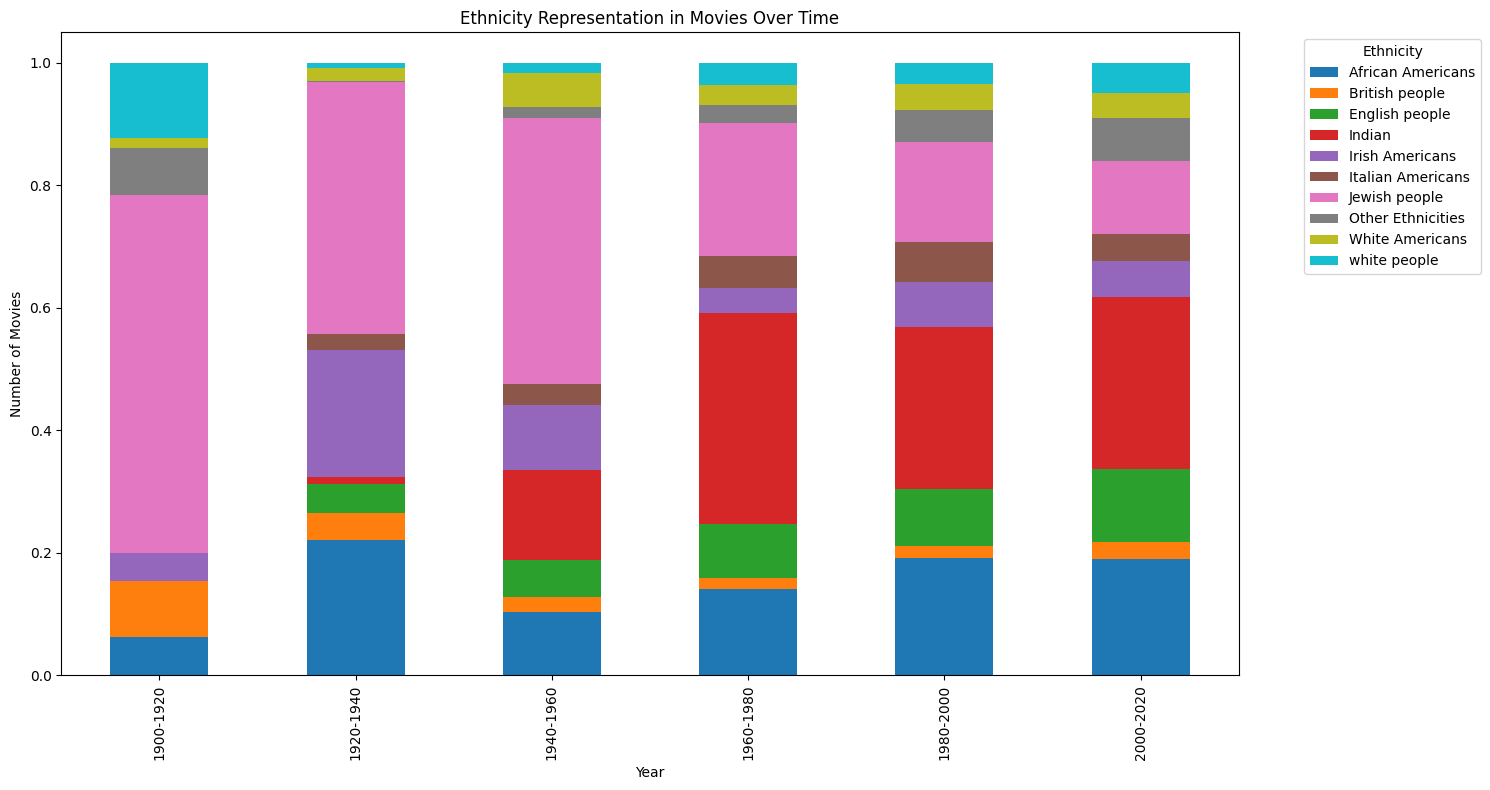

In [116]:
top5_merged_df = merged_df.copy()
top5_ethnicities = actors_copy_df['Actor ethnicity'].value_counts().head(10)

year_bins = [1900, 1920, 1940, 1960, 1980, 2000, 2020]
year_labels = ['1900-1920', '1920-1940', '1940-1960', '1960-1980', '1980-2000', '2000-2020']

top5_merged_df['year'] = pd.cut(top5_merged_df['year'], bins=year_bins, labels=year_labels)

top5_merged_df = top5_merged_df[top5_merged_df['Actor ethnicity'].isin(top5_ethnicities.index)]
yearly_ethnicity_trends = top5_merged_df.groupby(['year', 'Actor ethnicity']).size().unstack(fill_value=0)

normalized_ethnicity_distribution = yearly_ethnicity_trends.div(yearly_ethnicity_trends.sum(axis=1), axis=0)

plt.figure(figsize=(15, 8))
normalized_ethnicity_distribution.plot(kind='bar', stacked=True, figsize=(15, 8))
plt.title('Ethnicity Representation in Movies Over Time')
plt.xlabel('Year')
plt.ylabel('Number of Movies')
plt.legend(title='Ethnicity', bbox_to_anchor=(1.05, 1), loc='upper left') 
plt.tight_layout()
plt.show()

- We analyze the ethnicity representation in movies over time to track the progress of diversity and inclusivity in the film industry. It offers a visual insight into how the portrayal of various ethnic groups has changed, potentially reflecting shifts in societal attitudes and stereotypes. The chart indicates a trend towards greater diversity in recent decades, suggesting a response to increased awareness and demand for representation, which makes sense. 
- It is very important to note that the ethnicities given from the dataset can be clustered into more compact and inclusive ethnicities for better analysis, which we will do below!

#### Preparing the Datafram for Regression

In [117]:
# Apply the importance function to each row
merged_df['importance'] = merged_df.apply(calculate_importance, axis=1)

In [118]:
MAPPED_ETHNICITIES_PATH = DATA_FOLDER + 'remapped_ethnicities_all_combinations.txt'
MAPPED_COUNTRIES_PATH = DATA_FOLDER + 'remapped_countries.txt'

# Read the text file with a specified encoding and create a dictionary
ethnicity_region_map = {}
with open(MAPPED_ETHNICITIES_PATH, 'r', encoding='utf-8') as file:
    for line in file:
        parts = line.strip().split(' - ')
        if len(parts) == 2:
            ethnicity, region = parts
            ethnicity_region_map[ethnicity] = region



# Apply the mapping function to the DataFrame
merged_df['Ethnicity Region'] = merged_df['Actor ethnicity'].apply(map_ethnicity_to_region)

In [119]:
unique_countries_list = sorted({country[0] for country in revenues_ratings_df['country'] if country})

countries = unique_countries_list


# Create the mapping
country_region_map = read_regions_and_countries(MAPPED_COUNTRIES_PATH)

In [120]:
# Apply the function to the 'country' column and create a new 'region' column
merged_df['country'] = merged_df['country'].apply(lambda x: x[0] if isinstance(x, list) and len(x) > 0 else None)
merged_df['Movie region'] = merged_df['country'].apply(lambda x: extract_country_and_map_to_region(x, country_region_map))
regression_df = merged_df[['freebase_id','boxOffice_revenue','runtime','year','averageRating','original_language','popularity',
                            'budget','importance','Ethnicity Region','Movie region','Freebase actor ID']]

In [121]:
importance_df = merged_df.copy()

In [122]:
# Create dummy variables for categorical variables
categorical_columns = ['Ethnicity Region', 'Movie region', 'original_language']
dummies = pd.get_dummies(regression_df[categorical_columns], drop_first=True, 
                         prefix={col: col.replace(' ', '') for col in categorical_columns})
regression_df = pd.concat([regression_df, dummies], axis=1)

# Calculate weighted average of Ethnicity Match
regression_df['ethnicity_match'] = (regression_df['Ethnicity Region'] == regression_df['Movie region']).astype(int)
weighted_avg_ethnicity_match = regression_df.groupby('freebase_id').apply(
    lambda x: (x['ethnicity_match'] * x['importance']).sum() / x['importance'].sum()
).reset_index(name='weighted_avg_ethnicity_match')
regression_df = regression_df.merge(weighted_avg_ethnicity_match, on='freebase_id', how='left')

# Create Binary Variable for Main Actor Match
regression_df['main_actor_match'] = ((regression_df['ethnicity_match'] == 1) & (regression_df['importance'] == 1)).astype(int)

# Normalize all numerical columns of regression_df while keeping the binary variable as is

# Select only numerical columns and exclude 'main_actor_match'
numerical_cols = regression_df.select_dtypes(include=['float64', 'int64']).columns
numerical_cols = numerical_cols.drop('main_actor_match')  # Exclude 'main_actor_match'

# Create a StandardScaler object
scaler = StandardScaler()

# Fit the scaler to the selected data and transform it
regression_df[numerical_cols] = scaler.fit_transform(regression_df[numerical_cols])

### MODEL 1: Box Office Revenue on Weighted Average Ethnicity Match

In [123]:
formula = 'boxOffice_revenue ~ weighted_avg_ethnicity_match'
run_and_report_regression(formula, regression_df)

                            OLS Regression Results                            
Dep. Variable:      boxOffice_revenue   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     37.28
Date:                Fri, 22 Dec 2023   Prob (F-statistic):           1.03e-09
Time:                        19:55:22   Log-Likelihood:            -1.4298e+05
No. Observations:              103224   AIC:                         2.860e+05
Df Residuals:                  103222   BIC:                         2.860e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

Looking just at this regression, we see that the coefficient of the weighted average ethnicity match variable is negative. However, we must not be rash to describe the relationship between this variable and our dependent variable as an inversely proportional one, as we are yet to include confounding variables that might affect both our variables and our model fit. Furthermore, we can see that the R^2 of our model is extremely low, which means that the model performs poorly in explaining the variation in our dependent variable. Next, we will add just one variable that we think can be a confounder: the movie budget. The addition of movie budget as a variable is critical, given its potential to significantly influence box office revenue. This inclusion is necessary to account for its potential confounding effect on the relationship between weighted average ethnicity match and revenue.

In [124]:
formula = 'boxOffice_revenue~ weighted_avg_ethnicity_match + budget'
run_and_report_regression(formula, regression_df)

                            OLS Regression Results                            
Dep. Variable:      boxOffice_revenue   R-squared:                       0.557
Model:                            OLS   Adj. R-squared:                  0.557
Method:                 Least Squares   F-statistic:                 6.480e+04
Date:                Fri, 22 Dec 2023   Prob (F-statistic):               0.00
Time:                        19:55:22   Log-Likelihood:            -1.0102e+05
No. Observations:              103224   AIC:                         2.020e+05
Df Residuals:                  103221   BIC:                         2.021e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

We can now see that the R^2 is incredibly higher, which means that this model significantly improves our ability to explain the variation in box office revenue, indicating the substantial influence of movie budget on the dependent variable. Additionally, both AIC and BIC values have decreased, further evidencing the enhanced fit of the model. 

The observed negative coefficient for the ethnicity match variable, even after accounting for movie budget, suggests that films with actors whose ethnicity matches that of the movie's release region do not automatically ensure better box office performance. This counterintuitive result hints at the possibility of omitted variable bias, indicating that there are other influential factors not yet included in our model that may alter this relationship. The significance of this variable, particularly when considering the prominence of main actors, suggests that while casting decisions are crucial, they are not the sole determinants of a film's commercial success. To gain a clearer understanding of the dynamics at play, it is necessary to incorporate additional variables into the regression model, which may mitigate the current negative correlation and provide deeper insights into the drivers of box office performance.

In [125]:
formula = 'boxOffice_revenue ~ averageRating + popularity + budget + weighted_avg_ethnicity_match '
run_and_report_regression(formula, regression_df)

                            OLS Regression Results                            
Dep. Variable:      boxOffice_revenue   R-squared:                       0.671
Model:                            OLS   Adj. R-squared:                  0.671
Method:                 Least Squares   F-statistic:                 5.148e+04
Date:                Fri, 22 Dec 2023   Prob (F-statistic):               0.00
Time:                        19:55:22   Log-Likelihood:                -83449.
No. Observations:              100920   AIC:                         1.669e+05
Df Residuals:                  100915   BIC:                         1.670e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

After incorporating the confounders: averageRating and popularity, into our model, we observed a substantial improvement in its explanatory power, as evidenced by the increase in R^2 from 0.557 to 0.671. This notable rise suggests that these additional variables are significant contributors to the variation in box office revenue, offering a more comprehensive understanding of the factors driving movie success. The decrease in both BIC and AIC values aligns with this enhanced model complexity and improved fit.

The positive coefficient of the ethnicity match variable, observed after accounting for these variables, suggests a correlation where films tend to perform better in box office revenue when the actors' ethnicity aligns with the movie's release region. This finding implies that audience preferences or cultural relevance might play a role in a film's commercial success. The weighting of this variable, emphasizing the prominence of main actors, further underlines the importance of casting decisions that resonate with the target demographic, particularly in leading roles. This relationship, now revealed more clearly with the inclusion of more possible drivers, indicates that culturally attuned casting might be a key driver in a film's box office performance.

It is also noteworthy to mention that throughout these modifications, our model has not exhibited any high Variance Inflation Factors (VIFs). This absence of high VIFs is a strong indicator that multicollinearity is not a concern in our current model, ensuring that the estimated coefficients are reliable and the model's predictions are robust. The stability of VIF values, despite the addition of new variables, reinforces the validity of our model's insights into the dynamics of box office revenue.


### MODEL 2: Box Office Revenue on Main Actor Match

In [126]:
formula = 'boxOffice_revenue ~ main_actor_match'
run_and_report_regression(formula, regression_df)

                            OLS Regression Results                            
Dep. Variable:      boxOffice_revenue   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     26.07
Date:                Fri, 22 Dec 2023   Prob (F-statistic):           3.29e-07
Time:                        19:55:22   Log-Likelihood:            -1.5833e+05
No. Observations:              111592   AIC:                         3.167e+05
Df Residuals:                  111590   BIC:                         3.167e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.0015      0.003  

Observing a consistent trend with Model 1, the main actor match variable again presents a negative coefficient; thus, we will proceed by incorporating additional relevant variables that may have been previously omitted.

In [127]:
formula = 'boxOffice_revenue ~ averageRating + popularity + budget + main_actor_match '
run_and_report_regression(formula, regression_df)

                            OLS Regression Results                            
Dep. Variable:      boxOffice_revenue   R-squared:                       0.671
Model:                            OLS   Adj. R-squared:                  0.671
Method:                 Least Squares   F-statistic:                 5.209e+04
Date:                Fri, 22 Dec 2023   Prob (F-statistic):               0.00
Time:                        19:55:22   Log-Likelihood:                -84153.
No. Observations:              102303   AIC:                         1.683e+05
Df Residuals:                  102298   BIC:                         1.684e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -0.3534      0.002  

Continuing the pattern observed in Model 1, the addition of these variables has significantly raised our R^2 and substantially lowered both AIC and BIC, indicating a more robust model. Additionally, we observe a positive coefficient for main_actor_match. This aligns with the intuitive understanding that a movie tends to perform better in terms of box office revenue when the main actor's region matches that of the movie's release, possibly due to greater audience relatability or appeal. However, it is noteworthy to mention that the main_actor_match variable is not a statistically significant variable, which could potentially skew us towards using the weighted_avg_ethnicity_match variable instead.

### MODEL 3: Box Office Revenue on Weighted Average Ethnicity Match and Main Actor Match

To further explore the factors affecting box office revenue, we'll initially introduce both the main actor match and weighted average ethnicity match as separate predictors. Subsequently, we'll examine the potential synergistic effect of their interaction. This stepwise approach allows us to assess whether the complexity added by an interaction term truly brings valuable insights into our model. Our approach is guided by the need for simplicity; if the interaction term does not enhance the model's explanatory power, we will opt for the less complex model.

In [128]:
formula = 'boxOffice_revenue ~  averageRating + popularity + budget + weighted_avg_ethnicity_match + main_actor_match '
run_and_report_regression(formula, regression_df)

                            OLS Regression Results                            
Dep. Variable:      boxOffice_revenue   R-squared:                       0.671
Model:                            OLS   Adj. R-squared:                  0.671
Method:                 Least Squares   F-statistic:                 4.119e+04
Date:                Fri, 22 Dec 2023   Prob (F-statistic):               0.00
Time:                        19:55:23   Log-Likelihood:                -83449.
No. Observations:              100920   AIC:                         1.669e+05
Df Residuals:                  100914   BIC:                         1.670e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

The weighted average ethnicity match variable in this model shows a positive coefficient, suggesting a significant positive effect on box office revenue. This indicates that a film may perform better financially when the ethnicity of the overall cast aligns with that of the audience in the region of the movie's release, perhaps reflecting the cultural preferences of the audience.

In contrast, the ethnicity match for the main actor, which previously had a positive coefficient, is now showing a non-significant negative coefficient. This suggests that the ethnicity of the main actor may not be as crucial to the film's financial success as the aggregate ethnic composition of the entire cast.

Importantly, the inclusion of these predictors has not significantly changed the key model diagnostics, with R-squared, AIC, and BIC values remaining stable. This consistency indicates that the ethnic composition of the cast is a significant factor in the model, but the main actor's specific ethnicity, as modeled, does not greatly enhance the model's explanatory power concerning variations in box office success. These findings underscore the limitations of the impact that the ethnicity main actor match variable has in explaining the financial outcomes of movies, considering the other variables in the model.

However, it is essential to remember that these observations are based on correlations within a regression analysis and should not be construed as causal relationships.


In [129]:
formula = 'boxOffice_revenue ~  averageRating + popularity + budget + weighted_avg_ethnicity_match * main_actor_match '
run_and_report_regression(formula, regression_df)

                            OLS Regression Results                            
Dep. Variable:      boxOffice_revenue   R-squared:                       0.671
Model:                            OLS   Adj. R-squared:                  0.671
Method:                 Least Squares   F-statistic:                 3.432e+04
Date:                Fri, 22 Dec 2023   Prob (F-statistic):               0.00
Time:                        19:55:23   Log-Likelihood:                -83448.
No. Observations:              100920   AIC:                         1.669e+05
Df Residuals:                  100913   BIC:                         1.670e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                                    coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------

With the inclusion of the interaction term between weighted average ethnicity match and main actor match, we observe that the coefficient is not statistically significant. This lack of significance suggests that the interaction between the ethnicity of the main actor and the overall cast's ethnicity does not provide additional explanatory power to our model.

Furthermore, the introduction of this complexity through the interaction term does not yield a proportional benefit in terms of model fit or predictive accuracy. The consistent benefits associated with the broader cast's ethnic composition appear to remain irrespective of main actor's ethnicity matching the movie's release region. Given these results, and in keeping with the principle of parsimony in model building, we would lean towards excluding the interaction term to maintain model simplicity and interpretability.

### Behind the Scenes Alchemy

**Collaboration with acclaimed directors and producers** can significantly shape an actor's career, often leading to greater visibility, access to diverse and challenging roles, and increased box office success. To verify this hypothesis, let's conduct an detailed analysis.

In [132]:
movies_awards_df = revenues_ratings_df.merge(awards_df,
    right_on='film',
    left_on = 'title',                           
    how='left'
)
movies_awards_df

,id,freebase_id,title,release_date,boxOffice_revenue,runtime,language,country,genres_x,year,...,vote_average,vote_count,credits,year_film,year_ceremony,ceremony,category,name,film,winner
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",2001.0,...,5.154,911.0,Natasha Henstridge-Ice Cube-Pam Grier-Jason St...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,28463795,/m/0crgdbh,Brun bitter,1988-01-01,NaN,83.0,[Norwegian Language],[Norway],"[Crime Fiction, Drama]",1988.0,...,0.000,0.0,Frank Krog-Kristin Kajander-Anne Krigsvoll-Bjø...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,261236,/m/01mrr1,A Woman in Flames,1983-01-01,NaN,106.0,[German Language],[Germany],[Drama],1983.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,18998739,/m/04jcqvw,The Sorcerer's Apprentice,2002-01-01,NaN,86.0,[English Language],[South Africa],"[Family Film, Fantasy, Adventure, World cinema]",2002.0,...,4.800,10.0,Kelly LeBrock-Robert Davi-Byron Taylor-Greg Me...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938-08-16,3600000.0,106.0,[English Language],[United States of America],"[Musical, Comedy, Black-and-white]",1938.0,...,6.614,22.0,Tyrone Power-Alice Faye-Don Ameche-Ethel Merma...,1938.0,1939.0,11.0,ART DIRECTION,"Bernard Herzbrun, Boris Leven",Alexander's Ragtime Band,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77434,32149223,/m/0gxz3td,Peekaboo,2010-01-01,NaN,10.0,[English Language],[Australia],"[Short Film, Thriller, Drama]",2010.0,...,0.000,0.0,Justine Clarke-Alan Dukes-Marli Bedwell-Marisa...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
77435,25811030,/m/09v944b,Remembering the Cosmos Flower,2000-01-01,NaN,103.0,[Japanese Language],[Japan],"[Japanese Movies, Drama, World cinema]",2000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
77436,12976553,/m/02z1_64,The Slave,1917-12-15,NaN,NaN,[English Language],[United States of America],"[Short Film, Silent film, Indie, Black-and-whi...",1917.0,...,0.000,0.0,Valeska Suratt-Violet Palmer-Eric Mayne-Herber...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
77437,17111000,/m/0421l_t,Yearning,1990-10-01,NaN,136.0,[Armenian Language],[Soviet Union],"[Melodrama, Drama]",1990.0,...,5.000,4.0,Rafael Atoyan-Galya Novents-Ashot Melikdzhanya...,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [133]:
# Since different movies can have the same title, tolerate 1 year error between different datasets
# Assumption: Unlikely that 2 movies with the same name are released in the same (year +- 1)
movies_awards_df['releaseDiff3'] = (movies_awards_df['year_film'] - movies_awards_df['year']).abs()
movies_awards_df = movies_awards_df[(movies_awards_df['releaseDiff3'] <= 1) | (movies_awards_df['releaseDiff3'].isna())]
movies_awards_df= movies_awards_df.drop(columns= ['releaseDiff3'],axis=1)
movies_awards_df

,id,freebase_id,title,release_date,boxOffice_revenue,runtime,language,country,genres_x,year,...,vote_average,vote_count,credits,year_film,year_ceremony,ceremony,category,name,film,winner
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",2001.0,...,5.154,911.0,Natasha Henstridge-Ice Cube-Pam Grier-Jason St...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,28463795,/m/0crgdbh,Brun bitter,1988-01-01,NaN,83.0,[Norwegian Language],[Norway],"[Crime Fiction, Drama]",1988.0,...,0.000,0.0,Frank Krog-Kristin Kajander-Anne Krigsvoll-Bjø...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,261236,/m/01mrr1,A Woman in Flames,1983-01-01,NaN,106.0,[German Language],[Germany],[Drama],1983.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,18998739,/m/04jcqvw,The Sorcerer's Apprentice,2002-01-01,NaN,86.0,[English Language],[South Africa],"[Family Film, Fantasy, Adventure, World cinema]",2002.0,...,4.800,10.0,Kelly LeBrock-Robert Davi-Byron Taylor-Greg Me...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938-08-16,3600000.0,106.0,[English Language],[United States of America],"[Musical, Comedy, Black-and-white]",1938.0,...,6.614,22.0,Tyrone Power-Alice Faye-Don Ameche-Ethel Merma...,1938.0,1939.0,11.0,ART DIRECTION,"Bernard Herzbrun, Boris Leven",Alexander's Ragtime Band,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77434,32149223,/m/0gxz3td,Peekaboo,2010-01-01,NaN,10.0,[English Language],[Australia],"[Short Film, Thriller, Drama]",2010.0,...,0.000,0.0,Justine Clarke-Alan Dukes-Marli Bedwell-Marisa...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
77435,25811030,/m/09v944b,Remembering the Cosmos Flower,2000-01-01,NaN,103.0,[Japanese Language],[Japan],"[Japanese Movies, Drama, World cinema]",2000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
77436,12976553,/m/02z1_64,The Slave,1917-12-15,NaN,NaN,[English Language],[United States of America],"[Short Film, Silent film, Indie, Black-and-whi...",1917.0,...,0.000,0.0,Valeska Suratt-Violet Palmer-Eric Mayne-Herber...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
77437,17111000,/m/0421l_t,Yearning,1990-10-01,NaN,136.0,[Armenian Language],[Soviet Union],"[Melodrama, Drama]",1990.0,...,5.000,4.0,Rafael Atoyan-Galya Novents-Ashot Melikdzhanya...,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [134]:
# Keywords for identifying actor-related awards
award_types = movies_awards_df['category'].unique()
actor_keywords = ["actor", "actress", "performance"]

# Filtering out actor-related awards
non_actor_awards = [award for award in award_types if not any(keyword in str(award).lower() for keyword in actor_keywords)]

In [135]:
# Filter the DataFrame to exclude the specified acting awards
movies_crew_awards = movies_awards_df[(movies_awards_df['category'].isin(non_actor_awards))]

In [136]:
# Create a new column 'is_nominated' which is True for nominations (both won and not won) and False otherwise
movies_crew_awards['is_nominated'] = movies_crew_awards['winner'].notna()

# Create a new column 'won_count' which is 1 if the movie won (True in 'winner') and 0 otherwise
movies_crew_awards['won_count'] = movies_crew_awards['winner'].apply(lambda x: 0 if pd.isna(x) or x is False else 1)

# Create a new column 'nominee_count' which is 1 for nominations (True or False in 'winner') and 0 for non-nominations
movies_crew_awards['nominee_count'] = movies_crew_awards['is_nominated'].apply(lambda x: 1 if x else 0)

# Group by 'Freebase_ID' and sum the 'won_count' and 'nominee_count'
won_nominee_df = movies_crew_awards.groupby('freebase_id').agg(
    total_won=pd.NamedAgg(column='won_count', aggfunc='sum'),
    total_nominee=pd.NamedAgg(column='nominee_count', aggfunc='sum')
).reset_index()


won_nominee_df.head()

,freebase_id,total_won,total_nominee
0,/m/011_mj,0,0
1,/m/011wtv,0,1
2,/m/011x_4,0,0
3,/m/011xg5,0,2
4,/m/011xpf,0,0


In [137]:
movies_crew_df = revenues_ratings_df.merge(won_nominee_df,on='freebase_id', how='left')

In [138]:
movies_crew_df['total_won'].fillna(0, inplace=True)
movies_crew_df['total_nominee'].fillna(0, inplace=True)

In [ ]:
#P2

##### Tom Hardy's Career Post-"Inception"

We illustrate this with the case of Tom Hardy, who, after his breakout role in Christopher Nolan's "Inception," embarked on a journey of high-profile projects. This analysis sets the stage for generalizing this phenomenon in **Milestone 3**.

- **"The Dark Knight Rises" (Directed by Christopher Nolan):**
  - Hardy's role as the formidable Bane showcased his **versatility** and cemented his status as a leading actor in Hollywood.

- **"Mad Max: Fury Road":**
  - A lead role in this film marked a **critical and commercial success**, demonstrating Hardy's range and mass appeal.

- **"Venom"** in the Superhero Genre:
  - His portrayal in "Venom" solidified Hardy's capability to **anchor a blockbuster film** with his dynamic performance.

- **"Peaky Blinders" - A Critically Acclaimed Series:**
  - Although not in our dataset as it is a TV series, Hardy's involvement in Peaky Blinders highlighted his skill in **long-form storytelling**, adding a significant layer to his acting portfolio.

<div style="margin-right: 150px;">
    <img src="https://cdn2.bbend.net/images/news/2016/04/28/bane_hardy.jpg" width="500" height="300">
</div>


In [ ]:
tom = characters_metadata_df[characters_metadata_df['Actor name'] == 'Tom Hardy']

In [ ]:
tom = movies_crew_df.merge(tom,left_on='freebase_id',right_on='Freebase movie ID',how='inner')

In [ ]:
# Release year of "Inception"
release_year_Inception = pd.to_datetime("2010-07-08")

# Splitting the movies into before and after "Inception"
before_Inception = tom[tom['release_date'] < release_year_Inception]
after_Inception = tom[tom['release_date'] > release_year_Inception]


# Calculating average box office revenue for each group
avg_revenue_before = before_Inception['boxOffice_revenue'].mean()
avg_revenue_after = after_Inception['boxOffice_revenue'].mean()


plt.figure(figsize=(8, 6))


plt.bar('Before "Inception"', avg_revenue_before, color='blue')
plt.bar('After "Inception"', avg_revenue_after, color='green')


plt.ylabel('Average Box Office Revenue')
plt.title('Average Box Office Revenue Before and After "Inception" for Tom Hardey')
plt.xticks([0, 1], ['Before "Inception"', 'After "Inception"'])


plt.show()

In [ ]:
# Calculating average movies ratings for each group
avg_rating_before = before_Inception['vote_average'].mean()
avg_rating_after = after_Inception['vote_average'].mean()


plt.figure(figsize=(8, 6))


plt.bar('Before "Inception"', avg_rating_before, color='blue')
plt.bar('After "Inception"', avg_rating_after, color='green')


plt.ylabel('Average Movies Ratings')
plt.title('Average Tom Hardey\'s Movies Ratings Before and After "Inception"')
plt.xticks([0, 1], ['Before "Inception"', 'After "Inception"'])

plt.show()

The trajectory of Tom Hardy's career post-"Inception" serves as a prime example of how strategic collaborations with notable directors and producers can not only diversify an actor's portfolio but also significantly boost their marketability and box office draw. This pattern is a testament to the **power of strategic collaborations** in the film industry to propel an actor's career to new heights.


In [3]:
#END P2

**Overview**
We conducted a preliminary statistical analysis below to explore the relationship between the success of movies (in terms of revenue and ratings) and the awards won or nominated for by the crew (excluding acting categories). This analysis specifically focuses on awards related to directing, picture production, and other non-acting aspects.

**Methodology**

- Data Points Analyzed: Awards won (total_won) and nominated (total_nominee). 
- Movie success metrics: Revenue and Average Rating.
- Statistical Tests Applied: **Pearson Correlation**: To measure the linear relationship between the awards and the movie's financial success and critical acclaim. **Spearman Correlation**: To assess the monotonic relationship, which is less sensitive to outliers and does not assume a linear relationship.

In [139]:
revenue_analysis = movies_crew_df.dropna(subset=['boxOffice_revenue'])
review_analysis =  movies_crew_df.dropna(subset=['averageRating'])

In [140]:
analyze_correlation(revenue_analysis['total_won'], revenue_analysis['boxOffice_revenue'])

Pearson correlation:  PearsonRResult(statistic=0.2016285721713556, pvalue=1.8133691328215506e-91)
Spearman correlation:  SignificanceResult(statistic=0.14826623575920272, pvalue=7.639745132374328e-50)
The Pearson correlation is significant.
The Spearman correlation is significant.


In [141]:
analyze_correlation(revenue_analysis['total_nominee'], revenue_analysis['boxOffice_revenue'])

Pearson correlation:  PearsonRResult(statistic=0.2586342173820477, pvalue=2.8763772948353946e-151)
Spearman correlation:  SignificanceResult(statistic=0.23112936469625162, pvalue=2.297178770128179e-120)
The Pearson correlation is significant.
The Spearman correlation is significant.


In [142]:
analyze_correlation(review_analysis['total_won'], review_analysis['averageRating'])

Pearson correlation:  PearsonRResult(statistic=0.10626243648251331, pvalue=8.554951605861522e-107)
Spearman correlation:  SignificanceResult(statistic=0.13244522019041455, pvalue=2.5664666960633687e-165)
The Pearson correlation is significant.
The Spearman correlation is significant.


In [143]:
analyze_correlation(review_analysis['total_nominee'], review_analysis['averageRating'])

Pearson correlation:  PearsonRResult(statistic=0.16461896765881087, pvalue=1.7531892101946452e-255)
Spearman correlation:  SignificanceResult(statistic=0.2005079346612275, pvalue=0.0)
The Pearson correlation is significant.
The Spearman correlation is significant.


The significant correlations observed in our analysis suggest that there is a notable association between the awards won/nominated by the crew and the commercial and critical success of movies. This trend is observed in both revenue and ratings metrics. These findings warrant a deeper investigation into the dynamics of how such recognition contributes to the success of movie. Future research will involve a comprehensive **network analysis** to further explore these relationships.

In [144]:
movies_crew_df.columns

Index(['id', 'freebase_id', 'title', 'release_date', 'boxOffice_revenue',
       'runtime', 'language', 'country', 'genres_x', 'year', 'tconst',
       'averageRating', 'numVotes', 'primaryTitle', 'originalTitle',
       'startYear', 'directors', 'writers', 'genres', 'original_language',
       'overview', 'popularity', 'production_companies', 'budget',
       'vote_average', 'vote_count', 'credits', 'total_won', 'total_nominee'],
      dtype='object')

In [145]:
actors_movies_crew_df = movies_crew_df.merge(characters_metadata_df,left_on='freebase_id',right_on='Freebase movie ID',how='inner')

In [146]:
actors_movies_crew_df.columns

Index(['id', 'freebase_id', 'title', 'release_date', 'boxOffice_revenue',
       'runtime', 'language', 'country', 'genres_x', 'year', 'tconst',
       'averageRating', 'numVotes', 'primaryTitle', 'originalTitle',
       'startYear', 'directors', 'writers', 'genres', 'original_language',
       'overview', 'popularity', 'production_companies', 'budget',
       'vote_average', 'vote_count', 'credits', 'total_won', 'total_nominee',
       'Wikipedia movie ID', 'Freebase movie ID', 'Movie release date',
       'Character name', 'Actor date of birth', 'Actor gender',
       'Actor ethnicity', 'Actor name', 'Actor age at movie release',
       'Freebase actor ID', 'Actor birth year'],
      dtype='object')

In [147]:
actors_movies_crew_df.drop(columns={'id', 'language','primaryTitle', 'originalTitle','startYear', 'original_language','overview',
       'Wikipedia movie ID', 'Freebase movie ID', 'Movie release date',
       'Character name', 'Actor date of birth', 'Actor gender',
       'Actor ethnicity',  'Actor age at movie release', 'genres', 'runtime', 'vote_average', 'vote_count', 'genres_x',
      'Actor birth year'},inplace=True)

In [148]:
actors_movies_crew_df['writers'] = actors_movies_crew_df['writers'].str.split(',')
actors_movies_crew_df['directors'] = actors_movies_crew_df['directors'].str.split(',')
actors_movies_crew_df['production_companies'] = actors_movies_crew_df['production_companies'].str.split('-')


actors_movies_crew_df = actors_movies_crew_df.explode('production_companies')
actors_movies_crew_df = actors_movies_crew_df.explode('writers')
actors_movies_crew_df = actors_movies_crew_df.explode('directors')

In [149]:
#actors_movies_crew_df = actors_movies_crew_df[actors_movies_crew_df['country'].apply(lambda x: 'United States of America' in x)]
# Select shorter timeframe (will be enough for our analysis)
actors_movies_crew_df = actors_movies_crew_df[(actors_movies_crew_df['year'] >= 2001) & (actors_movies_crew_df['year'] < 2016)]

In [150]:
actors_movies_crew_df = actors_movies_crew_df.dropna(subset=['directors', 'writers', 'production_companies'])
actors_movies_crew_df.head()

,freebase_id,title,release_date,boxOffice_revenue,country,year,tconst,averageRating,numVotes,directors,writers,popularity,production_companies,budget,credits,total_won,total_nominee,Actor name,Freebase actor ID
0,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,[United States of America],2001.0,tt0228333,4.9,56933.0,nm0000118,nm0837917,13.057,Screen Gems,28000000.0,Natasha Henstridge-Ice Cube-Pam Grier-Jason St...,0.0,0.0,Wanda De Jesus,/m/03wcfv7
0,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,[United States of America],2001.0,tt0228333,4.9,56933.0,nm0000118,nm0000118,13.057,Screen Gems,28000000.0,Natasha Henstridge-Ice Cube-Pam Grier-Jason St...,0.0,0.0,Wanda De Jesus,/m/03wcfv7
0,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,[United States of America],2001.0,tt0228333,4.9,56933.0,nm0000118,nm0837917,13.057,Storm King Productions,28000000.0,Natasha Henstridge-Ice Cube-Pam Grier-Jason St...,0.0,0.0,Wanda De Jesus,/m/03wcfv7
0,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,[United States of America],2001.0,tt0228333,4.9,56933.0,nm0000118,nm0000118,13.057,Storm King Productions,28000000.0,Natasha Henstridge-Ice Cube-Pam Grier-Jason St...,0.0,0.0,Wanda De Jesus,/m/03wcfv7
0,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,[United States of America],2001.0,tt0228333,4.9,56933.0,nm0000118,nm0837917,13.057,Animationwerks,28000000.0,Natasha Henstridge-Ice Cube-Pam Grier-Jason St...,0.0,0.0,Wanda De Jesus,/m/03wcfv7


In [151]:
actors_movies_crew_df = actors_movies_crew_df.dropna(subset=['boxOffice_revenue','averageRating','numVotes'])
actors_movies_crew_df['freebase_id'].nunique()

3384

We have enough data to conduct the analysis!

In [152]:
# Transform the DataFrame to long format while keeping the role information
melted_df = actors_movies_crew_df.melt(id_vars=['Freebase actor ID', 'freebase_id'], 
                                       value_vars=['directors', 'writers', 'production_companies'], 
                                       var_name='role', value_name='entity')


melted_df = melted_df.dropna(subset=['entity'])

collab_counts_per_movie = melted_df.groupby(['Freebase actor ID', 'entity', 'role', 'freebase_id']).size()

# Aggregate the counts at the actor-entity-role level
total_collab_counts = collab_counts_per_movie.groupby(level=[0, 1, 2]).sum()

In [153]:
total_collab_counts

Freebase actor ID  entity              role                
/m/010xjr          1492 Pictures       production_companies     2
                   Chaman Productions  production_companies    16
                   Heyday Films        production_companies     2
                   Studio Xilam        production_companies    16
                   StudioCanal         production_companies    16
                                                               ..
/m/0zcbl           nm1893753           writers                 10
                   nm2096064           writers                  6
                   nm2096624           writers                  6
                   nm2802722           writers                  5
                   nm4035833           writers                  4
Length: 318708, dtype: int64

**Simplification assumption**: All crew members contributed to non-acting awards

In [154]:
director_awards = actors_movies_crew_df.groupby('directors').agg({'total_won': 'sum', 'total_nominee': 'sum'})
writers_awards = actors_movies_crew_df.groupby('writers').agg({'total_won': 'sum', 'total_nominee': 'sum'})
production_companies_awards = actors_movies_crew_df.groupby('production_companies').agg({'total_won': 'sum', 'total_nominee': 'sum'})

In [155]:
director_stats = director_awards[['total_won', 'total_nominee']].describe()
writer_stats = writers_awards[['total_won', 'total_nominee']].describe()
production_company_stats = production_companies_awards[['total_won', 'total_nominee']].describe()

print("Director Awards Stats:\n", director_stats)
print("\nWriter Awards Stats:\n", writer_stats)
print("\nProduction Company Awards Stats:\n", production_company_stats)

Director Awards Stats:
          total_won  total_nominee
count  2349.000000    2349.000000
mean     16.617710      81.922946
std     195.884365     543.639625
min       0.000000       0.000000
25%       0.000000       0.000000
50%       0.000000       0.000000
75%       0.000000       0.000000
max    7818.000000   16368.000000

Writer Awards Stats:
          total_won  total_nominee
count  5403.000000    5403.000000
mean      7.224690      35.616694
std      70.959486     192.176917
min       0.000000       0.000000
25%       0.000000       0.000000
50%       0.000000       0.000000
75%       0.000000       0.000000
max    1896.000000    3804.000000

Production Company Awards Stats:
          total_won  total_nominee
count  5033.000000    5033.000000
mean      7.755812      38.235049
std      80.918901     268.944555
min       0.000000       0.000000
25%       0.000000       0.000000
50%       0.000000       0.000000
75%       0.000000       0.000000
max    2677.000000    7180.000000


In [156]:
production_companies_awards[(production_companies_awards['total_won'] > 0) & (production_companies_awards['total_nominee'] > 10)]

,total_won,total_nominee
production_companies,,
100 Bares,30.0,30.0
20th Century Fox,313.0,1969.0
APC,36.0,36.0
ARD,14.0,134.0
ARTE,14.0,67.0
...,...,...
Zentropa Entertainments,57.0,96.0
de,49.0,417.0
dentsu,11.0,25.0


In [157]:
writers_awards[(writers_awards['total_won'] > 0) & (writers_awards['total_nominee'] > 10)]

,total_won,total_nominee
writers,,
nm0000095,90.0,504.0
nm0000116,256.0,768.0
nm0000233,64.0,1650.0
nm0000264,68.0,136.0
nm0000431,92.0,460.0
...,...,...
nm2655611,48.0,192.0
nm2725830,99.0,99.0
nm3084575,114.0,114.0


In [158]:
director_awards[(director_awards['total_won'] > 0) & (director_awards['total_nominee'] > 10)]

,total_won,total_nominee
directors,,
nm0000095,90.0,504.0
nm0000116,256.0,768.0
nm0000142,256.0,3578.0
nm0000165,384.0,1784.0
nm0000217,1404.0,2184.0
...,...,...
nm0942504,530.0,3120.0
nm1016428,35.0,35.0
nm1314116,528.0,1056.0


In [159]:
actors_movies_crew_df = actors_movies_crew_df.dropna(subset=['year'])
actors_movies_crew_df['freebase_id'].nunique()

3384

In [160]:
total_collab_counts

Freebase actor ID  entity              role                
/m/010xjr          1492 Pictures       production_companies     2
                   Chaman Productions  production_companies    16
                   Heyday Films        production_companies     2
                   Studio Xilam        production_companies    16
                   StudioCanal         production_companies    16
                                                               ..
/m/0zcbl           nm1893753           writers                 10
                   nm2096064           writers                  6
                   nm2096624           writers                  6
                   nm2802722           writers                  5
                   nm4035833           writers                  4
Length: 318708, dtype: int64

In [161]:
# Create a list of unique actors, directors, writers, and production companies
unique_actors = set(actors_movies_crew_df['Freebase actor ID'].dropna().unique())
unique_directors = set(actors_movies_crew_df['directors'].dropna().unique())
unique_writers = set(actors_movies_crew_df['writers'].dropna().unique())
unique_production_companies = set(actors_movies_crew_df['production_companies'].dropna().unique())

# Combine all unique entities into a single set
unique_entities = unique_actors.union(unique_directors, unique_writers, unique_production_companies)

# Create an empty graph
g = ig.Graph(directed=False)

# Add nodes (entities)
for entity in unique_entities:
    g.add_vertex(name=entity)

    # Create a mapping from entity names to indices
entity_to_index = {v["name"]: v.index for v in g.vs}

# Assign roles based on the entity's set membership
for entity, idx in entity_to_index.items():
    if entity in unique_actors:
        g.vs[idx]['role'] = 'actor'
    elif entity in unique_directors:
        g.vs[idx]['role'] = 'director'
        g.vs[idx]['total_won'] = director_awards.loc[entity,'total_won']
        g.vs[idx]['total_nominee'] = director_awards.loc[entity,'total_nominee']
    elif entity in unique_writers:
        g.vs[idx]['role'] = 'writer'
        g.vs[idx]['total_won'] = writers_awards.loc[entity, 'total_won']
        g.vs[idx]['total_nominee'] = writers_awards.loc[entity,'total_nominee']
    elif entity in unique_production_companies:
        g.vs[idx]['role'] = 'production_company'
        g.vs[idx]['total_won'] = production_companies_awards.loc[entity, 'total_won']
        g.vs[idx]['total_nominee'] = production_companies_awards.loc[entity, 'total_nominee']
    else:
        g.vs[idx]['role'] = 'unknown'


# Prepare a list of edges with their weights
edges = []
weights = []

for (actor, entity, role), weight in total_collab_counts.items():
    if actor in entity_to_index and entity in entity_to_index:
        actor_idx = entity_to_index[actor]
        entity_idx = entity_to_index[entity]
        edges.append((actor_idx, entity_idx))
        weights.append(weight)

# Add all edges
g.add_edges(edges)
g.es['weight'] = weights

# Calculate degree centrality
g.vs['degree'] = g.degree()

In [162]:
direct_neighbors_centrality = calculate_direct_neighbors_centrality(g)
g.vs['direct_neighbors_centrality'] = direct_neighbors_centrality

In [163]:
role_colors = {
    'actor': '#1f78b4',  # Blue
    'director': '#33a02c',  # Green
    'writer': '#e31a1c',  # Red
    'production_company': '#ff7f00',  # Orange 
    'unknown': '#6a3d9a'  # Purple 
}

g.vs['color'] = [role_colors[role] for role in g.vs['role']]

# Scale node sizes
max_degree = max(g.vs['degree'])
g.vs['size'] = [10 + 20 * (degree / max_degree) for degree in g.vs['degree']]

In [164]:
id_to_name_actor_mapping = dict(zip(actors_movies_crew_df['Freebase actor ID'], actors_movies_crew_df['Actor name']))
id_to_name_crew_mapping = dict(zip(imdb_names_df['nconst'], imdb_names_df['primaryName']))

In [165]:
for vertex in g.vs:
    if vertex['role'] == 'actor':
        vertex_id = vertex['name']  
        vertex['label'] = id_to_name_actor_mapping.get(vertex_id, vertex_id)  
    elif (vertex['role'] == 'director') | (vertex['role'] == 'writer'):
        vertex_id = vertex['name']  
        vertex['label'] = id_to_name_crew_mapping.get(vertex_id, vertex_id)  
    else:
        vertex['label'] = vertex['name']

In [166]:
NB_ACTORS = 50
NB_CREW = 10

selected_nodes = []

selected_nodes.extend(add_nodes_by_role(g, 'actor', NB_ACTORS))
selected_nodes.extend(add_nodes_by_role(g, 'director', NB_CREW))
selected_nodes.extend(add_nodes_by_role(g, 'writer', NB_CREW))
selected_nodes.extend(add_nodes_by_role(g, 'production_company', NB_CREW))

In [167]:
subgraph = g.subgraph(selected_nodes)

In [168]:
layout = subgraph.layout('fr')  

# Extract node positions
pos = layout.coords
x_nodes = [p[0] for p in pos] 
y_nodes = [p[1] for p in pos]  

# Node trace
node_trace = go.Scatter(
    x=x_nodes, y=y_nodes,
    mode='markers',
    marker=dict(
        size=subgraph.vs['size'],  
        color=subgraph.vs['color'],  
        line_width=2
    ),
    text=subgraph.vs['label'],  
    hoverinfo='text'
)


# Edge trace
x_edges = []
y_edges = []
for edge in subgraph.es:
    x_edges.extend([pos[edge.source][0], pos[edge.target][0], None])
    y_edges.extend([pos[edge.source][1], pos[edge.target][1], None])

edge_trace = go.Scatter(
    x=x_edges, y=y_edges,
    line=dict(width=1, color='grey'),
    hoverinfo='none',
    mode='lines')

# Create the figure
fig = go.Figure(data=[edge_trace, node_trace],
                layout=go.Layout(
                    title='Network Graph with Top Degree Nodes',
                    titlefont_size=16,
                    showlegend=False,
                    hovermode='closest',
                    margin=dict(b=20, l=5, r=5, t=40),
                    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                )

fig.show()


#### Network Graph Analysis of Top Degree Nodes

This network graph visualizes the top degree nodes in the film industry, highlighting individuals and entities with the highest number of connections. The graph's nodes represent key industry figures and organizations like actors, directors, and production companies, with notable names such as "20th Century Fox" and "Robert De Niro" prominently featured. 

To delve deeper into the impact of the crew on an actor's career success, we need to analyze the degree of an actor's neighbors. This approach helps us understand the experience level of the crews that actors work with. By examining the network centrality of crews associated with different actors, we can gain insights into how the professional networks and collaborations in the film industry contribute to an actor's success. (reasonable assumption: crew that worked with more actors is more experienced)

In [169]:
def extract_nodes_by_degree2(role, num_required, graph):
    # Extract nodes and their neighbors centrality scores for the specified role
    nodes = [(node['label'], node['direct_neighbors_centrality']) for node in graph.vs if node['role'] == role]

    # Sort nodes by neighbors centrality scores in descending order
    sorted_nodes = sorted(nodes, key=lambda x: x[1], reverse=True)

    # Return the top 'num_required' nodes
    return sorted_nodes[:num_required]


top_actors_by_centrality = extract_nodes_by_degree2('actor', 30, g)

top_actors_names_by_centrality = [node[0] for node in top_actors_by_centrality]
top_actors_names_by_centrality

['Bruce Willis',
 'Colin Farrell',
 'Matt Damon',
 'Rosario Dawson',
 'Nicolas Cage',
 'Brendan Gleeson',
 'Scarlett Johansson',
 'Morgan Freeman',
 'Owen Wilson',
 'Cate Blanchett',
 'Nicole Kidman',
 'Samuel L. Jackson',
 'Robert De Niro',
 'Bill Nighy',
 'Jason Bateman',
 'Bruce McGill',
 'Terry Crews',
 'Josh Brolin',
 'James Franco',
 'Jim Broadbent',
 'Ewan McGregor',
 'John Hurt',
 'Rachel Weisz',
 'Daniel Craig',
 'David Koechner',
 'Brad Pitt',
 'Liam Neeson',
 'Ray Liotta',
 'Richard Jenkins',
 'Justin Long']

By examining the centrality of crews that actors have worked with, we've identified a notable list of actors like Bruce Willis, Brad Pitt, Robert De Niro, Colin Farrell, and Scarlett Johansson, among others. These actors are linked to some of the most well-connected crews in the industry.

This suggests a potential correlation between an actor's success and the caliber of their professional network, particularly the experienced and influential crews they collaborate with. Such connections might play a significant role in shaping an actor's career trajectory and success in the film industry.

In [170]:
# Set a fixed random seed for reproducibility
random_state_seed = 42

# Convert your igraph graph to a NetworkX graph
nx_graph = nx.Graph(g.get_edgelist())

# Compute the best partition using Louvain method with a consistent result
partition = community_louvain.best_partition(nx_graph, random_state=random_state_seed)

# Add community information to the igraph object
g.vs['community'] = [partition.get(node) for node in range(len(g.vs))]

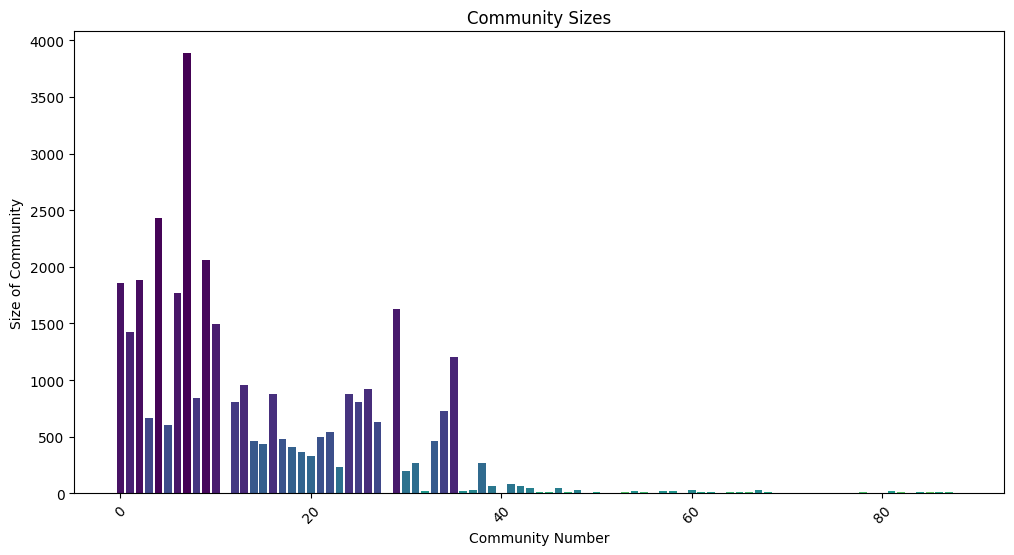

In [171]:
community_counts = Counter(partition.values())

# Extract community numbers and their sizes
community_sizes = list(community_counts.values())
community_numbers = list(community_counts.keys())


sorted_communities = sorted(zip(community_numbers, community_sizes), key=lambda x: x[1], reverse=True)
sorted_community_numbers, sorted_community_sizes = zip(*sorted_communities)


plt.figure(figsize=(12, 6))
colors = plt.cm.viridis(np.linspace(0, 1, len(sorted_community_numbers)))
plt.bar(sorted_community_numbers, sorted_community_sizes, color=colors)
plt.title('Community Sizes')
plt.xlabel('Community Number')
plt.ylabel('Size of Community')
plt.xticks(rotation=45)  
plt.show()

In [172]:
community_composition = {}

for community_id in set(partition.values()):
    # Get all nodes in this community
    community_nodes = [node for node, comm in partition.items() if comm == community_id]
    
    # Get the types of these nodes 
    node_types = [g.vs[node]['role'] for node in community_nodes]
    
    # Count the occurrences of each type
    type_counts = Counter(node_types)
    
    community_composition[community_id] = type_counts
    
composition_df = pd.DataFrame.from_dict(community_composition, orient='index').fillna(0)


composition_df.reset_index(inplace=True)
composition_df.rename(columns={'index': 'Community'}, inplace=True)

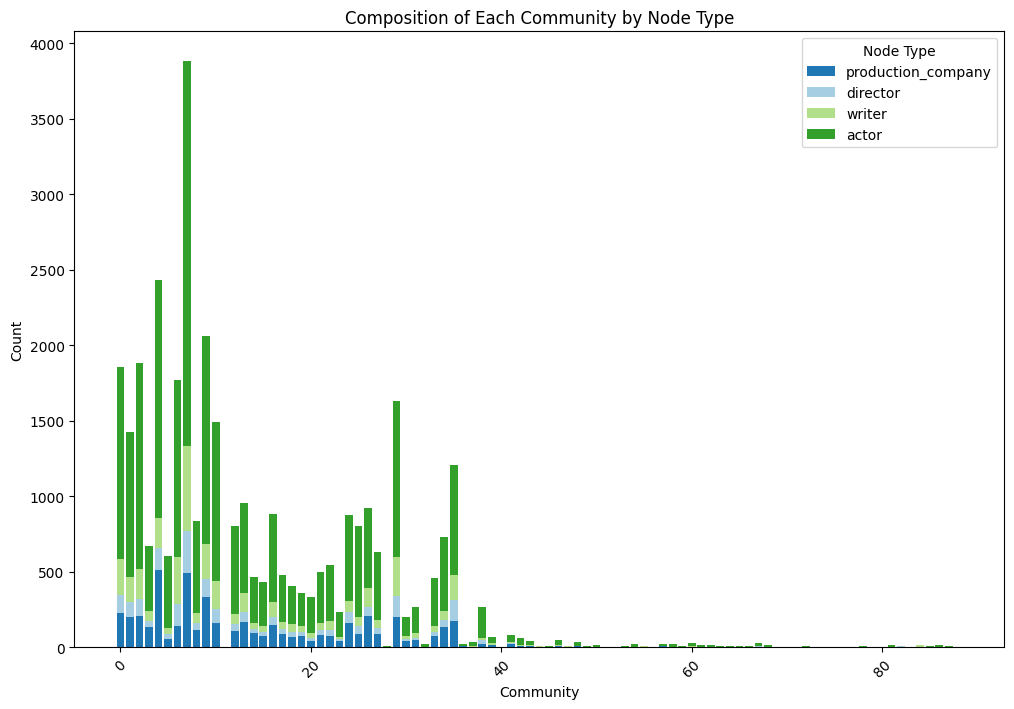

In [173]:
# Converting dictionary to DataFrame
composition_df = pd.DataFrame(composition_df)

plt.figure(figsize=(12, 8))

bottom_pos = [0] * len(composition_df)


colors = ['#1f78b4', '#a6cee3', '#b2df8a', '#33a02c']  

# Iterate through each node type and stack them
for i, node_type in enumerate(composition_df.columns[1:]):
    plt.bar(composition_df['Community'], composition_df[node_type], bottom=bottom_pos, color=colors[i], label=node_type)
    bottom_pos = [bottom + height for bottom, height in zip(bottom_pos, composition_df[node_type])]

plt.title('Composition of Each Community by Node Type')
plt.xlabel('Community')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Node Type')

plt.show()

In [174]:
# Set thresholds for minimum numbers
MIN_ACTORS = 50  
MIN_CREW = 20  


# Filter out communities that do not meet the thresholds
filtered_composition_df = composition_df[
    (composition_df['actor'] >= MIN_ACTORS) &
    (composition_df['director'] >= MIN_CREW) &
    (composition_df['writer'] >= MIN_CREW) &
    (composition_df['production_company'] >= MIN_CREW)
]

filtered_composition_df.head()

,Community,production_company,director,writer,actor
0,0,226,118,240.0,1275
1,1,201,100,168.0,958
2,2,207,111,200.0,1366
3,3,133,42,63.0,430
4,4,515,141,201.0,1573


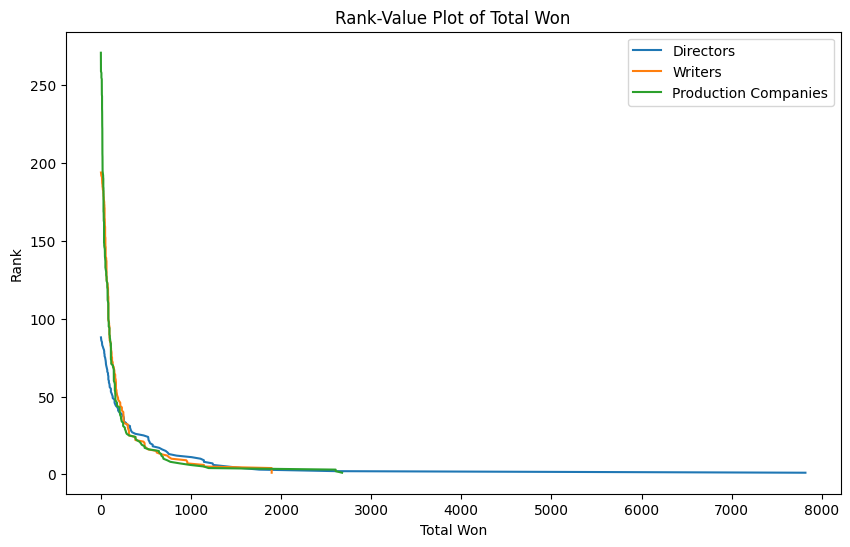

In [175]:
total_won_directors = director_awards['total_won']
total_won_writers = writers_awards['total_won']
total_won_production = production_companies_awards['total_won']

# Removing zero values for the plot
total_won_directors = total_won_directors[total_won_directors > 0]
total_won_writers = total_won_writers[total_won_writers > 0]
total_won_production = total_won_production[total_won_production > 0]

# Sorting the data in descending order
sorted_directors = np.sort(total_won_directors)[::-1]
sorted_writers = np.sort(total_won_writers)[::-1]
sorted_production = np.sort(total_won_production)[::-1]

# Regular plot (without log scale)
plt.figure(figsize=(10, 6))

# Plotting each category
plt.plot(sorted_directors, np.arange(1, len(sorted_directors) + 1), label='Directors')
plt.plot(sorted_writers, np.arange(1, len(sorted_writers) + 1), label='Writers')
plt.plot(sorted_production, np.arange(1, len(sorted_production) + 1), label='Production Companies')

plt.xlabel('Total Won')
plt.ylabel('Rank')
plt.title('Rank-Value Plot of Total Won')
plt.legend()
plt.show()

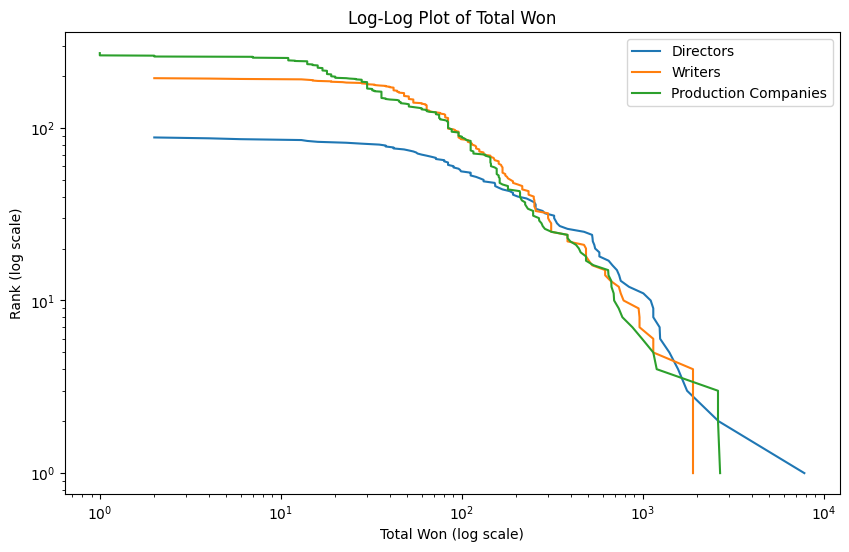

In [176]:
# Log-log plot
plt.figure(figsize=(10, 6))

# Plotting each category
plt.loglog(np.sort(total_won_directors)[::-1], np.arange(1, len(total_won_directors)+1), label='Directors')
plt.loglog(np.sort(total_won_writers)[::-1], np.arange(1, len(total_won_writers)+1), label='Writers')
plt.loglog(np.sort(total_won_production)[::-1], np.arange(1, len(total_won_production)+1), label='Production Companies')

plt.xlabel('Total Won (log scale)')
plt.ylabel('Rank (log scale)')
plt.title('Log-Log Plot of Total Won')
plt.legend()
plt.show()

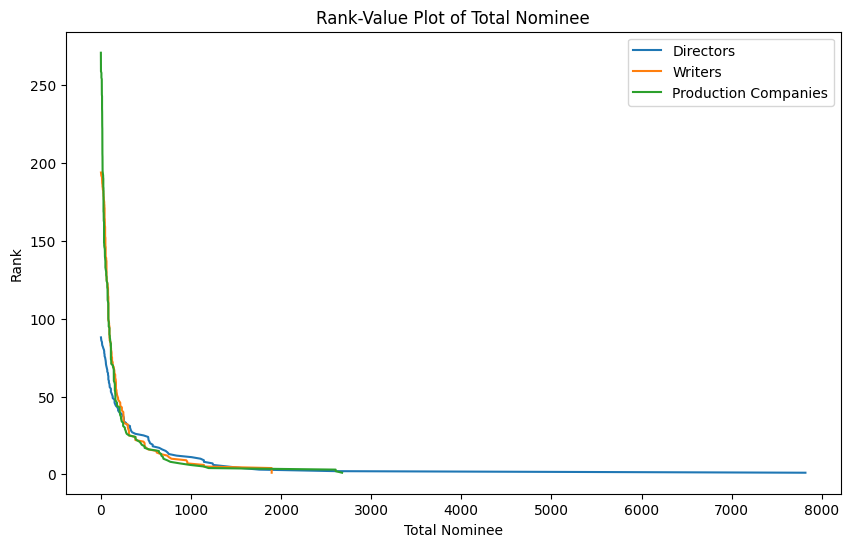

In [177]:
total_nominee_directors = director_awards['total_nominee']
total_nominee_writers = writers_awards['total_nominee']
total_nominee_production = production_companies_awards['total_nominee']

# Removing zero values for the plot
total_nominee_directors = total_won_directors[total_nominee_directors > 0]
total_nominee_writers = total_won_writers[total_nominee_writers > 0]
total_nominee_production = total_won_production[total_nominee_production > 0]

# Sorting the data in descending order
sorted_directors = np.sort(total_nominee_directors)[::-1]
sorted_writers = np.sort(total_nominee_writers)[::-1]
sorted_production = np.sort(total_nominee_production)[::-1]

# Regular plot (without log scale)
plt.figure(figsize=(10, 6))

# Plotting each category
plt.plot(sorted_directors, np.arange(1, len(sorted_directors) + 1), label='Directors')
plt.plot(sorted_writers, np.arange(1, len(sorted_writers) + 1), label='Writers')
plt.plot(sorted_production, np.arange(1, len(sorted_production) + 1), label='Production Companies')

plt.xlabel('Total Nominee')
plt.ylabel('Rank')
plt.title('Rank-Value Plot of Total Nominee')
plt.legend()
plt.show()

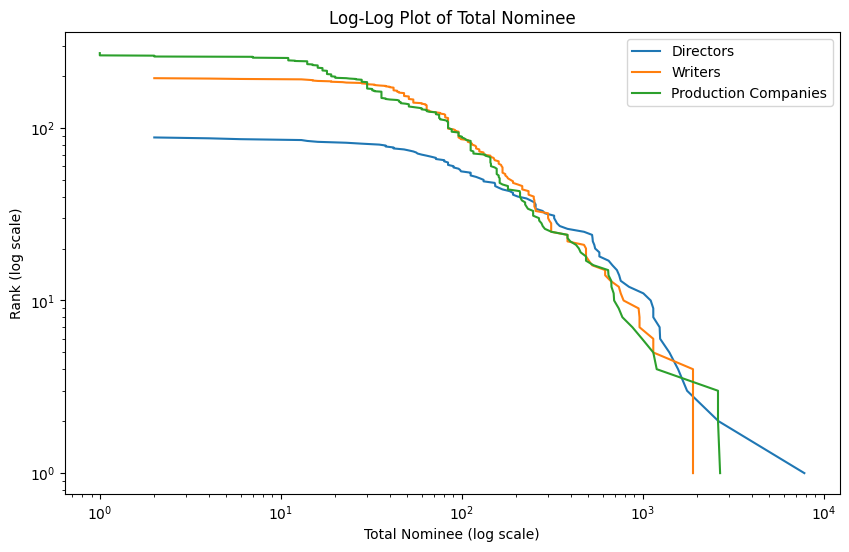

In [178]:
# Log-log plot
plt.figure(figsize=(10, 6))

# Plotting each category
plt.loglog(np.sort(total_nominee_directors)[::-1], np.arange(1, len(total_nominee_directors)+1), label='Directors')
plt.loglog(np.sort(total_nominee_writers)[::-1], np.arange(1, len(total_nominee_writers)+1), label='Writers')
plt.loglog(np.sort(total_nominee_production)[::-1], np.arange(1, len(total_nominee_production)+1), label='Production Companies')

plt.xlabel('Total Nominee (log scale)')
plt.ylabel('Rank (log scale)')
plt.title('Log-Log Plot of Total Nominee')
plt.legend()
plt.show()

When plotting the distribution patterns of total awards won and total award nominations in the film industry, both normal and logarithmic transformations were applied to the data. The resulting distributions exhibited a right-skewed pattern, closely aligning with a power-law distribution (will use gmean or median).

In [179]:
# Initialize dictionaries to store the results
avg_won = {'director': [], 'writer': [], 'production_company': []}
avg_nominee = {'director': [], 'writer': [], 'production_company': []}
#communities = sorted(set(partition.values()))
communities = sorted(set(filtered_composition_df['Community'].unique()))
shift_constant= 0.001

# Calculate the geometric means for each community
for community_id in communities:
    for node_type in ['director', 'writer', 'production_company']:
        # Filter nodes in the community of the specific type
        nodes = [node for node in g.vs if node['role'] == node_type and partition.get(node.index) == community_id]
        # Get the 'total won' and 'total nominee' values
        total_won = [node['total_won'] for node in nodes]
        total_nominee = [node['total_nominee'] for node in nodes]
        # Shift values by a small constant and calculate the geometric mean
        shifted_won = [x + shift_constant for x in total_won]
        shifted_nominee = [x + shift_constant for x in total_nominee]

        avg_won[node_type].append(gmean(shifted_won) if total_won else 0)
        avg_nominee[node_type].append(gmean(shifted_nominee) if total_nominee else 0)

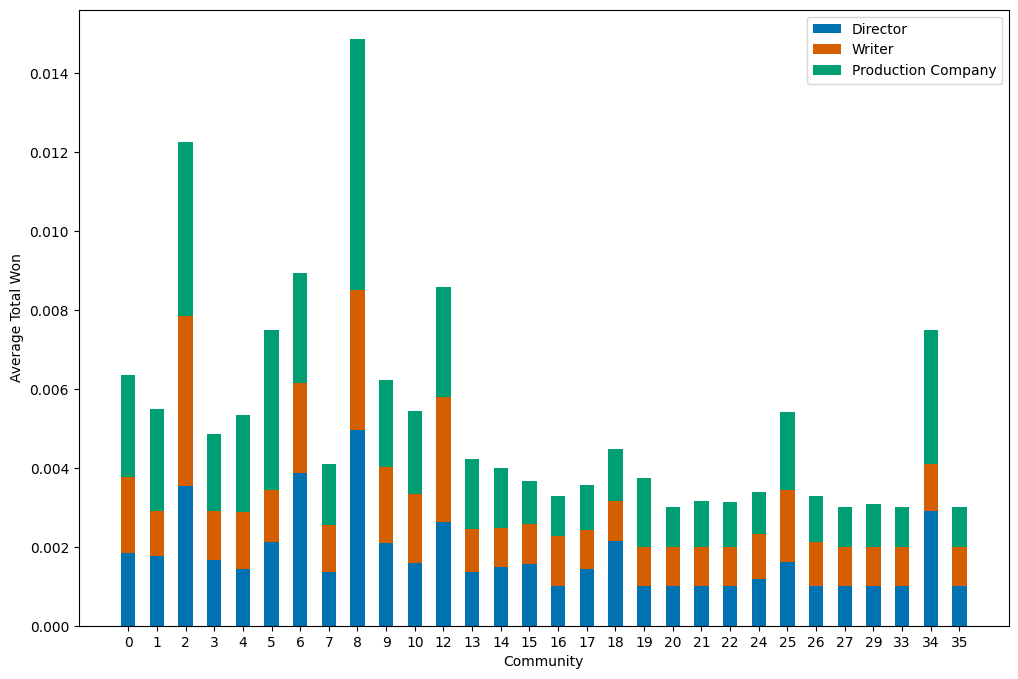

In [180]:
director_won = [avg_won['director'][i] for i in  range(len(communities))]
writer_won = [avg_won['writer'][i] for i in  range(len(communities))]
production_company_won = [avg_won['production_company'][i] for i in  range(len(communities))]


plt.figure(figsize=(12, 8))


index = np.arange(len(communities))
bar_width = 0.5  


plt.bar(index, director_won, bar_width, color='#0072B2', label='Director')  
plt.bar(index, writer_won, bar_width, color='#D55E00', bottom=director_won, label='Writer')  
plt.bar(index, production_company_won, bar_width, color='#009E73', bottom=np.array(director_won) + np.array(writer_won), label='Production Company')

plt.xlabel('Community')
plt.ylabel('Average Total Won')
plt.xticks(index, communities)
plt.legend()

plt.show()

Given the relatively small y-axis scale in the chart, we observe that most communities have low geometric mean totals, with many likely having zero awards. This could be due to the competitive nature of the industry, where awards are concentrated among a few successful entities.

To gain a clearer understanding, our next step is to examine the proportion of awards distributed within these communities. Analyzing proportions will help account for the prevalence of zero-award cases and provide a more nuanced view of how awards are shared among different professional roles in various communities.

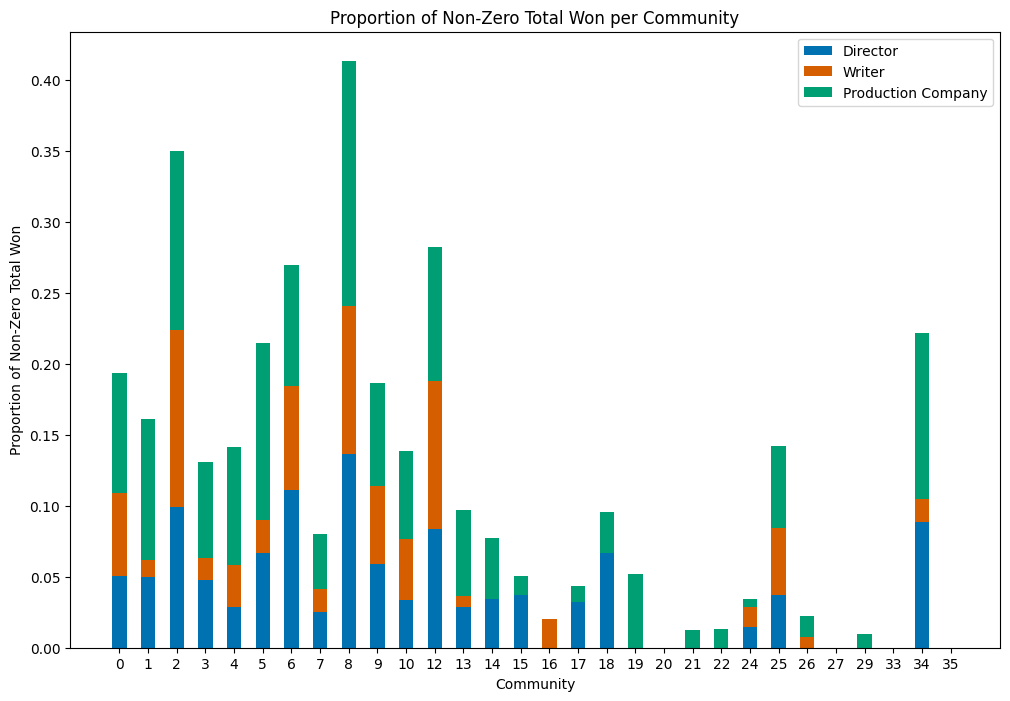

In [181]:
prop_non_zero_won = {'director': [], 'writer': [], 'production_company': []}
prop_non_zero_nominee = {'director': [], 'writer': [], 'production_company': []}

for community_id in communities:
    for node_type in ['director', 'writer', 'production_company']:
        nodes = [node for node in g.vs if node['role'] == node_type and partition.get(node.index) == community_id]
        total_won = [node['total_won'] for node in nodes]
        total_nominee = [node['total_nominee'] for node in nodes]
        
        # Calculate the proportion of non-zero values
        non_zero_won_count = len([x for x in total_won if x > 0])
        non_zero_nominee_count = len([x for x in total_nominee if x > 0])
        prop_non_zero_won[node_type].append(non_zero_won_count / len(total_won) if len(total_won) > 0 else 0)
        prop_non_zero_nominee[node_type].append(non_zero_nominee_count / len(total_nominee) if len(total_nominee) > 0 else 0)




director_won_prop = [prop_non_zero_won['director'][i] for i in range(len(communities))]
writer_won_prop = [prop_non_zero_won['writer'][i] for i in range(len(communities))]
prod_company_won_prop = [prop_non_zero_won['production_company'][i] for i in range(len(communities))]


plt.figure(figsize=(12, 8))


index = np.arange(len(communities))
bar_width = 0.5  


plt.bar(index, director_won_prop, bar_width, color='#0072B2', label='Director')
plt.bar(index, writer_won_prop, bar_width, color='#D55E00', bottom=director_won_prop, label='Writer')
plt.bar(index, prod_company_won_prop, bar_width, color='#009E73', bottom=np.array(director_won_prop) + np.array(writer_won_prop), label='Production Company')

plt.xlabel('Community')
plt.ylabel('Proportion of Non-Zero Total Won')
plt.title('Proportion of Non-Zero Total Won per Community')
plt.xticks(index, communities)
plt.legend()

plt.show()

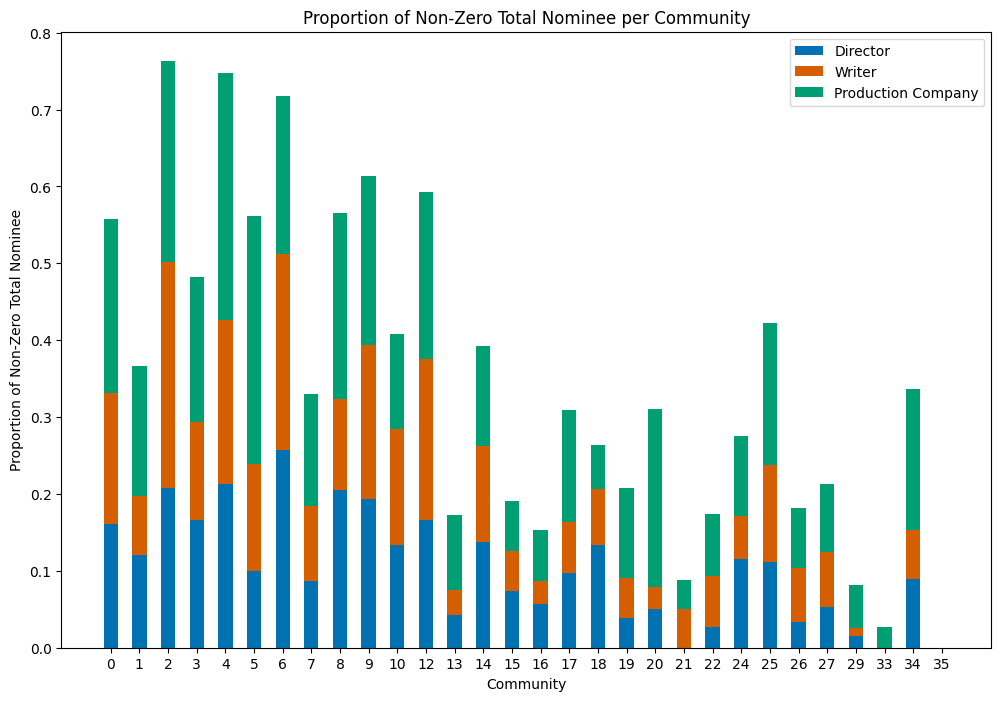

In [182]:
director_nominee_prop = [prop_non_zero_nominee['director'][i] for i in range(len(communities))]
writer_nominee_prop = [prop_non_zero_nominee['writer'][i] for i in range(len(communities))]
prod_company_nominee_prop = [prop_non_zero_nominee['production_company'][i] for i in range(len(communities))]


plt.figure(figsize=(12, 8))


index = np.arange(len(communities))
bar_width = 0.5  


plt.bar(index, director_nominee_prop, bar_width, color='#0072B2', label='Director')
plt.bar(index, writer_nominee_prop, bar_width, color='#D55E00', bottom=director_nominee_prop, label='Writer')
plt.bar(index, prod_company_nominee_prop, bar_width, color='#009E73', bottom=np.array(director_nominee_prop) + np.array(writer_nominee_prop), label='Production Company')

plt.xlabel('Community')
plt.ylabel('Proportion of Non-Zero Total Nominee')
plt.title('Proportion of Non-Zero Total Nominee per Community')
plt.xticks(index, communities)
plt.legend()

plt.show()

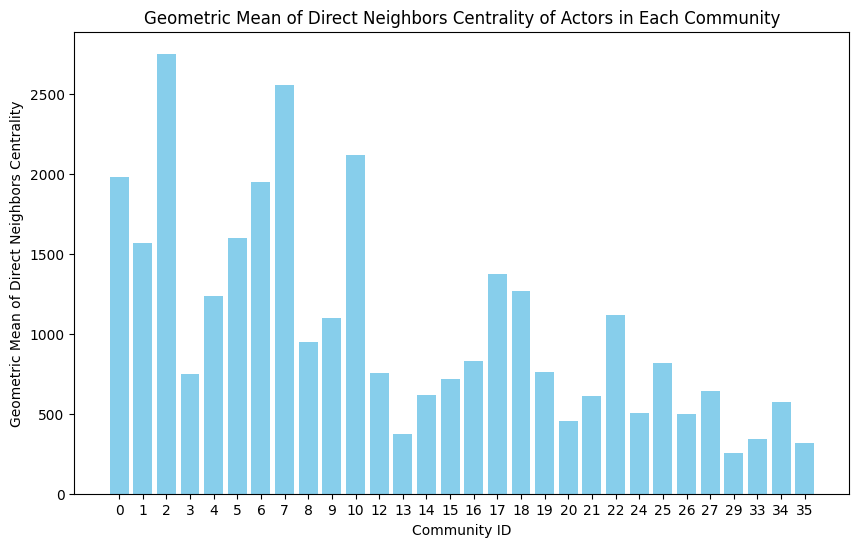

In [183]:
avg_actors_second_degree_geom = []

# Iterate through each community
for community_id in communities:
    # Filter actors in the community and collect their neighbors centrality scores
    centrality_scores = [node['direct_neighbors_centrality'] for node in g.vs if node['role'] == 'actor' and partition.get(node.index) == community_id]

    # Calculate geometric mean of centrality scores
    if centrality_scores:
        avg_geom = gmean([score for score in centrality_scores if score > 0])  
    else:
        avg_geom = 0  # Default value if no actors or all scores are zero

    avg_actors_second_degree_geom.append(avg_geom)


plt.figure(figsize=(10, 6))  
plt.bar(range(len(communities)), avg_actors_second_degree_geom, color='skyblue')


plt.title('Geometric Mean of Direct Neighbors Centrality of Actors in Each Community')
plt.xlabel('Community ID')
plt.ylabel('Geometric Mean of Direct Neighbors Centrality')
plt.xticks(range(len(communities)), communities)  

plt.show()

In [184]:
# Group by 'Freebase actor ID' and calculate the average box office revenue and ratings
actor_avg_metrics = actors_movies_crew_df.groupby('Freebase actor ID').agg({
    'boxOffice_revenue': 'mean',
    'averageRating': 'mean',
    'numVotes':'mean',
    'freebase_id': 'nunique' 
}).reset_index()


actor_avg_metrics.rename(columns={'boxOffice_revenue': 'avg_box_office', 'averageRating': 'avg_rating', 'numVotes':'avg_vote_count'}, inplace=True)

In [185]:
# Create a mapping 
actor_community_map = {node['name']: node['community'] for node in g.vs if node['role'] == 'actor'}
actor_second_degree_map = {node['name']: node['direct_neighbors_centrality'] for node in g.vs if node['role'] == 'actor'}

actor_avg_metrics['community'] = actor_avg_metrics['Freebase actor ID'].map(actor_community_map)
actor_avg_metrics['direct_neighbors_centrality'] = actor_avg_metrics['Freebase actor ID'].map(actor_second_degree_map )
# Only filtered communities
actor_avg_metrics = actor_avg_metrics[actor_avg_metrics['community'].isin(communities)]

In [186]:
# Group by community and calculate metrics
community_avg_metrics = actor_avg_metrics.groupby('community').agg({
    'avg_box_office': 'mean',
    'avg_rating': 'mean',
    'avg_vote_count': 'mean',
    'direct_neighbors_centrality': gmean_series,  
    'freebase_id': 'sum'
}).reset_index()

In [187]:
# Create a DataFrame from the metrics
community_analysis_df = pd.DataFrame({
    'community': communities,
    'avg_box_office': community_avg_metrics['avg_box_office'],
    'avg_rating': community_avg_metrics['avg_rating'],
    'avg_vote_count': community_avg_metrics['avg_vote_count'],
    'director_won_prop': prop_non_zero_won['director'],
    'director_nominee_prop': prop_non_zero_nominee['director'],
    'writer_won_prop': prop_non_zero_won['writer'],
    'writer_nominee_prop': prop_non_zero_nominee['writer'],
    'prod_company_won_prop': prop_non_zero_won['production_company'],
    'prod_company_nominee_prop': prop_non_zero_nominee['production_company'],
    'direct_neighbors_centrality':community_avg_metrics['direct_neighbors_centrality'],
    'movies_count':community_avg_metrics['freebase_id']
})


community_analysis_df.fillna(0, inplace=True)

In [188]:
# Group data by community
community_avg_metrics_data = actor_avg_metrics.groupby('community')

# Perform ANOVA for each metric
perform_anova(community_avg_metrics_data, 'avg_rating')
perform_anova(community_avg_metrics_data, 'avg_box_office')
perform_anova(community_avg_metrics_data, 'avg_vote_count')
perform_anova(community_avg_metrics_data, 'direct_neighbors_centrality')

ANOVA for avg_rating:
  F-statistic: 86.3778076371844, P-value: 0.0
  There is a significant difference between the communities.

ANOVA for avg_box_office:
  F-statistic: 144.9585510491829, P-value: 0.0
  There is a significant difference between the communities.

ANOVA for avg_vote_count:
  F-statistic: 83.62566228663422, P-value: 0.0
  There is a significant difference between the communities.

ANOVA for direct_neighbors_centrality:
  F-statistic: 99.32058407224876, P-value: 0.0
  There is a significant difference between the communities.



#### Community Analysis
Our recent visualizations and tests delve into the dynamics of different communities within the film industry, focusing on awards won, nominations, and the network centrality of crew. By examining the distribution of these attributes across various communities, we aim to understand whether being part of a particular community is associated with shared characteristics or influences these properties.


The patterns observed in these plots raise intriguing questions: Are the similarities within a community a result of shared characteristics or the influence of being part of that community? This analysis sets the stage for further investigation into the causal relationships within the film industry's network, offering a foundation for understanding how community dynamics might shape an individual's or a group's success and connectivity in the industry.

In [189]:
weights = {'director': 1/3, 'writer': 1/3, 'production_company': 1/3}

# Calculate weighted average and add as a new column
community_analysis_df['weighted_avg_awards_won'] = (
    community_analysis_df['director_won_prop'] * weights['director'] +
    community_analysis_df['writer_won_prop'] * weights['writer'] +
    community_analysis_df['prod_company_won_prop'] * weights['production_company']
)
community_analysis_df['weighted_avg_awards_nominee'] = (
    community_analysis_df['director_nominee_prop'] * weights['director'] +
    community_analysis_df['writer_nominee_prop'] * weights['writer'] +
    community_analysis_df['prod_company_nominee_prop'] * weights['production_company']
)

In [190]:
analyze_correlation(community_analysis_df['weighted_avg_awards_won'], community_analysis_df['avg_box_office'])

Pearson correlation:  PearsonRResult(statistic=0.4002129963647943, pvalue=0.02842078685330759)
Spearman correlation:  SignificanceResult(statistic=0.501782048317099, pvalue=0.0047254901594739485)
The Pearson correlation is significant.
The Spearman correlation is significant.


In [191]:
analyze_correlation(community_analysis_df['weighted_avg_awards_nominee'], community_analysis_df['avg_box_office'])

Pearson correlation:  PearsonRResult(statistic=0.4931171774671486, pvalue=0.00562631746213249)
Spearman correlation:  SignificanceResult(statistic=0.47319243604004446, pvalue=0.008266780553783817)
The Pearson correlation is significant.
The Spearman correlation is significant.


In [192]:
analyze_correlation(community_analysis_df['avg_box_office'], community_analysis_df['direct_neighbors_centrality'])

Pearson correlation:  PearsonRResult(statistic=0.8309398584098696, pvalue=1.3141655067790406e-08)
Spearman correlation:  SignificanceResult(statistic=0.8705228031145716, pvalue=4.0585857280067005e-10)
The Pearson correlation is significant.
The Spearman correlation is significant.


In [193]:
features_to_standardize = ['direct_neighbors_centrality', 'weighted_avg_awards_won', 'weighted_avg_awards_nominee','movies_count']


standardized_feature_names = [f"{feature}_std" for feature in features_to_standardize]

# Standardizing the features
scaler = StandardScaler()
community_analysis_df[standardized_feature_names] = scaler.fit_transform(community_analysis_df[features_to_standardize])

In [194]:
# Target variable: avg_rating
X = community_analysis_df[standardized_feature_names]
y_rating = community_analysis_df['avg_rating']
X = sm.add_constant(X)
model_rating = sm.OLS(y_rating, X).fit()
print(model_rating.summary())

                            OLS Regression Results                            
Dep. Variable:             avg_rating   R-squared:                       0.376
Model:                            OLS   Adj. R-squared:                  0.276
Method:                 Least Squares   F-statistic:                     3.759
Date:                Fri, 22 Dec 2023   Prob (F-statistic):             0.0158
Time:                        19:56:08   Log-Likelihood:               0.022264
No. Observations:                  30   AIC:                             9.955
Df Residuals:                      25   BIC:                             16.96
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

In [195]:
# Target variable: avg_box_office
y_box_office = community_analysis_df['avg_box_office']
model_box_office = sm.OLS(y_box_office, X).fit()
print(model_box_office.summary())

                            OLS Regression Results                            
Dep. Variable:         avg_box_office   R-squared:                       0.691
Model:                            OLS   Adj. R-squared:                  0.642
Method:                 Least Squares   F-statistic:                     13.99
Date:                Fri, 22 Dec 2023   Prob (F-statistic):           4.03e-06
Time:                        19:56:08   Log-Likelihood:                -553.49
No. Observations:                  30   AIC:                             1117.
Df Residuals:                      25   BIC:                             1124.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

In [196]:
# Target variable: avg_vote_count
y_vote_count = community_analysis_df['avg_vote_count']
model_vote_count = sm.OLS(y_vote_count, X).fit()
print(model_vote_count.summary())

                            OLS Regression Results                            
Dep. Variable:         avg_vote_count   R-squared:                       0.731
Model:                            OLS   Adj. R-squared:                  0.689
Method:                 Least Squares   F-statistic:                     17.03
Date:                Fri, 22 Dec 2023   Prob (F-statistic):           7.38e-07
Time:                        19:56:08   Log-Likelihood:                -347.50
No. Observations:                  30   AIC:                             705.0
Df Residuals:                      25   BIC:                             712.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

We've performed three separate OLS regression analyses with different dependent variables (`avg_rating`, `avg_box_office`, and `avg_vote_count`) and the same set of independent variables (`direct_neighbors_centrality_std`, `weighted_avg_awards_won_std`, ,`weighted_avg_awards_nominee_std` and `movies_count`). Let's interpret each model's results:

#### 1. Regression for `avg_rating`:
   - **R-squared**: 0.376 - The model explains 37.6% of the variability in the average rating.
   - **Coefficients**:
     - `direct_neighbors_centrality_std`: Negative coefficient (-0.2778) suggests that an increase in centrality (connectedness with experienced crew) is associated with a decrease in average rating. This could indicate that movies with more central and experienced crews might not always receive higher ratings, possibly due to higher expectations or diverse voter opinions.
     - `weighted_avg_awards_won_std`: Not significant (maybe captured in nominations).
     - `weighted_avg_awards_nominee_std`: Positive coefficient indicates that being nominated is associated with higher ratings.

#### 2. Regression for `avg_box_office`:
   - **R-squared**: 0.691 - The model explains 69.1% of the variability in average box office revenue.
   - **Coefficients**:
     - `direct_neighbors_centrality_std`: Positive coefficient  indicates that higher centrality is strongly associated with higher box office revenue. This suggests that well-connected actors (with experienced crew) tend to appear in higher-grossing films.
     - `weighted_avg_awards_won_std`: Not statistically significant.
     - `weighted_avg_awards_nominee_std`: Not statistically significant.

#### 3. Regression for `avg_vote_count`:
   - **R-squared**: 0.731 - The model explains 73.1% of the variability in average vote count.
   - **Coefficients**:
     - `direct_neighbors_centrality_std`: Positive coefficient,suggesting that higher centrality correlates with a higher vote count. Films with well-connected actors may attract more attention and hence more votes.
     - `weighted_avg_awards_won_std`: Not statistically significant.
     - `weighted_avg_awards_nominee_std`: Not statistically significant.

#### General Interpretation:
- The results of the regression analyses present an intriguing picture of the factors influencing movie success. A notable observation is the negative coefficient for crew network centrality in relation to average ratings. This could be interpreted as a reflection of a broader audience base: as a movie gains more popularity (as indicated by an increase in vote count, where we see a positive correlation with crew centrality), it might attract a more diverse audience. This diverse audience could potentially be more critical or have varying tastes, which might explain why higher centrality does not always translate to higher ratings.
- On the other hand, the positive correlation between awards nominations and average ratings suggests that critical acclaim does have a noticeable impact on the perceived quality of a movie. Nominations seems to be a strong indicator of success in terms of ratings, implying that critically acclaimed films, often associated with experienced and well-connected crews, are likely to be rated higher. This highlights the importance of critical recognition in enhancing a movie's reputation for quality.
- In summary, while a well-connected crew contributes to broader audience engagement and commercial success, it doesn’t invariably lead to higher critical ratings. Meanwhile, awards can bolster a film's standing in terms of ratings, underscoring the different dimensions of success in the film industry.

#### Note:
- The addition of movies_count_std (avg movies in communities) as a control factor in these analyses helps contextualize the influence of an actor's career volume on their success metrics. It reveals that while the number of movies an actor participates in is a factor, the nature and quality of their network and collaborations play a more significant role. The findings highlight the intricate balance between different aspects of success in the film industry, where the crew's network and experience play a crucial role.

#### Caution:
- Correlation does not imply causation. The observed relationships might be influenced by other factors not included in the model.

In [197]:
# Determine the range of years in your dataset
actors_movies_crew_df['year'] = actors_movies_crew_df['year'].astype(int)
start_year = actors_movies_crew_df['year'].min()
end_year = actors_movies_crew_df['year'].max()


# Initialize dictionaries to store counts of collaborations before and after
collaborations_before = {}
collaborations_after = {}

# Dictionary to store first year of collaboration with acclaimed entities for each actor
first_collaboration_year = {}

movie_crew_award_first = {}

# Dictionary to store unique movies worked on by each actor
movies_worked_on = {}

for year in range(start_year, end_year + 1):
    # Filter the DataFrame for the specific year
    yearly_data = actors_movies_crew_df[actors_movies_crew_df['year'] == year]
    
    for _, row in yearly_data.iterrows():
        actor = row['Freebase actor ID']
        director = row['directors']
        writer = row['writers']
        movie = row['freebase_id']
        production_company = row['production_companies']

        # Check if this is the first significant collaboration for the actor
        if actor not in first_collaboration_year:
            if (director_awards.loc[director, 'total_won'] > 0 and director_awards.loc[director, 'total_nominee'] > 10) and \
               (writers_awards.loc[writer, 'total_won'] > 0 and writers_awards.loc[writer, 'total_nominee'] > 10) and \
               (production_companies_awards.loc[production_company, 'total_won'] > 0 and \
                production_companies_awards.loc[production_company, 'total_nominee'] > 10):

                first_collaboration_year[actor] = year
                movie_crew_award_first[actor] = movie
                
        # Increment counts based on whether the actor is in the first_collaboration_year dictionary
        if actor not in collaborations_before:
            collaborations_before[actor] = 0
            collaborations_after[actor] = 0
            movies_worked_on[actor] = set()  # Initialize a set to store unique movies
        
        if actor not in first_collaboration_year:
            # Increment collaborations_before for each unique movie
            if movie not in movies_worked_on[actor]:
                collaborations_before[actor] += 1
                movies_worked_on[actor].add(movie)
        else:
            # Increment collaborations_after for each unique movie
            if movie not in movies_worked_on[actor]:
                collaborations_after[actor] += 1
                movies_worked_on[actor].add(movie)

# Create a DataFrame from the collaboration data
collaboration_df = pd.DataFrame({
    'Actor': list(first_collaboration_year.keys()),
    'First_Collaboration_Year': list(first_collaboration_year.values()),
    'Collaborations_Before_First_Collab': [collaborations_before.get(actor, 0) for actor in first_collaboration_year.keys()],
    'Collaborations_After_First_Collab': [collaborations_after.get(actor, 0) for actor in first_collaboration_year.keys()]
})


collaboration_df

,Actor,First_Collaboration_Year,Collaborations_Before_First_Collab,Collaborations_After_First_Collab
0,/m/0d688p,2001,0,1
1,/m/0151w_,2001,0,19
2,/m/01kgv4,2001,0,15
3,/m/01pk8v,2001,1,11
4,/m/018ygt,2001,1,18
...,...,...,...,...
2501,/m/0hpg8c0,2013,1,0
2502,/m/0hpg890,2013,1,0
2503,/m/0hpg89t,2013,1,0
2504,/m/02y_2y,2013,18,0


In [198]:
actor_crew_degrees = {}
for actor in unique_actors:
        actor_idx = g.vs.find(name=actor).index
        actor_crew_degree = g.vs[actor_idx]['direct_neighbors_centrality']
        actor_crew_degrees[actor] = actor_crew_degree

In [199]:
# Extract actor IDs from the first_collaboration_year dictionary
first_collab_actors = set(first_collaboration_year.keys())

# Group 1: Actors in the first_collaboration_year dataset
group1_degrees = [degree for actor, degree in actor_crew_degrees.items() if actor in first_collab_actors]

# Group 2: Actors not in the first_collaboration_year dataset
group2_degrees = [degree for actor, degree in actor_crew_degrees.items() if actor not in first_collab_actors]

# Calculate descriptive statistics ( median)
median_group1 = np.median(group1_degrees)
median_group2 = np.median(group2_degrees)

stat, p = mannwhitneyu(group1_degrees, group2_degrees)

# Check which group has a higher median
if p < 0.05:  
    print("Significant difference between groups.")
    if median_group1 > median_group2:
        print("Group 1 (Actor collaborated with aclaimed crew) has a higher median degree.")
    else:
        print("Group 2  has a higher median degree.")
else:
    print("No significant difference between groups.")


print(f"Median Neighbors Degree Group 1: {median_group1}")
print(f"Median Neighbors Degree Group 2: {median_group2}")

Significant difference between groups.
Group 1 (Actor collaborated with aclaimed crew) has a higher median degree.
Median Neighbors Degree Group 1: 4031.0
Median Neighbors Degree Group 2: 979.0


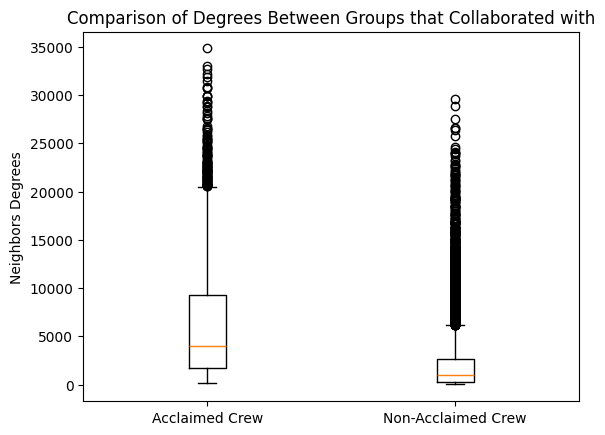

In [200]:
data_to_plot = [group1_degrees, group2_degrees]

plt.boxplot(data_to_plot, labels=['Acclaimed Crew', 'Non-Acclaimed Crew'])
plt.title('Comparison of Degrees Between Groups that Collaborated with')
plt.ylabel('Neighbors Degrees')
plt.show()

In [201]:
percentiles_to_calculate = [25, 50, 75]

# Calculate and print percentiles for Group 1
percentiles_group1 = np.percentile(group1_degrees, percentiles_to_calculate)
print("Percentiles for Group 1  (Actor collaborated with aclaimed crew):")
for percentile, value in zip(percentiles_to_calculate, percentiles_group1):
    print(f"  {percentile}th Percentile: {value}")

# Calculate and print percentiles for Group 2
percentiles_group2 = np.percentile(group2_degrees, percentiles_to_calculate)
print("\nPercentiles for Group 2:")
for percentile, value in zip(percentiles_to_calculate, percentiles_group2):
    print(f"  {percentile}th Percentile: {value}")

Percentiles for Group 1  (Actor collaborated with aclaimed crew):
  25th Percentile: 1755.0
  50th Percentile: 4031.0
  75th Percentile: 9260.0

Percentiles for Group 2:
  25th Percentile: 281.0
  50th Percentile: 979.0
  75th Percentile: 2647.25


Based on the regression analysis conducted prior to the test above, which indicated the significance of neighbor centrality in determining an actor's success, we can infer some compelling implications. The regression results showed a relationship between an actor's success (measured in terms of ratings, box office revenue, and vote counts of movies they acted in) and the degree of their direct neighbors, which represents the network centrality and influence of the crews they work with.

Given these insights, the subsequent finding that actors who have collaborated with award-winning or nominated crews (Group 1) exhibit higher median network centrality than those who have not (Group 2) becomes particularly significant. This suggests that:

1. **Potential for Greater Success**: Actors in Group 1, with their higher degree of network centrality, might have better access to influential and resourceful networks in the film industry. This can potentially lead to more successful outcomes in their careers, whether measured by critical acclaim, box office success, or popularity among audiences.

2. **Influence of High-Profile Collaborations**: Working with award-winning or nominated crews could open doors to more prestigious and high-quality projects, further enhancing an actor's network and, subsequently, their career prospects.


In conclusion, the initial regression analysis, combined with the test results, underscores the importance of an actor's professional network, particularly the benefits of collaborating with highly recognized and successful crew members. It paints a picture of the film industry where network strength and high-profile collaborations can have a tangible impact on an actor's career success.

### Careers Evolution

For this research question, we will delve into the evolution of an actor's career, with a specific focus on the genres of movies they participate in. This aspect of an actor's career trajectory can be intriguing, as it often reflects not only personal growth and changing artistic interests but also shifts in industry trends and audience expectations. As actors age, they may transition from one genre to another for various reasons. These shifts could be driven by a range of factors, including personal choice, typecasting, changes in the types of roles offered to them as they age, or even a strategic response to evolving trends within the film industry.

In the early stages of their careers, actors might be more inclined to experiment with different genres or take on roles that challenge them in various ways. This period is often characterized by a quest for establishing a foothold in the industry, where versatility and a wide range of roles can be advantageous. As actors establish themselves, certain patterns might emerge, reflecting their strengths or audience preferences. For instance, an actor known for compelling dramatic performances might increasingly find themselves sought after for similar roles.

In [202]:
actor_movies_df = actor_movies_df.explode('title')
actor_movies_genre_df = actor_movies_df.merge(movies_metadata_df, left_on='title', right_on='title', how='left')


In [203]:
actor_movies_genre_df["age_at_release"] = actor_movies_genre_df["release_date"].dt.year - actor_movies_genre_df["Actor birth year"]
actor_movies_genre_df["age_at_release"] = actor_movies_genre_df["age_at_release"].astype(float)
actor_movies_genre_df.head()

,Actor date of birth,Actor gender,Actor ethnicity,Actor name,Freebase actor ID,Actor birth year,title,freebase_id_x,id,freebase_id_y,release_date,boxOffice_revenue,runtime,language,country,genres,year,age_at_release
0,1958-08-26,F,NaN,Wanda De Jesus,/m/03wcfv7,1958.0,Ghosts of Mars,"[/m/03vyhn, /m/0809s7n, /m/0dg7mt, /m/04t8wq, ...",975900,/m/03vyhn,2001-08-24,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",2001.0,43.0
1,1958-08-26,F,NaN,Wanda De Jesus,/m/03wcfv7,1958.0,The Ministers,"[/m/03vyhn, /m/0809s7n, /m/0dg7mt, /m/04t8wq, ...",24767455,/m/0809s7n,2009-10-16,NaN,89.0,[English Language],[United States of America],"[Crime Fiction, Crime Thriller, Drama, Thrille...",2009.0,51.0
2,1958-08-26,F,NaN,Wanda De Jesus,/m/03wcfv7,1958.0,Almost a Woman,"[/m/03vyhn, /m/0809s7n, /m/0dg7mt, /m/04t8wq, ...",5337169,/m/0dg7mt,2001-01-01,NaN,90.0,"[English Language, Spanish Language]",[United States of America],"[Television movie, Biopic [feature], Docudrama...",2001.0,43.0
3,1958-08-26,F,NaN,Wanda De Jesus,/m/03wcfv7,1958.0,RoboCop 2,"[/m/03vyhn, /m/0809s7n, /m/0dg7mt, /m/04t8wq, ...",1330220,/m/04t8wq,1990-06-22,45681173.0,120.0,[English Language],[United States of America],"[Crime Fiction, Thriller, Science Fiction, Sup...",1990.0,32.0
4,1958-08-26,F,NaN,Wanda De Jesus,/m/03wcfv7,1958.0,Downtown,"[/m/03vyhn, /m/0809s7n, /m/0dg7mt, /m/04t8wq, ...",14686017,/m/03gt21w,1990-01-12,2346150.0,96.0,[English Language],[United States of America],"[Crime Fiction, Thriller, Buddy film, Action/A...",1990.0,32.0


In [204]:

# actor_movies_genre_df['genres'] = actor_movies_genre_df['genres'].apply(extract_items)
actor_movies_genre_df = actor_movies_genre_df.explode('genres')
actor_movies_genre_df.head()

,Actor date of birth,Actor gender,Actor ethnicity,Actor name,Freebase actor ID,Actor birth year,title,freebase_id_x,id,freebase_id_y,release_date,boxOffice_revenue,runtime,language,country,genres,year,age_at_release
0,1958-08-26,F,NaN,Wanda De Jesus,/m/03wcfv7,1958.0,Ghosts of Mars,"[/m/03vyhn, /m/0809s7n, /m/0dg7mt, /m/04t8wq, ...",975900,/m/03vyhn,2001-08-24,14010832.0,98.0,[English Language],[United States of America],Thriller,2001.0,43.0
0,1958-08-26,F,NaN,Wanda De Jesus,/m/03wcfv7,1958.0,Ghosts of Mars,"[/m/03vyhn, /m/0809s7n, /m/0dg7mt, /m/04t8wq, ...",975900,/m/03vyhn,2001-08-24,14010832.0,98.0,[English Language],[United States of America],Science Fiction,2001.0,43.0
0,1958-08-26,F,NaN,Wanda De Jesus,/m/03wcfv7,1958.0,Ghosts of Mars,"[/m/03vyhn, /m/0809s7n, /m/0dg7mt, /m/04t8wq, ...",975900,/m/03vyhn,2001-08-24,14010832.0,98.0,[English Language],[United States of America],Horror,2001.0,43.0
0,1958-08-26,F,NaN,Wanda De Jesus,/m/03wcfv7,1958.0,Ghosts of Mars,"[/m/03vyhn, /m/0809s7n, /m/0dg7mt, /m/04t8wq, ...",975900,/m/03vyhn,2001-08-24,14010832.0,98.0,[English Language],[United States of America],Adventure,2001.0,43.0
0,1958-08-26,F,NaN,Wanda De Jesus,/m/03wcfv7,1958.0,Ghosts of Mars,"[/m/03vyhn, /m/0809s7n, /m/0dg7mt, /m/04t8wq, ...",975900,/m/03vyhn,2001-08-24,14010832.0,98.0,[English Language],[United States of America],Supernatural,2001.0,43.0


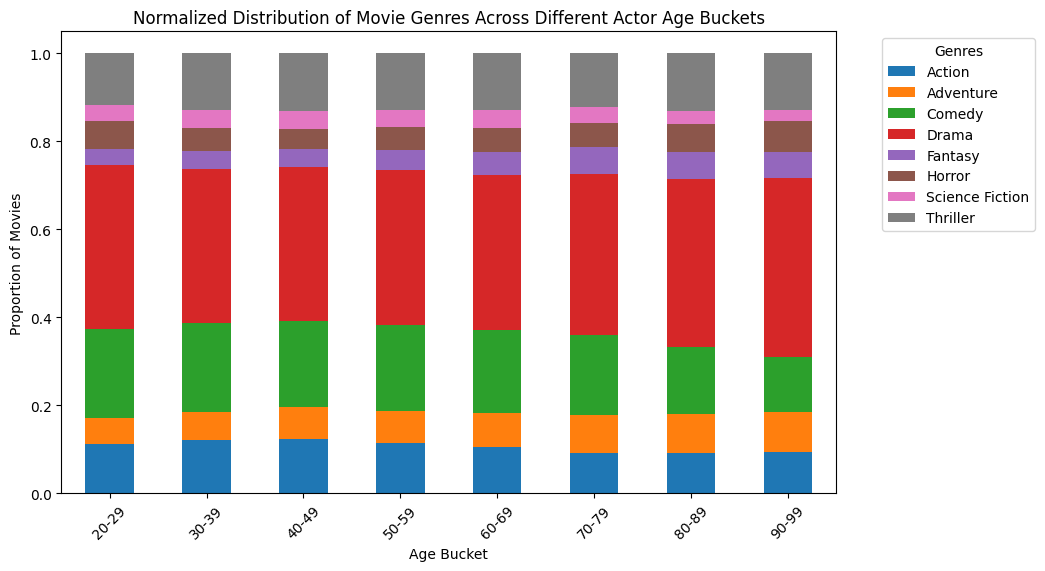

In [205]:
# List of relevant genres
relevant_genres = ['Thriller', 'Drama', 'Comedy', 'Horror', "Action", "Adventure", "Romance", "Science Fiction", "Fantasy"]

filtered_df = actor_movies_genre_df[actor_movies_genre_df['genres'].isin(relevant_genres)]

# Define age bins and labels
age_bins = [20, 30, 40, 50, 60, 70, 80, 90, 100]
age_labels = ['20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80-89', '90-99']

# Categorize age and explode genres
filtered_df['age_group'] = pd.cut(filtered_df['age_at_release'], bins=age_bins, labels=age_labels)
filtered_df = filtered_df.explode('genres')

# Group by age group and genres, then plot
genre_distribution_per_age_group = filtered_df.groupby(['age_group', 'genres']).size().unstack(fill_value=0)

normalized_genre_distribution = genre_distribution_per_age_group.div(genre_distribution_per_age_group.sum(axis=1), axis=0)

# Plotting the normalized data
normalized_genre_distribution.plot(kind='bar', stacked=True, figsize=(10,6))
plt.xlabel('Age Bucket')
plt.ylabel('Proportion of Movies')
plt.title('Normalized Distribution of Movie Genres Across Different Actor Age Buckets')
plt.xticks(rotation=45)
plt.legend(title='Genres', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

#### Analysis of Movie Genres and Actor Age Distribution

Analyzing the distribution of movie genres against the age of actors at the time of release reveals distinct patterns. 

**Drama Movies**
For *drama movies*, there's an observable increase in participation with the age of the actors. This trend might stem from the depth and complexity of dramatic roles, which older actors, with their wealth of experience and nuanced understanding of human emotions, are often more adept at portraying. Their life experience lends authenticity and gravitas to these roles, making them particularly effective in dramatic narratives.

**Fantasy Films**
In *fantasy films*, a similar increase is noted with older actors. This could be attributed to the fact that many fantasy narratives require seasoned, wise characters, like wizards or elders. Roles exemplified by Dumbledore in "Harry Potter" or Gandalf in "The Lord of the Rings" are prime examples. Older actors bring a believable sense of wisdom and historical depth to these characters, enhancing the storytelling.

**Comedy Films**
On the other hand, *comedy films* show a decrease in participation by older actors. This might be due to the physical demands of physical comedy, or the themes and situations in comedies that often resonate more with a younger demographic. Additionally, as the comedy genre evolves with changing cultural references and styles, younger actors may be perceived as more relatable to the target audience.

These trends highlight not just individual actor choices, but also broader industry practices and audience expectations, reflecting the dynamic interplay between career trajectories, industry trends, and cultural shifts.

Note: For the purpose of readability, in the above plot, we tried to only include some of the most prominent genres in the film industry. The database contains a substantial amount of very detailed genres, which we will try to group when working on Milestone 3.

Investigating the career trajectories of high-profile actors offers valuable insights into how genre preferences evolve over time. A prime example is Robert De Niro, whose early career was marked by intense drama movies and iconic gangster roles. His performances in films like "Taxi Driver" and "Raging Bull" showcased his ability to bring depth and intensity to complex characters, while his roles in "Goodfellas" and "The Godfather II" cemented his reputation as a formidable presence in the gangster genre.

However, in his later career, De Niro exhibited a notable shift in the types of roles he chose. He began to appear more frequently in comedies and lighter genres, a departure from the intense, often brooding characters of his earlier years. This transition can be seen in films like the "Meet the Parents" trilogy and "The Intern," where he embraced more comedic, approachable characters. This evolution in De Niro's career could be indicative of a desire to explore different facets of his acting abilities or possibly a response to changing audience expectations and industry trends.

<p style="display: flex; justify-content: center; align-items: center;">
  <img src="https://media2.giphy.com/media/CpcpDSci3ljCU/giphy.gif?cid=ecf05e47g5jcc8j0btdftwo1nbbk892n9zk9b0e2tca31tjs&ep=v1_gifs_search&rid=giphy.gif&ct=g" alt="First GIF" style="width: 45%; margin-right: 10px;"/>
  <img src="https://media.tenor.com/SQHp_aUPdd4AAAAC/the-intern-robert-de-niro.gif" alt="Second GIF" style="width: 45%;"/>
</p>


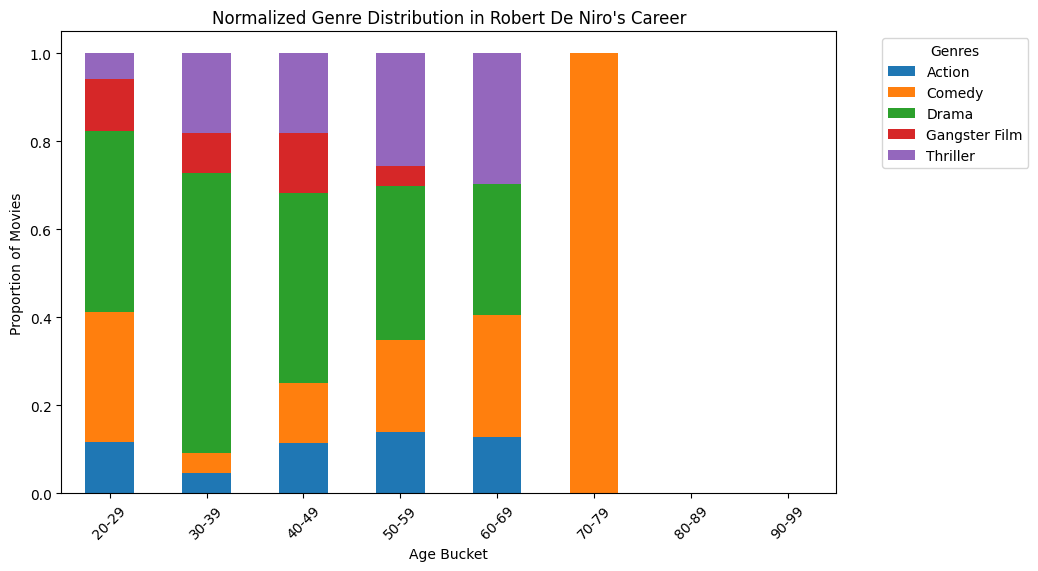

In [206]:
# Filtering for Robert De Niro
relevant_genres = ['Thriller', 'Drama', 'Comedy', "Action", "Gangster Film"]
deniro_df = actor_movies_genre_df[actor_movies_genre_df['Actor name'] == 'Robert De Niro']
deniro_df = deniro_df[deniro_df['genres'].isin(relevant_genres)]
deniro_df['age_group'] = pd.cut(deniro_df['age_at_release'], bins=age_bins, labels=age_labels)
deniro_df = deniro_df.explode('genres')
deniro_genre_distribution = deniro_df.groupby(['age_group', 'genres']).size().unstack(fill_value=0)
normalized_deniro_distribution = deniro_genre_distribution.div(deniro_genre_distribution.sum(axis=1), axis=0)


# Plot for Robert De Niro
normalized_deniro_distribution.plot(kind='bar', stacked=True, figsize=(10,6))
plt.xlabel('Age Bucket')
plt.ylabel('Proportion of Movies')
plt.title('Normalized Genre Distribution in Robert De Niro\'s Career')
plt.xticks(rotation=45)
plt.legend(title='Genres', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

### We will now employ NLP methods to analyze the changes in actors' preferred genres across different age groups. ###

In [207]:
# Loading the summaries of the movies
summaries = pd.read_csv(PLOT_SUMMARIES_PATH, sep='\t',header=None, names=['id', 'summaries'])

summaries.head(10)


,id,summaries
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha..."
1,31186339,The nation of Panem consists of a wealthy Capi...
2,20663735,Poovalli Induchoodan is sentenced for six yea...
3,2231378,"The Lemon Drop Kid , a New York City swindler,..."
4,595909,Seventh-day Adventist Church pastor Michael Ch...
5,5272176,The president is on his way to give a speech. ...
6,1952976,"{{plot}} The film opens in 1974, as a young gi..."
7,24225279,"The story begins with Hannah, a young Jewish t..."
8,2462689,Infuriated at being told to write one final co...
9,20532852,A line of people drool at the window of the s...


In [208]:
# Keep only the movies present in the metadata_df
metadata_summaries = pd.merge(movies_metadata_df,summaries,how = "left",on="id")
metadata_summaries

,id,freebase_id,title,release_date,boxOffice_revenue,runtime,language,country,genres,year,summaries
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",2001.0,"Set in the second half of the 22nd century, th..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,[English Language],[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]",2000.0,NaN
2,28463795,/m/0crgdbh,Brun bitter,1988-01-01,NaN,83.0,[Norwegian Language],[Norway],"[Crime Fiction, Drama]",1988.0,NaN
3,9363483,/m/0285_cd,White Of The Eye,1987-01-01,NaN,110.0,[English Language],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri...",1987.0,A series of murders of rich young women throug...
4,261236,/m/01mrr1,A Woman in Flames,1983-01-01,NaN,106.0,[German Language],[Germany],[Drama],1983.0,"Eva, an upper class housewife, becomes frustra..."
...,...,...,...,...,...,...,...,...,...,...,...
81736,35228177,/m/0j7hxnt,Mermaids: The Body Found,2011-03-19,NaN,120.0,[English Language],[United States of America],[Drama],2011.0,Two former National Oceanic Atmospheric Admini...
81737,34980460,/m/0g4pl34,Knuckle,2011-01-21,NaN,96.0,[English Language],"[Ireland, United Kingdom]","[Biographical film, Drama, Documentary]",2011.0,{{No plot}} This film follows 12 years in the ...
81738,9971909,/m/02pygw1,Another Nice Mess,1972-09-22,NaN,66.0,[English Language],[United States of America],"[Satire, Comedy]",1972.0,NaN
81739,913762,/m/03pcrp,The Super Dimension Fortress Macross II: Lover...,1992-05-21,NaN,150.0,[Japanese Language],[Japan],"[Science Fiction, Japanese Movies, Adventure, ...",1992.0,"The story takes place in the year 2092,The Sup..."


In [209]:
metadata_summaries = metadata_summaries.dropna(subset=["summaries"])

In [210]:
# We will just keep the columns that we want to work with
metadata_summaries = metadata_summaries[["id","summaries"]]

metadata_summaries

,id,summaries
0,975900,"Set in the second half of the 22nd century, th..."
3,9363483,A series of murders of rich young women throug...
4,261236,"Eva, an upper class housewife, becomes frustra..."
6,18998739,"Every hundred years, the evil Morgana returns..."
12,6631279,"Adam, a San Francisco-based artist who works a..."
...,...,...
81733,23851782,{{plot}} The film opens with a Great Western e...
81736,35228177,Two former National Oceanic Atmospheric Admini...
81737,34980460,{{No plot}} This film follows 12 years in the ...
81739,913762,"The story takes place in the year 2092,The Sup..."


In [217]:
# We will now do topic detection using LDA
data = metadata_summaries['summaries'].tolist()
data_words = list(sent_to_words(data))

# Remove stop words
data_words_nostops = remove_stopwords(data_words)

# Create Dictionary
id2word = corpora.Dictionary(data_words_nostops)

texts = data_words_nostops

corpus = [id2word.doc2bow(text) for text in texts]

# Build LDA model
lda_model = LdaModel(corpus=corpus,
                     id2word=id2word,
                     num_topics=6,  
                     random_state=100,
                     update_every=1,
                     chunksize=100,
                     passes=10,
                     alpha='auto',
                     per_word_topics=True)




topics_data = []

for idx, topic in lda_model.print_topics(-1):
    topics_data.append({'TopicID': idx, 'Keywords': topic})

topics_df = pd.DataFrame(topics_data)



In [218]:
topic_distributions = lda_model.get_document_topics(corpus)

metadata_summaries['topic_distribution'] = [list(topic_distribution) for topic_distribution in topic_distributions]
metadata_summaries

,id,summaries,topic_distribution
0,975900,"Set in the second half of the 22nd century, th...","[(0, 0.40932572), (1, 0.36574268), (2, 0.08471..."
3,9363483,A series of murders of rich young women throug...,"[(0, 0.068841), (1, 0.15578252), (2, 0.4818255..."
4,261236,"Eva, an upper class housewife, becomes frustra...","[(0, 0.011365355), (1, 0.01523275), (2, 0.3660..."
6,18998739,"Every hundred years, the evil Morgana returns...","[(0, 0.43100938), (1, 0.02730305), (2, 0.24702..."
12,6631279,"Adam, a San Francisco-based artist who works a...","[(0, 0.012001016), (1, 0.01913536), (2, 0.7107..."
...,...,...,...
81733,23851782,{{plot}} The film opens with a Great Western e...,"[(0, 0.1107419), (1, 0.12116552), (2, 0.412385..."
81736,35228177,Two former National Oceanic Atmospheric Admini...,"[(0, 0.4381366), (1, 0.24112971), (2, 0.073746..."
81737,34980460,{{No plot}} This film follows 12 years in the ...,"[(0, 0.27100104), (1, 0.06807192), (2, 0.06350..."
81739,913762,"The story takes place in the year 2092,The Sup...","[(0, 0.7607941), (1, 0.018532105), (2, 0.04710..."


In [219]:
# Function to find the dominant topic in each document

metadata_summaries['dominant_topic'] = metadata_summaries['topic_distribution'].apply(get_dominant_topic)

metadata_summaries

,id,summaries,topic_distribution,dominant_topic
0,975900,"Set in the second half of the 22nd century, th...","[(0, 0.40932572), (1, 0.36574268), (2, 0.08471...",0
3,9363483,A series of murders of rich young women throug...,"[(0, 0.068841), (1, 0.15578252), (2, 0.4818255...",2
4,261236,"Eva, an upper class housewife, becomes frustra...","[(0, 0.011365355), (1, 0.01523275), (2, 0.3660...",5
6,18998739,"Every hundred years, the evil Morgana returns...","[(0, 0.43100938), (1, 0.02730305), (2, 0.24702...",0
12,6631279,"Adam, a San Francisco-based artist who works a...","[(0, 0.012001016), (1, 0.01913536), (2, 0.7107...",2
...,...,...,...,...
81733,23851782,{{plot}} The film opens with a Great Western e...,"[(0, 0.1107419), (1, 0.12116552), (2, 0.412385...",2
81736,35228177,Two former National Oceanic Atmospheric Admini...,"[(0, 0.4381366), (1, 0.24112971), (2, 0.073746...",0
81737,34980460,{{No plot}} This film follows 12 years in the ...,"[(0, 0.27100104), (1, 0.06807192), (2, 0.06350...",5
81739,913762,"The story takes place in the year 2092,The Sup...","[(0, 0.7607941), (1, 0.018532105), (2, 0.04710...",0


In [220]:
## merge with metadata_df to get the genres of the movies
metadata_summaries = metadata_summaries.merge(movies_metadata_df[["id","genres","freebase_id"]], how = "left", on="id")
metadata_summaries

,id,summaries,topic_distribution,dominant_topic,genres,freebase_id
0,975900,"Set in the second half of the 22nd century, th...","[(0, 0.40932572), (1, 0.36574268), (2, 0.08471...",0,"[Thriller, Science Fiction, Horror, Adventure,...",/m/03vyhn
1,9363483,A series of murders of rich young women throug...,"[(0, 0.068841), (1, 0.15578252), (2, 0.4818255...",2,"[Thriller, Erotic thriller, Psychological thri...",/m/0285_cd
2,261236,"Eva, an upper class housewife, becomes frustra...","[(0, 0.011365355), (1, 0.01523275), (2, 0.3660...",5,[Drama],/m/01mrr1
3,18998739,"Every hundred years, the evil Morgana returns...","[(0, 0.43100938), (1, 0.02730305), (2, 0.24702...",0,"[Family Film, Fantasy, Adventure, World cinema]",/m/04jcqvw
4,6631279,"Adam, a San Francisco-based artist who works a...","[(0, 0.012001016), (1, 0.01913536), (2, 0.7107...",2,"[Romantic comedy, Ensemble Film, Comedy-drama,...",/m/0gffwj
...,...,...,...,...,...,...
42199,23851782,{{plot}} The film opens with a Great Western e...,"[(0, 0.1107419), (1, 0.12116552), (2, 0.412385...",2,"[Crime Fiction, Thriller, Comedy, Supernatural]",/m/06_vb43
42200,35228177,Two former National Oceanic Atmospheric Admini...,"[(0, 0.4381366), (1, 0.24112971), (2, 0.073746...",0,[Drama],/m/0j7hxnt
42201,34980460,{{No plot}} This film follows 12 years in the ...,"[(0, 0.27100104), (1, 0.06807192), (2, 0.06350...",5,"[Biographical film, Drama, Documentary]",/m/0g4pl34
42202,913762,"The story takes place in the year 2092,The Sup...","[(0, 0.7607941), (1, 0.018532105), (2, 0.04710...",0,"[Science Fiction, Japanese Movies, Adventure, ...",/m/03pcrp


In [221]:
from collections import Counter



# Group by 'dominant_topic' and aggregate genres
grouped = metadata_summaries.groupby('dominant_topic')['genres'].sum()

genre_counts_by_topic = {}

# Count genres within each topic
for topic, genres in grouped.items():
    genre_counts = Counter(genres)
    genre_counts_by_topic[topic] = genre_counts

for topic, counts in genre_counts_by_topic.items():
    print(f"Dominant Topic {topic}:")
    print(counts)



Dominant Topic 0:
Counter({'Drama': 2275, 'Action': 2206, 'Adventure': 1616, 'Action/Adventure': 1445, 'Science Fiction': 1251, 'Thriller': 1139, 'War film': 1111, 'Comedy': 939, 'World cinema': 814, 'Fantasy': 680, 'Black-and-white': 653, 'Horror': 578, 'Animation': 563, 'Japanese Movies': 459, 'Family Film': 424, 'Martial Arts Film': 409, 'Crime Fiction': 374, 'Chinese Movies': 374, 'Romance Film': 359, 'Documentary': 353, 'Indie': 343, 'Short Film': 343, 'Period piece': 307, 'Western': 231, 'Spy': 220, 'Film adaptation': 216, 'Anime': 206, 'Mystery': 187, 'History': 184, 'Parody': 182, 'Historical fiction': 171, 'Costume drama': 168, 'Political drama': 162, 'Action Thrillers': 157, 'Silent film': 154, "Children's/Family": 143, 'Biographical film': 139, 'Television movie': 137, 'Disaster': 137, 'Superhero movie': 136, 'Romantic drama': 131, 'Comedy film': 127, 'Fantasy Adventure': 125, 'Epic': 118, 'Crime Thriller': 118, 'Cult': 115, 'Biography': 113, 'Creature Film': 106, 'Musical':

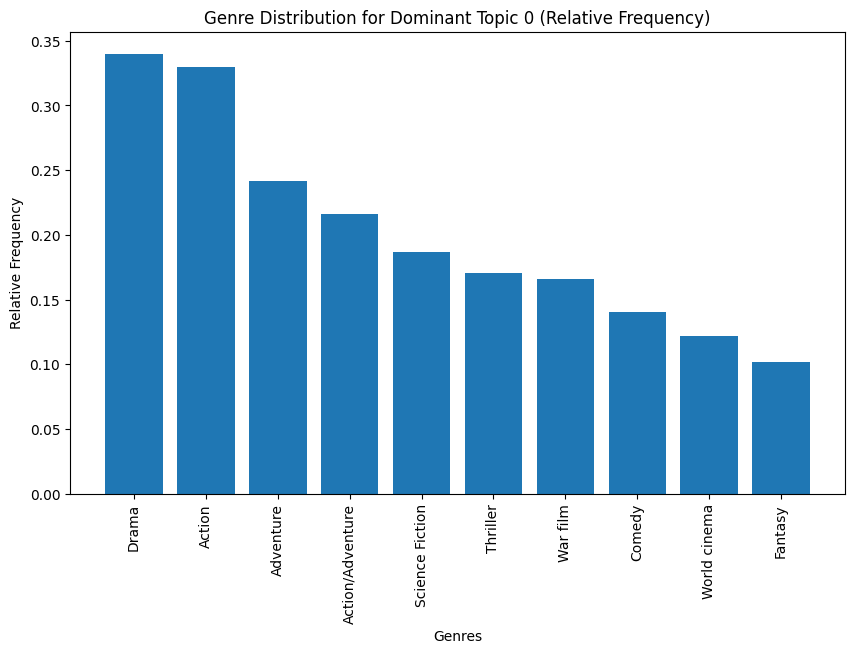

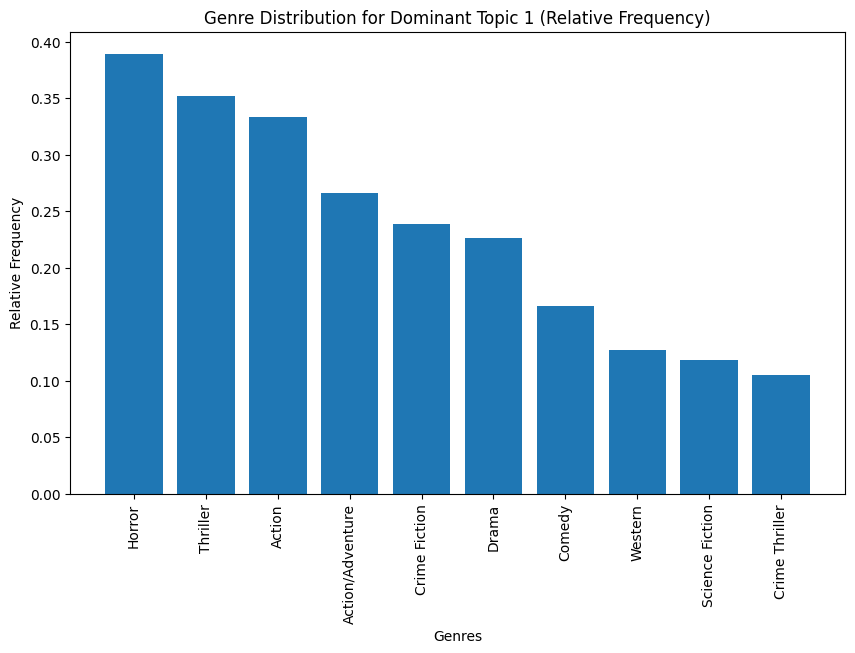

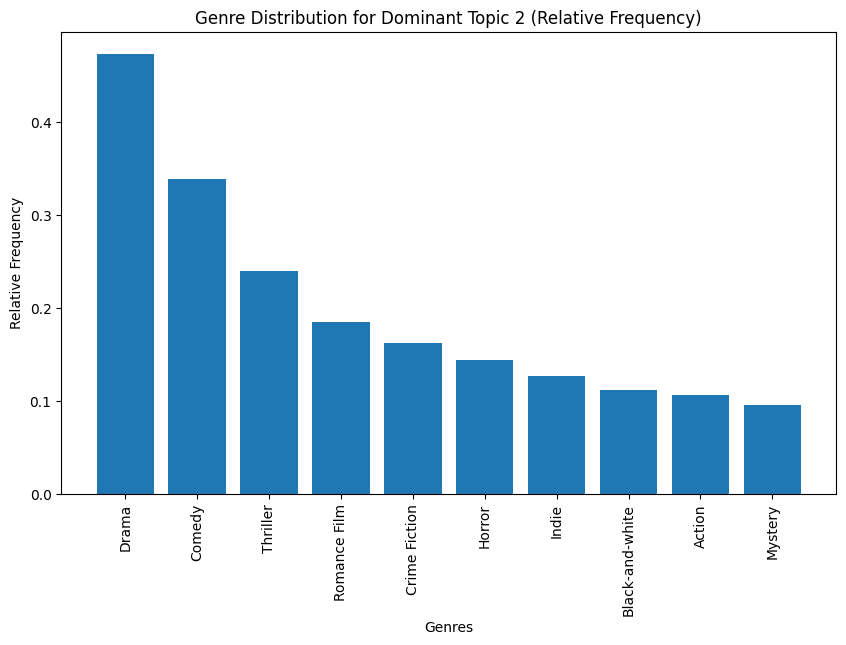

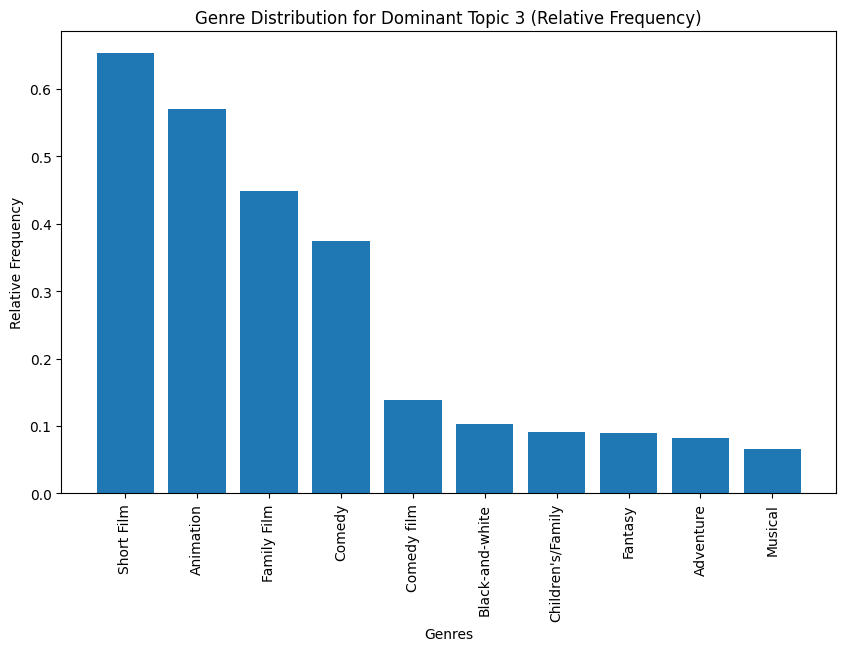

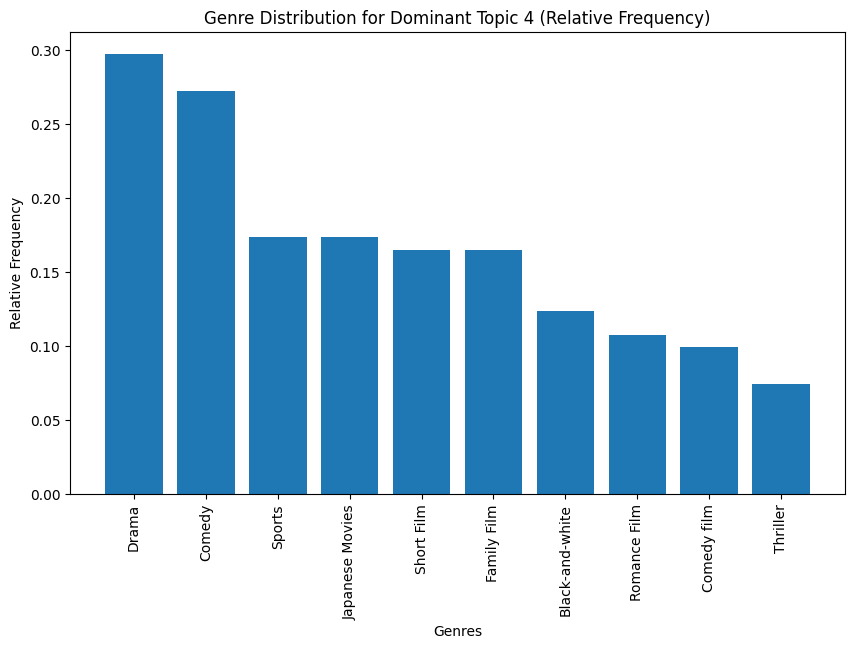

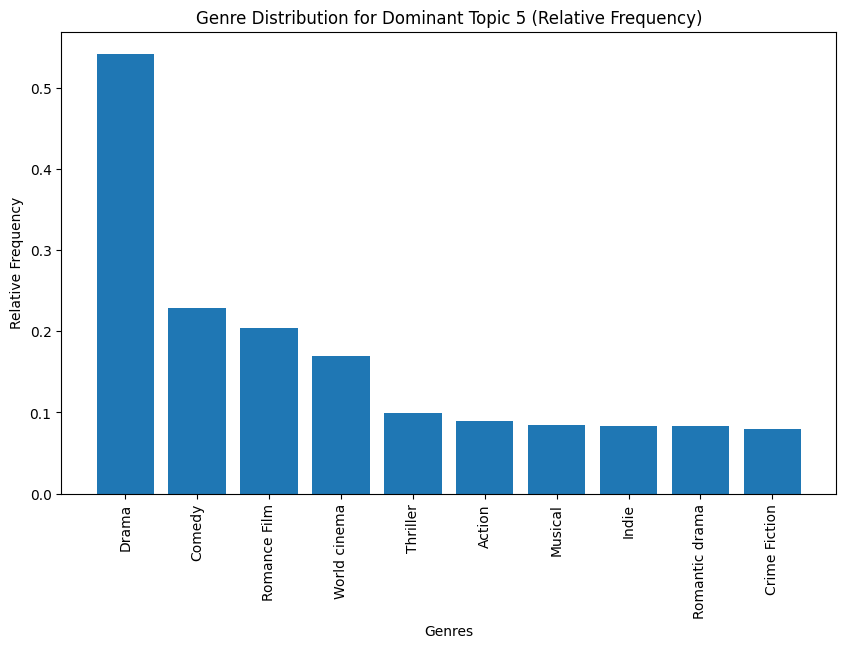

In [222]:
# Calculate the total number of movies for each dominant topic
total_movies_by_topic = metadata_summaries.groupby('dominant_topic').size()

# Plot the relative frequency of the top 10 genres for each dominant topic
for topic, counts in genre_counts_by_topic.items():
    # Get the total number of movies in this topic
    total_movies = total_movies_by_topic[topic]

    # Get the top 10 most common genres and their relative frequencies
    top_genres = [(genre, count / total_movies) for genre, count in counts.most_common(10)]
    
    genres, relative_frequencies = zip(*top_genres)

    plt.figure(figsize=(10, 6))
    plt.bar(genres, relative_frequencies)
    plt.title(f'Genre Distribution for Dominant Topic {topic} (Relative Frequency)')
    plt.ylabel('Relative Frequency')
    plt.xlabel('Genres')
    plt.xticks(rotation=90)
    plt.show()


Based on the results above, we will characterize each topic by a name

In [223]:
# Create a mapping dictionary
topic_mapping = {
    0: "Action/Adventure/Scify",
    1: "Horror/Thriller",
    2: "Drama",
    3: "Comedy",
    4: "Other",
    5: "Romantic"
}


metadata_summaries["dominant_topic"] = metadata_summaries["dominant_topic"].map(topic_mapping)
metadata_summaries

,id,summaries,topic_distribution,dominant_topic,genres,freebase_id
0,975900,"Set in the second half of the 22nd century, th...","[(0, 0.40932572), (1, 0.36574268), (2, 0.08471...",Action/Adventure/Scify,"[Thriller, Science Fiction, Horror, Adventure,...",/m/03vyhn
1,9363483,A series of murders of rich young women throug...,"[(0, 0.068841), (1, 0.15578252), (2, 0.4818255...",Drama,"[Thriller, Erotic thriller, Psychological thri...",/m/0285_cd
2,261236,"Eva, an upper class housewife, becomes frustra...","[(0, 0.011365355), (1, 0.01523275), (2, 0.3660...",Romantic,[Drama],/m/01mrr1
3,18998739,"Every hundred years, the evil Morgana returns...","[(0, 0.43100938), (1, 0.02730305), (2, 0.24702...",Action/Adventure/Scify,"[Family Film, Fantasy, Adventure, World cinema]",/m/04jcqvw
4,6631279,"Adam, a San Francisco-based artist who works a...","[(0, 0.012001016), (1, 0.01913536), (2, 0.7107...",Drama,"[Romantic comedy, Ensemble Film, Comedy-drama,...",/m/0gffwj
...,...,...,...,...,...,...
42199,23851782,{{plot}} The film opens with a Great Western e...,"[(0, 0.1107419), (1, 0.12116552), (2, 0.412385...",Drama,"[Crime Fiction, Thriller, Comedy, Supernatural]",/m/06_vb43
42200,35228177,Two former National Oceanic Atmospheric Admini...,"[(0, 0.4381366), (1, 0.24112971), (2, 0.073746...",Action/Adventure/Scify,[Drama],/m/0j7hxnt
42201,34980460,{{No plot}} This film follows 12 years in the ...,"[(0, 0.27100104), (1, 0.06807192), (2, 0.06350...",Romantic,"[Biographical film, Drama, Documentary]",/m/0g4pl34
42202,913762,"The story takes place in the year 2092,The Sup...","[(0, 0.7607941), (1, 0.018532105), (2, 0.04710...",Action/Adventure/Scify,"[Science Fiction, Japanese Movies, Adventure, ...",/m/03pcrp


In [224]:
actors_df = importance_df
actors_df

,Actor date of birth,Actor gender,Actor ethnicity,Actor name,Freebase actor ID,Actor birth year,title_x,freebase_id,id,title_y,...,overview,popularity,production_companies,budget,vote_average,vote_count,credits,importance,Ethnicity Region,Movie region
0,1958-08-26,F,NaN,Wanda De Jesus,/m/03wcfv7,1958.0,"[Ghosts of Mars, The Ministers, Almost a Woman...",/m/03vyhn,975900,Ghosts of Mars,...,In 2176 a Martian police unit is sent to pick ...,13.057,Screen Gems-Storm King Productions-Animationwerks,28000000.0,5.154,911.0,Natasha Henstridge-Ice Cube-Pam Grier-Jason St...,0.076923,Unknown,Northern America
1,1974-08-15,F,Other Ethnicities,Natasha Henstridge,/m/0346l4,1974.0,"[Ghosts of Mars, Adrenalin: Fear the Rush, The...",/m/03vyhn,975900,Ghosts of Mars,...,In 2176 a Martian police unit is sent to pick ...,13.057,Screen Gems-Storm King Productions-Animationwerks,28000000.0,5.154,911.0,Natasha Henstridge-Ice Cube-Pam Grier-Jason St...,1.000000,Unknown Region,Northern America
2,1969-06-15,M,African Americans,Ice Cube,/m/01vw26l,1969.0,"[Ghosts of Mars, Friday After Next, XXX: The R...",/m/03vyhn,975900,Ghosts of Mars,...,In 2176 a Martian police unit is sent to pick ...,13.057,Screen Gems-Storm King Productions-Animationwerks,28000000.0,5.154,911.0,Natasha Henstridge-Ice Cube-Pam Grier-Jason St...,0.500000,Northern America,Northern America
3,1967-09-12,M,NaN,Jason Statham,/m/034hyc,1967.0,"[Ghosts of Mars, The Expendables, Death Race, ...",/m/03vyhn,975900,Ghosts of Mars,...,In 2176 a Martian police unit is sent to pick ...,13.057,Screen Gems-Storm King Productions-Animationwerks,28000000.0,5.154,911.0,Natasha Henstridge-Ice Cube-Pam Grier-Jason St...,0.250000,Unknown,Northern America
4,1977-09-25,F,NaN,Clea DuVall,/m/01y9xg,1977.0,"[Ghosts of Mars, Sleeping Beauties, The Grudge...",/m/03vyhn,975900,Ghosts of Mars,...,In 2176 a Martian police unit is sent to pick ...,13.057,Screen Gems-Storm King Productions-Animationwerks,28000000.0,5.154,911.0,Natasha Henstridge-Ice Cube-Pam Grier-Jason St...,0.200000,Unknown,Northern America
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
385414,NaT,NaN,NaN,Evelyn Manqina,/m/0gyzc3y,NaN,[Long Night's Journey Into Day],/m/02vwq7k,12228903,Long Night's Journey Into Day,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,Unknown,Northern America
385415,NaT,NaN,NaN,Linda Biehl,/m/0gy_7mh,NaN,[Long Night's Journey Into Day],/m/02vwq7k,12228903,Long Night's Journey Into Day,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,Unknown,Northern America
385416,NaT,NaN,NaN,Mongezi Manqina,/m/0bfrv0s,NaN,[Long Night's Journey Into Day],/m/02vwq7k,12228903,Long Night's Journey Into Day,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,Unknown,Northern America
385417,NaT,NaN,NaN,Easy Nofemela,/m/0gyy2fj,NaN,[Long Night's Journey Into Day],/m/02vwq7k,12228903,Long Night's Journey Into Day,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,Unknown,Northern America


We will do revenue and popularity analysis on important actors

In [225]:


actors_df['importance'] = actors_df.apply(calculate_importance, axis=1)

In [226]:
actors_df = actors_df[actors_df["importance"] >= 0.2]## Keep only top 5 actors

actors_df.head(12)

,Actor date of birth,Actor gender,Actor ethnicity,Actor name,Freebase actor ID,Actor birth year,title_x,freebase_id,id,title_y,...,overview,popularity,production_companies,budget,vote_average,vote_count,credits,importance,Ethnicity Region,Movie region
1,1974-08-15,F,Other Ethnicities,Natasha Henstridge,/m/0346l4,1974.0,"[Ghosts of Mars, Adrenalin: Fear the Rush, The...",/m/03vyhn,975900,Ghosts of Mars,...,In 2176 a Martian police unit is sent to pick ...,13.057,Screen Gems-Storm King Productions-Animationwerks,28000000.0,5.154,911.0,Natasha Henstridge-Ice Cube-Pam Grier-Jason St...,1.000000,Unknown Region,Northern America
2,1969-06-15,M,African Americans,Ice Cube,/m/01vw26l,1969.0,"[Ghosts of Mars, Friday After Next, XXX: The R...",/m/03vyhn,975900,Ghosts of Mars,...,In 2176 a Martian police unit is sent to pick ...,13.057,Screen Gems-Storm King Productions-Animationwerks,28000000.0,5.154,911.0,Natasha Henstridge-Ice Cube-Pam Grier-Jason St...,0.500000,Northern America,Northern America
3,1967-09-12,M,NaN,Jason Statham,/m/034hyc,1967.0,"[Ghosts of Mars, The Expendables, Death Race, ...",/m/03vyhn,975900,Ghosts of Mars,...,In 2176 a Martian police unit is sent to pick ...,13.057,Screen Gems-Storm King Productions-Animationwerks,28000000.0,5.154,911.0,Natasha Henstridge-Ice Cube-Pam Grier-Jason St...,0.250000,Unknown,Northern America
4,1977-09-25,F,NaN,Clea DuVall,/m/01y9xg,1977.0,"[Ghosts of Mars, Sleeping Beauties, The Grudge...",/m/03vyhn,975900,Ghosts of Mars,...,In 2176 a Martian police unit is sent to pick ...,13.057,Screen Gems-Storm King Productions-Animationwerks,28000000.0,5.154,911.0,Natasha Henstridge-Ice Cube-Pam Grier-Jason St...,0.200000,Unknown,Northern America
5,1949-05-26,F,African Americans,Pam Grier,/m/0418ft,1949.0,"[Ghosts of Mars, Just Wright, Women in Cages, ...",/m/03vyhn,975900,Ghosts of Mars,...,In 2176 a Martian police unit is sent to pick ...,13.057,Screen Gems-Storm King Productions-Animationwerks,28000000.0,5.154,911.0,Natasha Henstridge-Ice Cube-Pam Grier-Jason St...,0.333333,Northern America,Northern America
17,1958-08-26,F,NaN,Wanda De Jesus,/m/03wcfv7,1958.0,"[Ghosts of Mars, The Ministers, Almost a Woman...",/m/0809s7n,24767455,The Ministers,...,A NYPD detective attempts to avenge the death ...,6.137,Alumbra Films-Grow Pictures-Scheherazade,0.0,4.900,20.0,John Leguizamo-Harvey Keitel-Florencia Lozano-...,0.200000,Unknown,Northern America
18,1964-07-22,M,Hispanic and Latino Americans,John Leguizamo,/m/04yj5z,1964.0,"[Vanishing on 7th Street, Time Expired, The Fa...",/m/0809s7n,24767455,The Ministers,...,A NYPD detective attempts to avenge the death ...,6.137,Alumbra Films-Grow Pictures-Scheherazade,0.0,4.900,20.0,John Leguizamo-Harvey Keitel-Florencia Lozano-...,1.000000,"Southern America, Northern America",Northern America
19,1939-05-13,M,Polish Americans,Harvey Keitel,/m/0klh7,1939.0,"[Crime Spree, Arthur and the Invisibles, City ...",/m/0809s7n,24767455,The Ministers,...,A NYPD detective attempts to avenge the death ...,6.137,Alumbra Films-Grow Pictures-Scheherazade,0.0,4.900,20.0,John Leguizamo-Harvey Keitel-Florencia Lozano-...,0.500000,"Eastern Europe, Northern America",Northern America
20,1952-08-10,F,NaN,Diane Venora,/m/0718s1,1952.0,"[Surviving Picasso, Romeo + Juliet, The Cotton...",/m/0809s7n,24767455,The Ministers,...,A NYPD detective attempts to avenge the death ...,6.137,Alumbra Films-Grow Pictures-Scheherazade,0.0,4.900,20.0,John Leguizamo-Harvey Keitel-Florencia Lozano-...,0.250000,Unknown,Northern America
23,1969-12-16,F,NaN,Florencia Lozano,/m/04f1bcv,1969.0,"[The Ministers, Perfect Stranger, Veronika Dec...",/m/0809s7n,24767455,The Ministers,...,A NYPD detective attempts to avenge the death ...,6.137,Alumbra Films-Grow Pictures-Scheherazade,0.0,4.900,20.0,John Leguizamo-Harvey Keitel-Florencia Lozano-...,0.333333,Unknown,Northern America


In [227]:
actors_df['release_date'] = pd.to_datetime(actors_df['release_date'])

# Calculate age at release
actors_df["age_at_release"] = actors_df["release_date"].dt.year - actors_df["Actor birth year"]
actors_df["age_at_release"] = actors_df["age_at_release"].astype(float)

actors_df

,Actor date of birth,Actor gender,Actor ethnicity,Actor name,Freebase actor ID,Actor birth year,title_x,freebase_id,id,title_y,...,popularity,production_companies,budget,vote_average,vote_count,credits,importance,Ethnicity Region,Movie region,age_at_release
1,1974-08-15,F,Other Ethnicities,Natasha Henstridge,/m/0346l4,1974.0,"[Ghosts of Mars, Adrenalin: Fear the Rush, The...",/m/03vyhn,975900,Ghosts of Mars,...,13.057,Screen Gems-Storm King Productions-Animationwerks,28000000.0,5.154,911.0,Natasha Henstridge-Ice Cube-Pam Grier-Jason St...,1.000000,Unknown Region,Northern America,27.0
2,1969-06-15,M,African Americans,Ice Cube,/m/01vw26l,1969.0,"[Ghosts of Mars, Friday After Next, XXX: The R...",/m/03vyhn,975900,Ghosts of Mars,...,13.057,Screen Gems-Storm King Productions-Animationwerks,28000000.0,5.154,911.0,Natasha Henstridge-Ice Cube-Pam Grier-Jason St...,0.500000,Northern America,Northern America,32.0
3,1967-09-12,M,NaN,Jason Statham,/m/034hyc,1967.0,"[Ghosts of Mars, The Expendables, Death Race, ...",/m/03vyhn,975900,Ghosts of Mars,...,13.057,Screen Gems-Storm King Productions-Animationwerks,28000000.0,5.154,911.0,Natasha Henstridge-Ice Cube-Pam Grier-Jason St...,0.250000,Unknown,Northern America,34.0
4,1977-09-25,F,NaN,Clea DuVall,/m/01y9xg,1977.0,"[Ghosts of Mars, Sleeping Beauties, The Grudge...",/m/03vyhn,975900,Ghosts of Mars,...,13.057,Screen Gems-Storm King Productions-Animationwerks,28000000.0,5.154,911.0,Natasha Henstridge-Ice Cube-Pam Grier-Jason St...,0.200000,Unknown,Northern America,24.0
5,1949-05-26,F,African Americans,Pam Grier,/m/0418ft,1949.0,"[Ghosts of Mars, Just Wright, Women in Cages, ...",/m/03vyhn,975900,Ghosts of Mars,...,13.057,Screen Gems-Storm King Productions-Animationwerks,28000000.0,5.154,911.0,Natasha Henstridge-Ice Cube-Pam Grier-Jason St...,0.333333,Northern America,Northern America,52.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
385398,NaT,M,NaN,Rafael Atoyan,/m/0n670xm,NaN,[Yearning],/m/0421l_t,17111000,Yearning,...,0.960,Armenfilm-Hayfilm Studio,0.0,5.000,4.0,Rafael Atoyan-Galya Novents-Ashot Melikdzhanya...,1.000000,Unknown,Unknown,NaN
385399,1937-07-10,F,NaN,Galya Novents,/m/0n670_7,1937.0,[Yearning],/m/0421l_t,17111000,Yearning,...,0.960,Armenfilm-Hayfilm Studio,0.0,5.000,4.0,Rafael Atoyan-Galya Novents-Ashot Melikdzhanya...,0.500000,Unknown,Unknown,53.0
385400,NaT,M,NaN,Ashot Melikdzhanyan,/m/0n6713k,NaN,[Yearning],/m/0421l_t,17111000,Yearning,...,0.960,Armenfilm-Hayfilm Studio,0.0,5.000,4.0,Rafael Atoyan-Galya Novents-Ashot Melikdzhanya...,0.333333,Unknown,Unknown,NaN
385401,NaT,F,NaN,H. Kartashyan,/m/0n67197,NaN,[Yearning],/m/0421l_t,17111000,Yearning,...,0.960,Armenfilm-Hayfilm Studio,0.0,5.000,4.0,Rafael Atoyan-Galya Novents-Ashot Melikdzhanya...,0.250000,Unknown,Unknown,NaN


In [228]:
actors_df = actors_df[["Freebase actor ID","freebase_id","age_at_release","boxOffice_revenue","popularity"]].drop_duplicates()

actors_df

,Freebase actor ID,freebase_id,age_at_release,boxOffice_revenue,popularity
1,/m/0346l4,/m/03vyhn,27.0,14010832.0,13.057
2,/m/01vw26l,/m/03vyhn,32.0,14010832.0,13.057
3,/m/034hyc,/m/03vyhn,34.0,14010832.0,13.057
4,/m/01y9xg,/m/03vyhn,24.0,14010832.0,13.057
5,/m/0418ft,/m/03vyhn,52.0,14010832.0,13.057
...,...,...,...,...,...
385398,/m/0n670xm,/m/0421l_t,NaN,NaN,0.960
385399,/m/0n670_7,/m/0421l_t,53.0,NaN,0.960
385400,/m/0n6713k,/m/0421l_t,NaN,NaN,0.960
385401,/m/0n67197,/m/0421l_t,NaN,NaN,0.960


In [229]:
## Get topic of the movie
actors_df = pd.merge(actors_df, metadata_summaries[["dominant_topic","freebase_id"]], left_on = "freebase_id", right_on = "freebase_id")
actors_df

,Freebase actor ID,freebase_id,age_at_release,boxOffice_revenue,popularity,dominant_topic
0,/m/0346l4,/m/03vyhn,27.0,14010832.0,13.057,Action/Adventure/Scify
1,/m/01vw26l,/m/03vyhn,32.0,14010832.0,13.057,Action/Adventure/Scify
2,/m/034hyc,/m/03vyhn,34.0,14010832.0,13.057,Action/Adventure/Scify
3,/m/01y9xg,/m/03vyhn,24.0,14010832.0,13.057,Action/Adventure/Scify
4,/m/0418ft,/m/03vyhn,52.0,14010832.0,13.057,Action/Adventure/Scify
...,...,...,...,...,...,...
86725,/m/0jmqkf4,/m/0j3c9wf,NaN,NaN,4.421,Romantic
86726,/m/0ls3ncn,/m/0j3c9wf,NaN,NaN,4.421,Romantic
86727,/m/0ls417n,/m/0j3c9wf,NaN,NaN,4.421,Romantic
86728,/m/0k7kkj,/m/0dmx7l,NaN,NaN,0.600,Drama


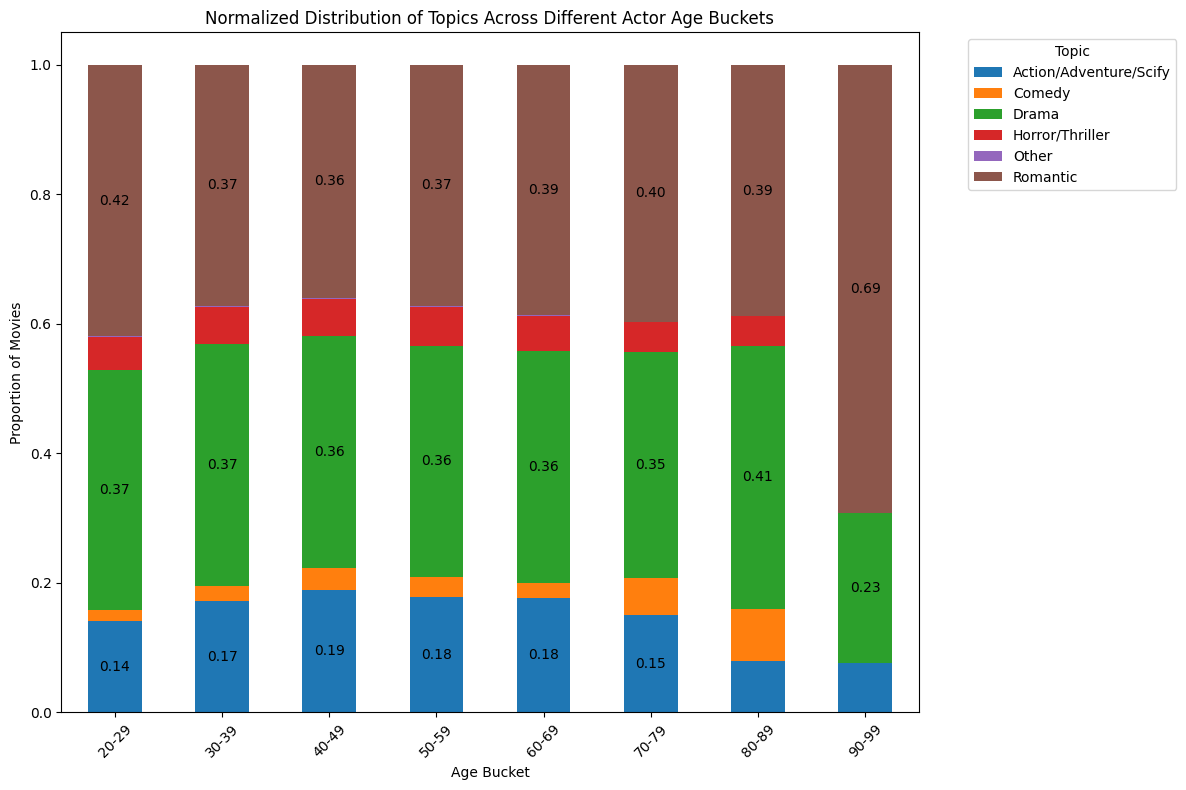

In [230]:

filtered_df = actors_df.copy()



age_bins = [20, 30, 40, 50, 60, 70, 80, 90, 100]
age_labels = ['20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80-89', '90-99']

# Categorize age and explode genres
filtered_df['age_group'] = pd.cut(filtered_df['age_at_release'], bins=age_bins, labels=age_labels)

# Group by age group and genres, then plot
genre_distribution_per_age_group = filtered_df.groupby(['age_group', 'dominant_topic']).size().unstack(fill_value=0)

normalized_genre_distribution = genre_distribution_per_age_group.div(genre_distribution_per_age_group.sum(axis=1), axis=0)

fig, ax = plt.subplots(figsize=(12, 8))
normalized_genre_distribution.plot(kind='bar', stacked=True, ax=ax)

plt.xlabel('Age Bucket')
plt.ylabel('Proportion of Movies')
plt.title('Normalized Distribution of Topics Across Different Actor Age Buckets')
plt.xticks(rotation=45)
plt.legend(title='Topic', bbox_to_anchor=(1.05, 1), loc='upper left')

# Adding the proportion text to each bar segment only if the proportion is greater than 0.1
for bars in ax.containers:
    labels = [f'{v:.2f}' if (v > 0.1) else '' for v in bars.datavalues]
    ax.bar_label(bars, labels=labels, label_type='center')

plt.tight_layout()
plt.show()

Drama seems to be a consistently significant genre across all age groups, with the proportion typically around 0.35 to 0.40

The chart indicates a discernible shift in the genres that actors engage with throughout their careers. 

Younger actors are more frequently involved in action, adventure, and science fiction films, as well as horror movies. 

As actors mature, there's a noticeable pivot towards roles in romantic and comic genres.

We will now examine whether these shifts in topic preference among actors are influenced by revenue or popularity, by analyzing and plotting the revenue and popularity metrics for each age group and topic

In [231]:
movie_revs  = actors_df[["freebase_id","boxOffice_revenue","popularity","dominant_topic"]]
movie_revs = movie_revs.drop_duplicates()

movie_revs

,freebase_id,boxOffice_revenue,popularity,dominant_topic
0,/m/03vyhn,14010832.0,13.057,Action/Adventure/Scify
5,/m/0809s7n,NaN,6.137,Romantic
10,/m/04t8wq,45681173.0,26.192,Action/Adventure/Scify
15,/m/03gt21w,2346150.0,3.832,Drama
20,/m/0f1fx8,3291163.0,4.252,Drama
...,...,...,...,...
86720,/m/0g4ny6s,58840.0,1.952,Romantic
86723,/m/04y8635,NaN,0.600,Action/Adventure/Scify
86724,/m/052qqt6,NaN,1.702,Drama
86725,/m/0j3c9wf,NaN,4.421,Romantic


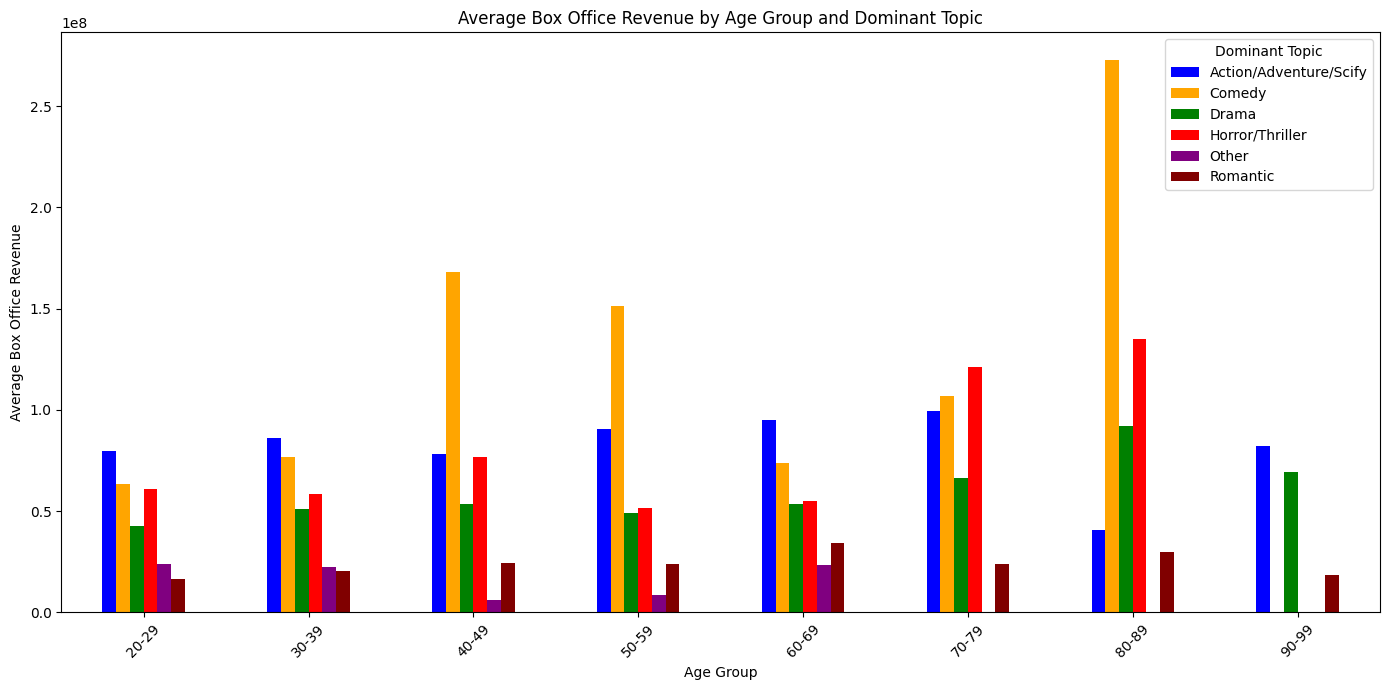

In [232]:

topic_color_mapping = {
    "Action/Adventure/Scify": 'blue',
    "Horror/Thriller": 'red',
    "Drama": 'green',
    "Comedy": 'orange',
    "Other": 'purple',
    "Romantic": 'maroon'
}

filtered_df['topic_color'] = filtered_df['dominant_topic'].map(topic_color_mapping)

# Drop rows where 'boxOffice_revenue' or 'age_group' is NaN
cleaned_df = filtered_df.dropna(subset=['boxOffice_revenue',"popularity", 'age_group'])

# Group by 'age_group' and 'dominant_topic', then calculate the mean 'boxOffice_revenue'
grouped_data = cleaned_df.groupby(['age_group', 'dominant_topic'])['boxOffice_revenue'].mean().unstack()

ax = grouped_data.plot(kind='bar', figsize=(14, 7), color=[topic_color_mapping[topic] for topic in grouped_data.columns])

plt.title('Average Box Office Revenue by Age Group and Dominant Topic')
plt.xlabel('Age Group')
plt.ylabel('Average Box Office Revenue')
plt.xticks(rotation=45)

plt.legend([topic for topic in grouped_data.columns], title='Dominant Topic')

plt.tight_layout()
plt.show()


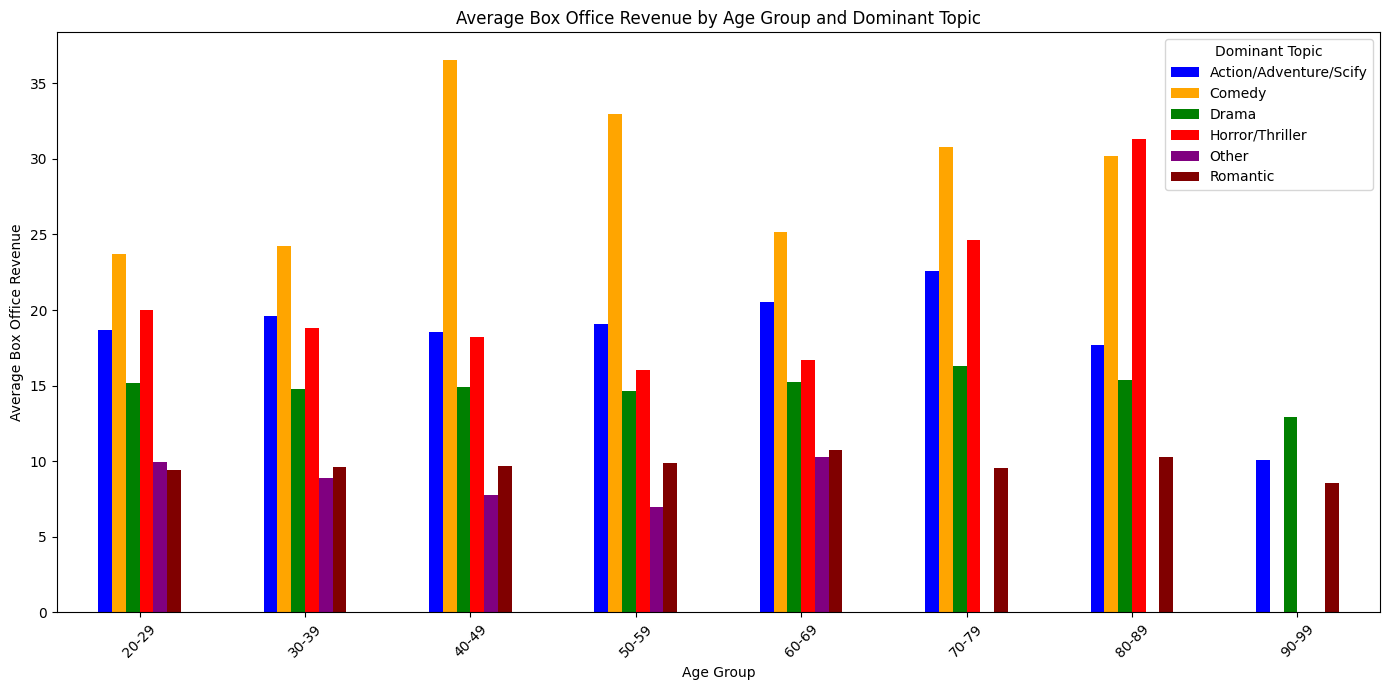

In [233]:


# Drop rows where 'boxOffice_revenue' or 'age_group' is NaN
cleaned_df = filtered_df.dropna(subset=['boxOffice_revenue',"popularity", 'age_group'])

# Group by 'age_group' and 'dominant_topic', then calculate the mean 'popularity'
grouped_data = cleaned_df.groupby(['age_group', 'dominant_topic'])['popularity'].mean().unstack()

ax = grouped_data.plot(kind='bar', figsize=(14, 7), color=[topic_color_mapping[topic] for topic in grouped_data.columns])

plt.title('Average Box Office Revenue by Age Group and Dominant Topic')
plt.xlabel('Age Group')
plt.ylabel('Average Box Office Revenue')
plt.xticks(rotation=45)

plt.legend([topic for topic in grouped_data.columns], title='Dominant Topic')

plt.tight_layout()
plt.show()


From the analyses of popularity and revenue plots, it is evident that comedy enjoys the highest overall popularity and revenue across various age groups. This trend aligns with expectations, as comedy films are generally suitable for all ages and tend to attract a wide spectrum of society. 

In contrast, horror movies appear to yield substantial payoffs even for actors in older age groups, which could be attributed to the scarcity of actors willing to perform in horror films. 


Overall, there doesn't appear to be a genre shift among actors based on the popularity or revenue generated by different genres across age groups. This suggests that factors other than financial success or mass appeal, such as the suitability of roles and actor profiling, may influence genre transitions throughout an actor's career.